This is a tiny amount of scaffolding around the directed homophilic preferential attachment code written by Lisette Espin and others ([available here](https://github.com/gesiscss/Homophilic_Directed_ScaleFree_Networks)). In particular, we replicate a simple case where homophily within groups can lead to inequities between groups, defined as underrepresentation of minorities in the top k% of ranks.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import time

import os

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [2]:
os.chdir(os.path.dirname(os.path.abspath('')))

In [3]:
from paper.DPAH import DPAH
from DPAH2 import DPAH2, ER_homophily_allies

In [49]:
def compute_inequity_ER_avg(M, k, fm, fa):
    """Compute the average rank of allies and minorities in M.
    
    M is an adjacency matrix where fraction fm nodes are minority, fraction fa nodes are allies."""
    
    N_m = int(len(M) * fm)
    N_a = int(len(M) * fa)
    N_M = len(M) - (N_m + N_a)
    
    node_pageranks = nx.pagerank(nx.from_numpy_matrix(M))
    node_pageranks_sorted = sorted(node_pageranks.items(), key=lambda x: x[1], reverse=True)
    ranks_of_nodes = np.argsort(np.array(node_pageranks_sorted)[:,0])
 
    avg_rank_M = np.mean(ranks_of_nodes[:N_M])
    avg_rank_m = np.mean(ranks_of_nodes[N_M:(N_M + N_m)])
    avg_rank_a = np.mean(ranks_of_nodes[(N_M + N_m):])
    
    return avg_rank_M, avg_rank_m, avg_rank_a


def compute_inequity_ER(M, k, fm, fa):
    """Compute the proportion of allies and minorities in the top k ranks of M.
    
    M is an adjacency matrix where fraction fm nodes are minority, fraction fa nodes are allies."""
    
    N_m = int(len(M) * fm)
    N_a = int(len(M) * fa)
    N_M = len(M) - (N_m + N_a)
    
    node_pageranks = nx.pagerank(nx.from_numpy_matrix(M))
    node_pageranks_sorted = sorted(node_pageranks.items(), key=lambda x: x[1], reverse=True)
    top_k = np.array(node_pageranks_sorted[:k])[:,0]
 
    num_top_k_majority = sum(top_k <= N_M)
    num_top_k_minority = sum(top_k <= (N_M + N_m)) - num_top_k_majority
    num_top_k_allies = k - (num_top_k_majority + num_top_k_minority)
    
    return num_top_k_allies / k, num_top_k_minority / k


def compute_inequity(g, k):
    """Compute the proportion of allies and minorities in the top k ranks of g"""
    node_pageranks = nx.pagerank(g)
    node_pageranks_sorted = sorted(node_pageranks.items(), key=lambda x: x[1], reverse=True)
    top_k = node_pageranks_sorted[:k]
    
    num_top_k_allies = 0
    num_top_k_minority = 0
    
    for (node_id, _) in top_k:
        if g.nodes[node_id]['m'] == 1: # is an ally:
            num_top_k_allies += 1
        elif g.nodes[node_id]['m'] == 2: # is minority
            num_top_k_minority += 1
    
    return num_top_k_allies / k, num_top_k_minority / k

In [5]:
# Number of nodes
N = 1000

# Top beta% of rankings to consider for inequity
beta = 0.05

# Top k nodes to consider for inequity. k = N * beta
k = int(N * beta)

# Fraction minority
# fm = 0.2

# Fraction allies
fa = 0

# homophily within majority group
h_MM = 0.8

# homophily within minority group
h_mm = 0.8

print(k)

50


# Directed preferential-attachment with homophily and allies

With strong homophily (h_MM=h_mm=0.8), in all five runs minorities are underrepresented in the top 5% (50) of ranks. In particular, with equity, we'd expect an average representation of 20% in the top ranks.

In [17]:
results = []

beta_list = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4,
            0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 
            0.85, 0.9, 0.95, 1]


for fm in np.linspace(0.05, 0.5, 10):
    for fraction_allies in np.linspace(0, 0.5 - fm, 10):
        for i in range(20):
            g = DPAH2(
                N=N,
                fm=fm,
                fa=fraction_allies, # Fraction that are allies
                d=0.0015,
                plo_M=3,
                plo_m=3,
                h_MM=h_MM,
                h_mm=h_mm,
                verbose=False,
                seed=i)

            for beta in beta_list:
                # Top k nodes to consider for inequity. k = N * beta
                k = int(N * beta)
                prop_top_k_ally, prop_top_k_minority = compute_inequity(g, k)
                results.append((fm, fraction_allies, beta, prop_top_k_ally, prop_top_k_minority))
                print((fm, fraction_allies, beta, prop_top_k_ally, prop_top_k_minority))

(0.05, 0.0, 0.05, 0.0, 0.0)
(0.05, 0.0, 0.1, 0.0, 0.01)
(0.05, 0.0, 0.15, 0.0, 0.006666666666666667)
(0.05, 0.0, 0.2, 0.0, 0.01)
(0.05, 0.0, 0.25, 0.0, 0.012)
(0.05, 0.0, 0.3, 0.0, 0.016666666666666666)
(0.05, 0.0, 0.35, 0.0, 0.017142857142857144)
(0.05, 0.0, 0.4, 0.0, 0.015)
(0.05, 0.0, 0.45, 0.0, 0.013333333333333334)
(0.05, 0.0, 0.5, 0.0, 0.012)
(0.05, 0.0, 0.55, 0.0, 0.01090909090909091)
(0.05, 0.0, 0.6, 0.0, 0.01)
(0.05, 0.0, 0.65, 0.0, 0.009230769230769232)
(0.05, 0.0, 0.7, 0.0, 0.008571428571428572)
(0.05, 0.0, 0.75, 0.0, 0.008)
(0.05, 0.0, 0.8, 0.0, 0.0075)
(0.05, 0.0, 0.85, 0.0, 0.007058823529411765)
(0.05, 0.0, 0.9, 0.0, 0.006666666666666667)
(0.05, 0.0, 0.95, 0.0, 0.00631578947368421)
(0.05, 0.0, 1, 0.0, 0.05)
(0.05, 0.0, 0.05, 0.0, 0.0)
(0.05, 0.0, 0.1, 0.0, 0.02)
(0.05, 0.0, 0.15, 0.0, 0.03333333333333333)
(0.05, 0.0, 0.2, 0.0, 0.03)
(0.05, 0.0, 0.25, 0.0, 0.028)
(0.05, 0.0, 0.3, 0.0, 0.02666666666666667)
(0.05, 0.0, 0.35, 0.0, 0.022857142857142857)
(0.05, 0.0, 0.4, 0.0, 0

(0.05, 0.0, 0.05, 0.0, 0.0)
(0.05, 0.0, 0.1, 0.0, 0.02)
(0.05, 0.0, 0.15, 0.0, 0.02)
(0.05, 0.0, 0.2, 0.0, 0.025)
(0.05, 0.0, 0.25, 0.0, 0.028)
(0.05, 0.0, 0.3, 0.0, 0.03666666666666667)
(0.05, 0.0, 0.35, 0.0, 0.04285714285714286)
(0.05, 0.0, 0.4, 0.0, 0.0475)
(0.05, 0.0, 0.45, 0.0, 0.042222222222222223)
(0.05, 0.0, 0.5, 0.0, 0.038)
(0.05, 0.0, 0.55, 0.0, 0.034545454545454546)
(0.05, 0.0, 0.6, 0.0, 0.03166666666666667)
(0.05, 0.0, 0.65, 0.0, 0.02923076923076923)
(0.05, 0.0, 0.7, 0.0, 0.027142857142857142)
(0.05, 0.0, 0.75, 0.0, 0.025333333333333333)
(0.05, 0.0, 0.8, 0.0, 0.02375)
(0.05, 0.0, 0.85, 0.0, 0.02235294117647059)
(0.05, 0.0, 0.9, 0.0, 0.021111111111111112)
(0.05, 0.0, 0.95, 0.0, 0.02)
(0.05, 0.0, 1, 0.0, 0.05)
(0.05, 0.0, 0.05, 0.0, 0.0)
(0.05, 0.0, 0.1, 0.0, 0.01)
(0.05, 0.0, 0.15, 0.0, 0.013333333333333334)
(0.05, 0.0, 0.2, 0.0, 0.01)
(0.05, 0.0, 0.25, 0.0, 0.012)
(0.05, 0.0, 0.3, 0.0, 0.02)
(0.05, 0.0, 0.35, 0.0, 0.02)
(0.05, 0.0, 0.4, 0.0, 0.0175)
(0.05, 0.0, 0.45, 0.0, 0

(0.05, 0.05, 0.05, 0.08, 0.02)
(0.05, 0.05, 0.1, 0.07, 0.02)
(0.05, 0.05, 0.15, 0.06, 0.02)
(0.05, 0.05, 0.2, 0.055, 0.025)
(0.05, 0.05, 0.25, 0.056, 0.024)
(0.05, 0.05, 0.3, 0.05333333333333334, 0.03)
(0.05, 0.05, 0.35, 0.05142857142857143, 0.04)
(0.05, 0.05, 0.4, 0.05, 0.04)
(0.05, 0.05, 0.45, 0.044444444444444446, 0.035555555555555556)
(0.05, 0.05, 0.5, 0.04, 0.032)
(0.05, 0.05, 0.55, 0.03636363636363636, 0.02909090909090909)
(0.05, 0.05, 0.6, 0.03333333333333333, 0.02666666666666667)
(0.05, 0.05, 0.65, 0.03076923076923077, 0.024615384615384615)
(0.05, 0.05, 0.7, 0.02857142857142857, 0.022857142857142857)
(0.05, 0.05, 0.75, 0.02666666666666667, 0.021333333333333333)
(0.05, 0.05, 0.8, 0.025, 0.02)
(0.05, 0.05, 0.85, 0.023529411764705882, 0.018823529411764704)
(0.05, 0.05, 0.9, 0.022222222222222223, 0.017777777777777778)
(0.05, 0.05, 0.95, 0.035789473684210524, 0.016842105263157894)
(0.05, 0.05, 1, 0.05, 0.05)
(0.05, 0.05, 0.05, 0.02, 0.02)
(0.05, 0.05, 0.1, 0.03, 0.03)
(0.05, 0.05, 0

(0.05, 0.05, 0.05, 0.06, 0.0)
(0.05, 0.05, 0.1, 0.08, 0.05)
(0.05, 0.05, 0.15, 0.06, 0.04666666666666667)
(0.05, 0.05, 0.2, 0.06, 0.04)
(0.05, 0.05, 0.25, 0.048, 0.04)
(0.05, 0.05, 0.3, 0.04666666666666667, 0.04)
(0.05, 0.05, 0.35, 0.05142857142857143, 0.04857142857142857)
(0.05, 0.05, 0.4, 0.045, 0.0475)
(0.05, 0.05, 0.45, 0.04, 0.042222222222222223)
(0.05, 0.05, 0.5, 0.036, 0.038)
(0.05, 0.05, 0.55, 0.03272727272727273, 0.034545454545454546)
(0.05, 0.05, 0.6, 0.03, 0.03166666666666667)
(0.05, 0.05, 0.65, 0.027692307692307693, 0.02923076923076923)
(0.05, 0.05, 0.7, 0.025714285714285714, 0.027142857142857142)
(0.05, 0.05, 0.75, 0.024, 0.025333333333333333)
(0.05, 0.05, 0.8, 0.0225, 0.02375)
(0.05, 0.05, 0.85, 0.021176470588235293, 0.02235294117647059)
(0.05, 0.05, 0.9, 0.02, 0.021111111111111112)
(0.05, 0.05, 0.95, 0.03263157894736842, 0.02)
(0.05, 0.05, 1, 0.05, 0.05)
(0.05, 0.05, 0.05, 0.08, 0.02)
(0.05, 0.05, 0.1, 0.09, 0.02)
(0.05, 0.05, 0.15, 0.06666666666666667, 0.02)
(0.05, 0.05

(0.05, 0.1, 0.05, 0.08, 0.08)
(0.05, 0.1, 0.1, 0.09, 0.06)
(0.05, 0.1, 0.15, 0.06666666666666667, 0.04666666666666667)
(0.05, 0.1, 0.2, 0.07, 0.04)
(0.05, 0.1, 0.25, 0.088, 0.04)
(0.05, 0.1, 0.3, 0.1, 0.043333333333333335)
(0.05, 0.1, 0.35, 0.10857142857142857, 0.04285714285714286)
(0.05, 0.1, 0.4, 0.1, 0.0425)
(0.05, 0.1, 0.45, 0.08888888888888889, 0.03777777777777778)
(0.05, 0.1, 0.5, 0.08, 0.034)
(0.05, 0.1, 0.55, 0.07272727272727272, 0.03090909090909091)
(0.05, 0.1, 0.6, 0.06666666666666667, 0.028333333333333332)
(0.05, 0.1, 0.65, 0.06153846153846154, 0.026153846153846153)
(0.05, 0.1, 0.7, 0.05714285714285714, 0.024285714285714285)
(0.05, 0.1, 0.75, 0.05333333333333334, 0.02266666666666667)
(0.05, 0.1, 0.8, 0.05, 0.02125)
(0.05, 0.1, 0.85, 0.047058823529411764, 0.02)
(0.05, 0.1, 0.9, 0.044444444444444446, 0.01888888888888889)
(0.05, 0.1, 0.95, 0.08736842105263158, 0.017894736842105262)
(0.05, 0.1, 1, 0.1, 0.05)
(0.05, 0.1, 0.05, 0.08, 0.08)
(0.05, 0.1, 0.1, 0.08, 0.04)
(0.05, 0.1, 

(0.05, 0.1, 0.05, 0.1, 0.02)
(0.05, 0.1, 0.1, 0.08, 0.03)
(0.05, 0.1, 0.15, 0.09333333333333334, 0.02)
(0.05, 0.1, 0.2, 0.09, 0.02)
(0.05, 0.1, 0.25, 0.076, 0.028)
(0.05, 0.1, 0.3, 0.08, 0.03333333333333333)
(0.05, 0.1, 0.35, 0.08857142857142856, 0.03142857142857143)
(0.05, 0.1, 0.4, 0.0825, 0.0325)
(0.05, 0.1, 0.45, 0.07333333333333333, 0.028888888888888888)
(0.05, 0.1, 0.5, 0.066, 0.026)
(0.05, 0.1, 0.55, 0.06, 0.023636363636363636)
(0.05, 0.1, 0.6, 0.055, 0.021666666666666667)
(0.05, 0.1, 0.65, 0.05076923076923077, 0.02)
(0.05, 0.1, 0.7, 0.047142857142857146, 0.018571428571428572)
(0.05, 0.1, 0.75, 0.044, 0.017333333333333333)
(0.05, 0.1, 0.8, 0.04125, 0.01625)
(0.05, 0.1, 0.85, 0.03882352941176471, 0.015294117647058824)
(0.05, 0.1, 0.9, 0.04111111111111111, 0.014444444444444444)
(0.05, 0.1, 0.95, 0.09157894736842105, 0.01368421052631579)
(0.05, 0.1, 1, 0.1, 0.05)
(0.05, 0.1, 0.05, 0.12, 0.04)
(0.05, 0.1, 0.1, 0.1, 0.03)
(0.05, 0.1, 0.15, 0.11333333333333333, 0.04666666666666667)
(0

(0.05, 0.15000000000000002, 0.05, 0.24, 0.08)
(0.05, 0.15000000000000002, 0.1, 0.18, 0.06)
(0.05, 0.15000000000000002, 0.15, 0.22, 0.05333333333333334)
(0.05, 0.15000000000000002, 0.2, 0.205, 0.045)
(0.05, 0.15000000000000002, 0.25, 0.18, 0.036)
(0.05, 0.15000000000000002, 0.3, 0.17333333333333334, 0.04)
(0.05, 0.15000000000000002, 0.35, 0.17142857142857143, 0.04285714285714286)
(0.05, 0.15000000000000002, 0.4, 0.15, 0.0375)
(0.05, 0.15000000000000002, 0.45, 0.13333333333333333, 0.03333333333333333)
(0.05, 0.15000000000000002, 0.5, 0.12, 0.03)
(0.05, 0.15000000000000002, 0.55, 0.10909090909090909, 0.02727272727272727)
(0.05, 0.15000000000000002, 0.6, 0.1, 0.025)
(0.05, 0.15000000000000002, 0.65, 0.09230769230769231, 0.023076923076923078)
(0.05, 0.15000000000000002, 0.7, 0.08571428571428572, 0.02142857142857143)
(0.05, 0.15000000000000002, 0.75, 0.08, 0.02)
(0.05, 0.15000000000000002, 0.8, 0.075, 0.01875)
(0.05, 0.15000000000000002, 0.85, 0.07058823529411765, 0.01764705882352941)
(0.05,

(0.05, 0.15000000000000002, 0.05, 0.14, 0.02)
(0.05, 0.15000000000000002, 0.1, 0.18, 0.05)
(0.05, 0.15000000000000002, 0.15, 0.15333333333333332, 0.04666666666666667)
(0.05, 0.15000000000000002, 0.2, 0.15, 0.05)
(0.05, 0.15000000000000002, 0.25, 0.148, 0.056)
(0.05, 0.15000000000000002, 0.3, 0.16666666666666666, 0.05333333333333334)
(0.05, 0.15000000000000002, 0.35, 0.17714285714285713, 0.054285714285714284)
(0.05, 0.15000000000000002, 0.4, 0.1625, 0.05)
(0.05, 0.15000000000000002, 0.45, 0.14444444444444443, 0.044444444444444446)
(0.05, 0.15000000000000002, 0.5, 0.13, 0.04)
(0.05, 0.15000000000000002, 0.55, 0.11818181818181818, 0.03636363636363636)
(0.05, 0.15000000000000002, 0.6, 0.10833333333333334, 0.03333333333333333)
(0.05, 0.15000000000000002, 0.65, 0.1, 0.03076923076923077)
(0.05, 0.15000000000000002, 0.7, 0.09285714285714286, 0.02857142857142857)
(0.05, 0.15000000000000002, 0.75, 0.08666666666666667, 0.02666666666666667)
(0.05, 0.15000000000000002, 0.8, 0.08125, 0.025)
(0.05, 0

(0.05, 0.15000000000000002, 0.05, 0.14, 0.04)
(0.05, 0.15000000000000002, 0.1, 0.15, 0.06)
(0.05, 0.15000000000000002, 0.15, 0.15333333333333332, 0.04666666666666667)
(0.05, 0.15000000000000002, 0.2, 0.155, 0.055)
(0.05, 0.15000000000000002, 0.25, 0.144, 0.052)
(0.05, 0.15000000000000002, 0.3, 0.14, 0.043333333333333335)
(0.05, 0.15000000000000002, 0.35, 0.14857142857142858, 0.05142857142857143)
(0.05, 0.15000000000000002, 0.4, 0.135, 0.0475)
(0.05, 0.15000000000000002, 0.45, 0.12, 0.042222222222222223)
(0.05, 0.15000000000000002, 0.5, 0.108, 0.038)
(0.05, 0.15000000000000002, 0.55, 0.09818181818181818, 0.034545454545454546)
(0.05, 0.15000000000000002, 0.6, 0.09, 0.03166666666666667)
(0.05, 0.15000000000000002, 0.65, 0.08307692307692308, 0.02923076923076923)
(0.05, 0.15000000000000002, 0.7, 0.07714285714285714, 0.027142857142857142)
(0.05, 0.15000000000000002, 0.75, 0.072, 0.025333333333333333)
(0.05, 0.15000000000000002, 0.8, 0.0675, 0.02375)
(0.05, 0.15000000000000002, 0.85, 0.063529

(0.05, 0.2, 0.05, 0.12, 0.08)
(0.05, 0.2, 0.1, 0.19, 0.07)
(0.05, 0.2, 0.15, 0.21333333333333335, 0.04666666666666667)
(0.05, 0.2, 0.2, 0.205, 0.045)
(0.05, 0.2, 0.25, 0.192, 0.036)
(0.05, 0.2, 0.3, 0.18666666666666668, 0.043333333333333335)
(0.05, 0.2, 0.35, 0.17714285714285713, 0.04857142857142857)
(0.05, 0.2, 0.4, 0.155, 0.0425)
(0.05, 0.2, 0.45, 0.13777777777777778, 0.03777777777777778)
(0.05, 0.2, 0.5, 0.124, 0.034)
(0.05, 0.2, 0.55, 0.11272727272727273, 0.03090909090909091)
(0.05, 0.2, 0.6, 0.10333333333333333, 0.028333333333333332)
(0.05, 0.2, 0.65, 0.09538461538461539, 0.026153846153846153)
(0.05, 0.2, 0.7, 0.08857142857142856, 0.024285714285714285)
(0.05, 0.2, 0.75, 0.08266666666666667, 0.02266666666666667)
(0.05, 0.2, 0.8, 0.0775, 0.02125)
(0.05, 0.2, 0.85, 0.0976470588235294, 0.02)
(0.05, 0.2, 0.9, 0.14777777777777779, 0.01888888888888889)
(0.05, 0.2, 0.95, 0.19263157894736843, 0.017894736842105262)
(0.05, 0.2, 1, 0.2, 0.05)
(0.05, 0.2, 0.05, 0.22, 0.04)
(0.05, 0.2, 0.1, 0.1

(0.05, 0.2, 0.05, 0.12, 0.04)
(0.05, 0.2, 0.1, 0.14, 0.03)
(0.05, 0.2, 0.15, 0.12666666666666668, 0.05333333333333334)
(0.05, 0.2, 0.2, 0.13, 0.055)
(0.05, 0.2, 0.25, 0.152, 0.06)
(0.05, 0.2, 0.3, 0.16666666666666666, 0.05333333333333334)
(0.05, 0.2, 0.35, 0.1657142857142857, 0.05714285714285714)
(0.05, 0.2, 0.4, 0.145, 0.0525)
(0.05, 0.2, 0.45, 0.1288888888888889, 0.04666666666666667)
(0.05, 0.2, 0.5, 0.116, 0.042)
(0.05, 0.2, 0.55, 0.10545454545454545, 0.038181818181818185)
(0.05, 0.2, 0.6, 0.09666666666666666, 0.035)
(0.05, 0.2, 0.65, 0.08923076923076922, 0.03230769230769231)
(0.05, 0.2, 0.7, 0.08285714285714285, 0.03)
(0.05, 0.2, 0.75, 0.07733333333333334, 0.028)
(0.05, 0.2, 0.8, 0.0725, 0.02625)
(0.05, 0.2, 0.85, 0.09294117647058824, 0.024705882352941175)
(0.05, 0.2, 0.9, 0.14333333333333334, 0.023333333333333334)
(0.05, 0.2, 0.95, 0.18842105263157893, 0.022105263157894735)
(0.05, 0.2, 1, 0.2, 0.05)
(0.05, 0.2, 0.05, 0.24, 0.04)
(0.05, 0.2, 0.1, 0.2, 0.05)
(0.05, 0.2, 0.15, 0.2066

(0.05, 0.25, 0.05, 0.06, 0.08)
(0.05, 0.25, 0.1, 0.19, 0.05)
(0.05, 0.25, 0.15, 0.23333333333333334, 0.04666666666666667)
(0.05, 0.25, 0.2, 0.26, 0.05)
(0.05, 0.25, 0.25, 0.264, 0.048)
(0.05, 0.25, 0.3, 0.24333333333333335, 0.04666666666666667)
(0.05, 0.25, 0.35, 0.24571428571428572, 0.04857142857142857)
(0.05, 0.25, 0.4, 0.225, 0.0425)
(0.05, 0.25, 0.45, 0.2, 0.03777777777777778)
(0.05, 0.25, 0.5, 0.18, 0.034)
(0.05, 0.25, 0.55, 0.16363636363636364, 0.03090909090909091)
(0.05, 0.25, 0.6, 0.15, 0.028333333333333332)
(0.05, 0.25, 0.65, 0.13846153846153847, 0.026153846153846153)
(0.05, 0.25, 0.7, 0.12857142857142856, 0.024285714285714285)
(0.05, 0.25, 0.75, 0.12, 0.02266666666666667)
(0.05, 0.25, 0.8, 0.1125, 0.02125)
(0.05, 0.25, 0.85, 0.1564705882352941, 0.02)
(0.05, 0.25, 0.9, 0.20333333333333334, 0.01888888888888889)
(0.05, 0.25, 0.95, 0.24526315789473685, 0.017894736842105262)
(0.05, 0.25, 1, 0.25, 0.05)
(0.05, 0.25, 0.05, 0.26, 0.06)
(0.05, 0.25, 0.1, 0.3, 0.06)
(0.05, 0.25, 0.15, 

(0.05, 0.25, 0.05, 0.16, 0.04)
(0.05, 0.25, 0.1, 0.15, 0.09)
(0.05, 0.25, 0.15, 0.18666666666666668, 0.08)
(0.05, 0.25, 0.2, 0.185, 0.065)
(0.05, 0.25, 0.25, 0.196, 0.056)
(0.05, 0.25, 0.3, 0.21, 0.056666666666666664)
(0.05, 0.25, 0.35, 0.21142857142857144, 0.05714285714285714)
(0.05, 0.25, 0.4, 0.185, 0.05)
(0.05, 0.25, 0.45, 0.16444444444444445, 0.044444444444444446)
(0.05, 0.25, 0.5, 0.148, 0.04)
(0.05, 0.25, 0.55, 0.13454545454545455, 0.03636363636363636)
(0.05, 0.25, 0.6, 0.12333333333333334, 0.03333333333333333)
(0.05, 0.25, 0.65, 0.11384615384615385, 0.03076923076923077)
(0.05, 0.25, 0.7, 0.10571428571428572, 0.02857142857142857)
(0.05, 0.25, 0.75, 0.09866666666666667, 0.02666666666666667)
(0.05, 0.25, 0.8, 0.1, 0.025)
(0.05, 0.25, 0.85, 0.15294117647058825, 0.023529411764705882)
(0.05, 0.25, 0.9, 0.2, 0.022222222222222223)
(0.05, 0.25, 0.95, 0.24210526315789474, 0.021052631578947368)
(0.05, 0.25, 1, 0.25, 0.05)
(0.05, 0.25, 0.05, 0.34, 0.04)
(0.05, 0.25, 0.1, 0.28, 0.06)
(0.05,

(0.05, 0.30000000000000004, 0.05, 0.24, 0.18)
(0.05, 0.30000000000000004, 0.1, 0.23, 0.14)
(0.05, 0.30000000000000004, 0.15, 0.24666666666666667, 0.10666666666666667)
(0.05, 0.30000000000000004, 0.2, 0.265, 0.095)
(0.05, 0.30000000000000004, 0.25, 0.28, 0.076)
(0.05, 0.30000000000000004, 0.3, 0.29, 0.06666666666666667)
(0.05, 0.30000000000000004, 0.35, 0.2914285714285714, 0.06571428571428571)
(0.05, 0.30000000000000004, 0.4, 0.275, 0.0575)
(0.05, 0.30000000000000004, 0.45, 0.24444444444444444, 0.051111111111111114)
(0.05, 0.30000000000000004, 0.5, 0.22, 0.046)
(0.05, 0.30000000000000004, 0.55, 0.2, 0.04181818181818182)
(0.05, 0.30000000000000004, 0.6, 0.18333333333333332, 0.03833333333333333)
(0.05, 0.30000000000000004, 0.65, 0.16923076923076924, 0.03538461538461538)
(0.05, 0.30000000000000004, 0.7, 0.15714285714285714, 0.032857142857142856)
(0.05, 0.30000000000000004, 0.75, 0.14666666666666667, 0.030666666666666665)
(0.05, 0.30000000000000004, 0.8, 0.15875, 0.02875)
(0.05, 0.300000000

(0.05, 0.30000000000000004, 0.05, 0.36, 0.06)
(0.05, 0.30000000000000004, 0.1, 0.29, 0.05)
(0.05, 0.30000000000000004, 0.15, 0.32, 0.06666666666666667)
(0.05, 0.30000000000000004, 0.2, 0.315, 0.06)
(0.05, 0.30000000000000004, 0.25, 0.308, 0.06)
(0.05, 0.30000000000000004, 0.3, 0.2966666666666667, 0.056666666666666664)
(0.05, 0.30000000000000004, 0.35, 0.2914285714285714, 0.05714285714285714)
(0.05, 0.30000000000000004, 0.4, 0.275, 0.0525)
(0.05, 0.30000000000000004, 0.45, 0.24444444444444444, 0.04666666666666667)
(0.05, 0.30000000000000004, 0.5, 0.22, 0.042)
(0.05, 0.30000000000000004, 0.55, 0.2, 0.038181818181818185)
(0.05, 0.30000000000000004, 0.6, 0.18333333333333332, 0.035)
(0.05, 0.30000000000000004, 0.65, 0.16923076923076924, 0.03230769230769231)
(0.05, 0.30000000000000004, 0.7, 0.15714285714285714, 0.03)
(0.05, 0.30000000000000004, 0.75, 0.14666666666666667, 0.028)
(0.05, 0.30000000000000004, 0.8, 0.16125, 0.02625)
(0.05, 0.30000000000000004, 0.85, 0.21058823529411766, 0.0247058

(0.05, 0.30000000000000004, 0.05, 0.36, 0.1)
(0.05, 0.30000000000000004, 0.1, 0.38, 0.1)
(0.05, 0.30000000000000004, 0.15, 0.30666666666666664, 0.08666666666666667)
(0.05, 0.30000000000000004, 0.2, 0.31, 0.08)
(0.05, 0.30000000000000004, 0.25, 0.3, 0.068)
(0.05, 0.30000000000000004, 0.3, 0.2833333333333333, 0.06333333333333334)
(0.05, 0.30000000000000004, 0.35, 0.2885714285714286, 0.06)
(0.05, 0.30000000000000004, 0.4, 0.26, 0.0525)
(0.05, 0.30000000000000004, 0.45, 0.2311111111111111, 0.04666666666666667)
(0.05, 0.30000000000000004, 0.5, 0.208, 0.042)
(0.05, 0.30000000000000004, 0.55, 0.1890909090909091, 0.038181818181818185)
(0.05, 0.30000000000000004, 0.6, 0.17333333333333334, 0.035)
(0.05, 0.30000000000000004, 0.65, 0.16, 0.03230769230769231)
(0.05, 0.30000000000000004, 0.7, 0.14857142857142858, 0.03)
(0.05, 0.30000000000000004, 0.75, 0.13866666666666666, 0.028)
(0.05, 0.30000000000000004, 0.8, 0.16125, 0.02625)
(0.05, 0.30000000000000004, 0.85, 0.21058823529411766, 0.0247058823529

(0.05, 0.35000000000000003, 0.05, 0.24, 0.04)
(0.05, 0.35000000000000003, 0.1, 0.29, 0.08)
(0.05, 0.35000000000000003, 0.15, 0.31333333333333335, 0.06)
(0.05, 0.35000000000000003, 0.2, 0.345, 0.055)
(0.05, 0.35000000000000003, 0.25, 0.324, 0.044)
(0.05, 0.35000000000000003, 0.3, 0.31333333333333335, 0.04666666666666667)
(0.05, 0.35000000000000003, 0.35, 0.32571428571428573, 0.04857142857142857)
(0.05, 0.35000000000000003, 0.4, 0.3, 0.0425)
(0.05, 0.35000000000000003, 0.45, 0.26666666666666666, 0.03777777777777778)
(0.05, 0.35000000000000003, 0.5, 0.24, 0.034)
(0.05, 0.35000000000000003, 0.55, 0.21818181818181817, 0.03090909090909091)
(0.05, 0.35000000000000003, 0.6, 0.2, 0.028333333333333332)
(0.05, 0.35000000000000003, 0.65, 0.18461538461538463, 0.026153846153846153)
(0.05, 0.35000000000000003, 0.7, 0.17142857142857143, 0.024285714285714285)
(0.05, 0.35000000000000003, 0.75, 0.17733333333333334, 0.02266666666666667)
(0.05, 0.35000000000000003, 0.8, 0.22875, 0.02125)
(0.05, 0.350000000

(0.05, 0.35000000000000003, 0.05, 0.38, 0.08)
(0.05, 0.35000000000000003, 0.1, 0.37, 0.06)
(0.05, 0.35000000000000003, 0.15, 0.38, 0.06)
(0.05, 0.35000000000000003, 0.2, 0.38, 0.065)
(0.05, 0.35000000000000003, 0.25, 0.408, 0.068)
(0.05, 0.35000000000000003, 0.3, 0.39666666666666667, 0.07)
(0.05, 0.35000000000000003, 0.35, 0.38285714285714284, 0.06571428571428571)
(0.05, 0.35000000000000003, 0.4, 0.3475, 0.0575)
(0.05, 0.35000000000000003, 0.45, 0.3088888888888889, 0.051111111111111114)
(0.05, 0.35000000000000003, 0.5, 0.278, 0.046)
(0.05, 0.35000000000000003, 0.55, 0.25272727272727274, 0.04181818181818182)
(0.05, 0.35000000000000003, 0.6, 0.23166666666666666, 0.03833333333333333)
(0.05, 0.35000000000000003, 0.65, 0.21384615384615385, 0.03538461538461538)
(0.05, 0.35000000000000003, 0.7, 0.19857142857142857, 0.032857142857142856)
(0.05, 0.35000000000000003, 0.75, 0.18533333333333332, 0.030666666666666665)
(0.05, 0.35000000000000003, 0.8, 0.22125, 0.02875)
(0.05, 0.35000000000000003, 0.

(0.05, 0.35000000000000003, 0.05, 0.3, 0.06)
(0.05, 0.35000000000000003, 0.1, 0.35, 0.08)
(0.05, 0.35000000000000003, 0.15, 0.3466666666666667, 0.11333333333333333)
(0.05, 0.35000000000000003, 0.2, 0.35, 0.11)
(0.05, 0.35000000000000003, 0.25, 0.348, 0.096)
(0.05, 0.35000000000000003, 0.3, 0.3333333333333333, 0.09)
(0.05, 0.35000000000000003, 0.35, 0.33714285714285713, 0.08571428571428572)
(0.05, 0.35000000000000003, 0.4, 0.31, 0.0775)
(0.05, 0.35000000000000003, 0.45, 0.27555555555555555, 0.06888888888888889)
(0.05, 0.35000000000000003, 0.5, 0.248, 0.062)
(0.05, 0.35000000000000003, 0.55, 0.22545454545454546, 0.056363636363636366)
(0.05, 0.35000000000000003, 0.6, 0.20666666666666667, 0.051666666666666666)
(0.05, 0.35000000000000003, 0.65, 0.19076923076923077, 0.047692307692307694)
(0.05, 0.35000000000000003, 0.7, 0.17714285714285713, 0.04428571428571428)
(0.05, 0.35000000000000003, 0.75, 0.16533333333333333, 0.04133333333333333)
(0.05, 0.35000000000000003, 0.8, 0.21125, 0.03875)
(0.05

(0.05, 0.4, 0.05, 0.4, 0.14)
(0.05, 0.4, 0.1, 0.38, 0.09)
(0.05, 0.4, 0.15, 0.37333333333333335, 0.08666666666666667)
(0.05, 0.4, 0.2, 0.38, 0.075)
(0.05, 0.4, 0.25, 0.388, 0.064)
(0.05, 0.4, 0.3, 0.4, 0.07)
(0.05, 0.4, 0.35, 0.40285714285714286, 0.06857142857142857)
(0.05, 0.4, 0.4, 0.365, 0.06)
(0.05, 0.4, 0.45, 0.3244444444444444, 0.05333333333333334)
(0.05, 0.4, 0.5, 0.292, 0.048)
(0.05, 0.4, 0.55, 0.26545454545454544, 0.04363636363636364)
(0.05, 0.4, 0.6, 0.24333333333333335, 0.04)
(0.05, 0.4, 0.65, 0.2246153846153846, 0.036923076923076927)
(0.05, 0.4, 0.7, 0.20857142857142857, 0.03428571428571429)
(0.05, 0.4, 0.75, 0.23466666666666666, 0.032)
(0.05, 0.4, 0.8, 0.2825, 0.03)
(0.05, 0.4, 0.85, 0.3247058823529412, 0.02823529411764706)
(0.05, 0.4, 0.9, 0.3622222222222222, 0.02666666666666667)
(0.05, 0.4, 0.95, 0.3957894736842105, 0.02526315789473684)
(0.05, 0.4, 1, 0.4, 0.05)
(0.05, 0.4, 0.05, 0.34, 0.06)
(0.05, 0.4, 0.1, 0.3, 0.06)
(0.05, 0.4, 0.15, 0.36, 0.07333333333333333)
(0.05, 

(0.05, 0.4, 0.05, 0.48, 0.08)
(0.05, 0.4, 0.1, 0.44, 0.07)
(0.05, 0.4, 0.15, 0.4266666666666667, 0.06)
(0.05, 0.4, 0.2, 0.435, 0.06)
(0.05, 0.4, 0.25, 0.432, 0.06)
(0.05, 0.4, 0.3, 0.41333333333333333, 0.05333333333333334)
(0.05, 0.4, 0.35, 0.4085714285714286, 0.05142857142857143)
(0.05, 0.4, 0.4, 0.395, 0.0525)
(0.05, 0.4, 0.45, 0.3511111111111111, 0.04666666666666667)
(0.05, 0.4, 0.5, 0.316, 0.042)
(0.05, 0.4, 0.55, 0.2872727272727273, 0.038181818181818185)
(0.05, 0.4, 0.6, 0.2633333333333333, 0.035)
(0.05, 0.4, 0.65, 0.24307692307692308, 0.03230769230769231)
(0.05, 0.4, 0.7, 0.2257142857142857, 0.03)
(0.05, 0.4, 0.75, 0.23866666666666667, 0.028)
(0.05, 0.4, 0.8, 0.28625, 0.02625)
(0.05, 0.4, 0.85, 0.32823529411764707, 0.024705882352941175)
(0.05, 0.4, 0.9, 0.3655555555555556, 0.023333333333333334)
(0.05, 0.4, 0.95, 0.3989473684210526, 0.022105263157894735)
(0.05, 0.4, 1, 0.4, 0.05)
(0.05, 0.4, 0.05, 0.42, 0.14)
(0.05, 0.4, 0.1, 0.41, 0.11)
(0.05, 0.4, 0.15, 0.41333333333333333, 0.09

(0.05, 0.45, 0.05, 0.42, 0.12)
(0.05, 0.45, 0.1, 0.4, 0.11)
(0.05, 0.45, 0.15, 0.4, 0.11333333333333333)
(0.05, 0.45, 0.2, 0.41, 0.105)
(0.05, 0.45, 0.25, 0.4, 0.092)
(0.05, 0.45, 0.3, 0.4033333333333333, 0.08)
(0.05, 0.45, 0.35, 0.4257142857142857, 0.07714285714285714)
(0.05, 0.45, 0.4, 0.38, 0.0675)
(0.05, 0.45, 0.45, 0.3377777777777778, 0.06)
(0.05, 0.45, 0.5, 0.304, 0.054)
(0.05, 0.45, 0.55, 0.27636363636363637, 0.04909090909090909)
(0.05, 0.45, 0.6, 0.25333333333333335, 0.045)
(0.05, 0.45, 0.65, 0.23384615384615384, 0.04153846153846154)
(0.05, 0.45, 0.7, 0.24714285714285714, 0.03857142857142857)
(0.05, 0.45, 0.75, 0.29733333333333334, 0.036)
(0.05, 0.45, 0.8, 0.34125, 0.03375)
(0.05, 0.45, 0.85, 0.38, 0.03176470588235294)
(0.05, 0.45, 0.9, 0.41444444444444445, 0.03)
(0.05, 0.45, 0.95, 0.44526315789473686, 0.028421052631578948)
(0.05, 0.45, 1, 0.45, 0.05)
(0.05, 0.45, 0.05, 0.34, 0.1)
(0.05, 0.45, 0.1, 0.38, 0.11)
(0.05, 0.45, 0.15, 0.43333333333333335, 0.09333333333333334)
(0.05, 

(0.05, 0.45, 0.05, 0.46, 0.14)
(0.05, 0.45, 0.1, 0.46, 0.13)
(0.05, 0.45, 0.15, 0.4666666666666667, 0.12666666666666668)
(0.05, 0.45, 0.2, 0.47, 0.095)
(0.05, 0.45, 0.25, 0.444, 0.092)
(0.05, 0.45, 0.3, 0.44333333333333336, 0.08333333333333333)
(0.05, 0.45, 0.35, 0.4542857142857143, 0.07714285714285714)
(0.05, 0.45, 0.4, 0.4075, 0.07)
(0.05, 0.45, 0.45, 0.3622222222222222, 0.06222222222222222)
(0.05, 0.45, 0.5, 0.326, 0.056)
(0.05, 0.45, 0.55, 0.2963636363636364, 0.05090909090909091)
(0.05, 0.45, 0.6, 0.27166666666666667, 0.04666666666666667)
(0.05, 0.45, 0.65, 0.25076923076923074, 0.043076923076923075)
(0.05, 0.45, 0.7, 0.24571428571428572, 0.04)
(0.05, 0.45, 0.75, 0.296, 0.037333333333333336)
(0.05, 0.45, 0.8, 0.34, 0.035)
(0.05, 0.45, 0.85, 0.3788235294117647, 0.03294117647058824)
(0.05, 0.45, 0.9, 0.41333333333333333, 0.03111111111111111)
(0.05, 0.45, 0.95, 0.4442105263157895, 0.029473684210526315)
(0.05, 0.45, 1, 0.45, 0.05)
(0.05, 0.45, 0.05, 0.56, 0.14)
(0.05, 0.45, 0.1, 0.45, 0

(0.1, 0.0, 0.05, 0.0, 0.0)
(0.1, 0.0, 0.1, 0.0, 0.01)
(0.1, 0.0, 0.15, 0.0, 0.013333333333333334)
(0.1, 0.0, 0.2, 0.0, 0.025)
(0.1, 0.0, 0.25, 0.0, 0.036)
(0.1, 0.0, 0.3, 0.0, 0.056666666666666664)
(0.1, 0.0, 0.35, 0.0, 0.06857142857142857)
(0.1, 0.0, 0.4, 0.0, 0.0775)
(0.1, 0.0, 0.45, 0.0, 0.06888888888888889)
(0.1, 0.0, 0.5, 0.0, 0.062)
(0.1, 0.0, 0.55, 0.0, 0.056363636363636366)
(0.1, 0.0, 0.6, 0.0, 0.051666666666666666)
(0.1, 0.0, 0.65, 0.0, 0.047692307692307694)
(0.1, 0.0, 0.7, 0.0, 0.04428571428571428)
(0.1, 0.0, 0.75, 0.0, 0.04133333333333333)
(0.1, 0.0, 0.8, 0.0, 0.03875)
(0.1, 0.0, 0.85, 0.0, 0.036470588235294116)
(0.1, 0.0, 0.9, 0.0, 0.034444444444444444)
(0.1, 0.0, 0.95, 0.0, 0.05263157894736842)
(0.1, 0.0, 1, 0.0, 0.1)
(0.1, 0.0, 0.05, 0.0, 0.02)
(0.1, 0.0, 0.1, 0.0, 0.04)
(0.1, 0.0, 0.15, 0.0, 0.06)
(0.1, 0.0, 0.2, 0.0, 0.085)
(0.1, 0.0, 0.25, 0.0, 0.08)
(0.1, 0.0, 0.3, 0.0, 0.08333333333333333)
(0.1, 0.0, 0.35, 0.0, 0.07714285714285714)
(0.1, 0.0, 0.4, 0.0, 0.08)
(0.1, 0.

(0.1, 0.0, 0.05, 0.0, 0.02)
(0.1, 0.0, 0.1, 0.0, 0.01)
(0.1, 0.0, 0.15, 0.0, 0.02)
(0.1, 0.0, 0.2, 0.0, 0.06)
(0.1, 0.0, 0.25, 0.0, 0.06)
(0.1, 0.0, 0.3, 0.0, 0.06666666666666667)
(0.1, 0.0, 0.35, 0.0, 0.07428571428571429)
(0.1, 0.0, 0.4, 0.0, 0.07)
(0.1, 0.0, 0.45, 0.0, 0.06222222222222222)
(0.1, 0.0, 0.5, 0.0, 0.056)
(0.1, 0.0, 0.55, 0.0, 0.05090909090909091)
(0.1, 0.0, 0.6, 0.0, 0.04666666666666667)
(0.1, 0.0, 0.65, 0.0, 0.043076923076923075)
(0.1, 0.0, 0.7, 0.0, 0.04)
(0.1, 0.0, 0.75, 0.0, 0.037333333333333336)
(0.1, 0.0, 0.8, 0.0, 0.035)
(0.1, 0.0, 0.85, 0.0, 0.03294117647058824)
(0.1, 0.0, 0.9, 0.0, 0.03111111111111111)
(0.1, 0.0, 0.95, 0.0, 0.05263157894736842)
(0.1, 0.0, 1, 0.0, 0.1)
(0.1, 0.0, 0.05, 0.0, 0.0)
(0.1, 0.0, 0.1, 0.0, 0.01)
(0.1, 0.0, 0.15, 0.0, 0.02666666666666667)
(0.1, 0.0, 0.2, 0.0, 0.055)
(0.1, 0.0, 0.25, 0.0, 0.052)
(0.1, 0.0, 0.3, 0.0, 0.05333333333333334)
(0.1, 0.0, 0.35, 0.0, 0.06571428571428571)
(0.1, 0.0, 0.4, 0.0, 0.075)
(0.1, 0.0, 0.45, 0.0, 0.06666666

(0.1, 0.044444444444444446, 0.05, 0.1, 0.02)
(0.1, 0.044444444444444446, 0.1, 0.07, 0.08)
(0.1, 0.044444444444444446, 0.15, 0.06666666666666667, 0.08)
(0.1, 0.044444444444444446, 0.2, 0.055, 0.075)
(0.1, 0.044444444444444446, 0.25, 0.056, 0.064)
(0.1, 0.044444444444444446, 0.3, 0.056666666666666664, 0.06666666666666667)
(0.1, 0.044444444444444446, 0.35, 0.06571428571428571, 0.06285714285714286)
(0.1, 0.044444444444444446, 0.4, 0.0625, 0.0575)
(0.1, 0.044444444444444446, 0.45, 0.05555555555555555, 0.051111111111111114)
(0.1, 0.044444444444444446, 0.5, 0.05, 0.046)
(0.1, 0.044444444444444446, 0.55, 0.045454545454545456, 0.04181818181818182)
(0.1, 0.044444444444444446, 0.6, 0.041666666666666664, 0.03833333333333333)
(0.1, 0.044444444444444446, 0.65, 0.038461538461538464, 0.03538461538461538)
(0.1, 0.044444444444444446, 0.7, 0.03571428571428571, 0.032857142857142856)
(0.1, 0.044444444444444446, 0.75, 0.03333333333333333, 0.030666666666666665)
(0.1, 0.044444444444444446, 0.8, 0.03125, 0.028

(0.1, 0.044444444444444446, 0.05, 0.06, 0.04)
(0.1, 0.044444444444444446, 0.1, 0.07, 0.07)
(0.1, 0.044444444444444446, 0.15, 0.06, 0.06666666666666667)
(0.1, 0.044444444444444446, 0.2, 0.05, 0.06)
(0.1, 0.044444444444444446, 0.25, 0.044, 0.06)
(0.1, 0.044444444444444446, 0.3, 0.04, 0.08)
(0.1, 0.044444444444444446, 0.35, 0.04285714285714286, 0.09428571428571429)
(0.1, 0.044444444444444446, 0.4, 0.0375, 0.085)
(0.1, 0.044444444444444446, 0.45, 0.03333333333333333, 0.07555555555555556)
(0.1, 0.044444444444444446, 0.5, 0.03, 0.068)
(0.1, 0.044444444444444446, 0.55, 0.02727272727272727, 0.06181818181818182)
(0.1, 0.044444444444444446, 0.6, 0.025, 0.056666666666666664)
(0.1, 0.044444444444444446, 0.65, 0.023076923076923078, 0.052307692307692305)
(0.1, 0.044444444444444446, 0.7, 0.02142857142857143, 0.04857142857142857)
(0.1, 0.044444444444444446, 0.75, 0.02, 0.04533333333333334)
(0.1, 0.044444444444444446, 0.8, 0.01875, 0.0425)
(0.1, 0.044444444444444446, 0.85, 0.01764705882352941, 0.04)
(0

(0.1, 0.044444444444444446, 0.05, 0.08, 0.04)
(0.1, 0.044444444444444446, 0.1, 0.05, 0.02)
(0.1, 0.044444444444444446, 0.15, 0.04, 0.04666666666666667)
(0.1, 0.044444444444444446, 0.2, 0.04, 0.055)
(0.1, 0.044444444444444446, 0.25, 0.056, 0.044)
(0.1, 0.044444444444444446, 0.3, 0.056666666666666664, 0.05)
(0.1, 0.044444444444444446, 0.35, 0.054285714285714284, 0.06857142857142857)
(0.1, 0.044444444444444446, 0.4, 0.0475, 0.06)
(0.1, 0.044444444444444446, 0.45, 0.042222222222222223, 0.05333333333333334)
(0.1, 0.044444444444444446, 0.5, 0.038, 0.048)
(0.1, 0.044444444444444446, 0.55, 0.034545454545454546, 0.04363636363636364)
(0.1, 0.044444444444444446, 0.6, 0.03166666666666667, 0.04)
(0.1, 0.044444444444444446, 0.65, 0.02923076923076923, 0.036923076923076927)
(0.1, 0.044444444444444446, 0.7, 0.027142857142857142, 0.03428571428571429)
(0.1, 0.044444444444444446, 0.75, 0.025333333333333333, 0.032)
(0.1, 0.044444444444444446, 0.8, 0.02375, 0.03)
(0.1, 0.044444444444444446, 0.85, 0.02235294

(0.1, 0.08888888888888889, 0.05, 0.06, 0.04)
(0.1, 0.08888888888888889, 0.1, 0.08, 0.07)
(0.1, 0.08888888888888889, 0.15, 0.08666666666666667, 0.08)
(0.1, 0.08888888888888889, 0.2, 0.085, 0.08)
(0.1, 0.08888888888888889, 0.25, 0.072, 0.084)
(0.1, 0.08888888888888889, 0.3, 0.08, 0.08333333333333333)
(0.1, 0.08888888888888889, 0.35, 0.08857142857142856, 0.08)
(0.1, 0.08888888888888889, 0.4, 0.08, 0.07)
(0.1, 0.08888888888888889, 0.45, 0.07111111111111111, 0.06222222222222222)
(0.1, 0.08888888888888889, 0.5, 0.064, 0.056)
(0.1, 0.08888888888888889, 0.55, 0.05818181818181818, 0.05090909090909091)
(0.1, 0.08888888888888889, 0.6, 0.05333333333333334, 0.04666666666666667)
(0.1, 0.08888888888888889, 0.65, 0.04923076923076923, 0.043076923076923075)
(0.1, 0.08888888888888889, 0.7, 0.045714285714285714, 0.04)
(0.1, 0.08888888888888889, 0.75, 0.042666666666666665, 0.037333333333333336)
(0.1, 0.08888888888888889, 0.8, 0.04, 0.035)
(0.1, 0.08888888888888889, 0.85, 0.03764705882352941, 0.032941176470

(0.1, 0.08888888888888889, 0.05, 0.04, 0.08)
(0.1, 0.08888888888888889, 0.1, 0.05, 0.08)
(0.1, 0.08888888888888889, 0.15, 0.08, 0.08666666666666667)
(0.1, 0.08888888888888889, 0.2, 0.075, 0.09)
(0.1, 0.08888888888888889, 0.25, 0.072, 0.084)
(0.1, 0.08888888888888889, 0.3, 0.08, 0.08666666666666667)
(0.1, 0.08888888888888889, 0.35, 0.07428571428571429, 0.08571428571428572)
(0.1, 0.08888888888888889, 0.4, 0.065, 0.0775)
(0.1, 0.08888888888888889, 0.45, 0.057777777777777775, 0.06888888888888889)
(0.1, 0.08888888888888889, 0.5, 0.052, 0.062)
(0.1, 0.08888888888888889, 0.55, 0.04727272727272727, 0.056363636363636366)
(0.1, 0.08888888888888889, 0.6, 0.043333333333333335, 0.051666666666666666)
(0.1, 0.08888888888888889, 0.65, 0.04, 0.047692307692307694)
(0.1, 0.08888888888888889, 0.7, 0.037142857142857144, 0.04428571428571428)
(0.1, 0.08888888888888889, 0.75, 0.034666666666666665, 0.04133333333333333)
(0.1, 0.08888888888888889, 0.8, 0.0325, 0.03875)
(0.1, 0.08888888888888889, 0.85, 0.03058823

(0.1, 0.08888888888888889, 0.05, 0.08, 0.12)
(0.1, 0.08888888888888889, 0.1, 0.1, 0.09)
(0.1, 0.08888888888888889, 0.15, 0.06666666666666667, 0.1)
(0.1, 0.08888888888888889, 0.2, 0.06, 0.095)
(0.1, 0.08888888888888889, 0.25, 0.068, 0.084)
(0.1, 0.08888888888888889, 0.3, 0.06666666666666667, 0.10333333333333333)
(0.1, 0.08888888888888889, 0.35, 0.06857142857142857, 0.1)
(0.1, 0.08888888888888889, 0.4, 0.065, 0.095)
(0.1, 0.08888888888888889, 0.45, 0.057777777777777775, 0.08444444444444445)
(0.1, 0.08888888888888889, 0.5, 0.052, 0.076)
(0.1, 0.08888888888888889, 0.55, 0.04727272727272727, 0.06909090909090909)
(0.1, 0.08888888888888889, 0.6, 0.043333333333333335, 0.06333333333333334)
(0.1, 0.08888888888888889, 0.65, 0.04, 0.05846153846153846)
(0.1, 0.08888888888888889, 0.7, 0.037142857142857144, 0.054285714285714284)
(0.1, 0.08888888888888889, 0.75, 0.034666666666666665, 0.050666666666666665)
(0.1, 0.08888888888888889, 0.8, 0.0325, 0.0475)
(0.1, 0.08888888888888889, 0.85, 0.03058823529411

(0.1, 0.13333333333333333, 0.05, 0.26, 0.12)
(0.1, 0.13333333333333333, 0.1, 0.18, 0.11)
(0.1, 0.13333333333333333, 0.15, 0.19333333333333333, 0.08)
(0.1, 0.13333333333333333, 0.2, 0.19, 0.07)
(0.1, 0.13333333333333333, 0.25, 0.176, 0.088)
(0.1, 0.13333333333333333, 0.3, 0.16666666666666666, 0.08666666666666667)
(0.1, 0.13333333333333333, 0.35, 0.15428571428571428, 0.09428571428571429)
(0.1, 0.13333333333333333, 0.4, 0.15, 0.09)
(0.1, 0.13333333333333333, 0.45, 0.13333333333333333, 0.08)
(0.1, 0.13333333333333333, 0.5, 0.12, 0.072)
(0.1, 0.13333333333333333, 0.55, 0.10909090909090909, 0.06545454545454546)
(0.1, 0.13333333333333333, 0.6, 0.1, 0.06)
(0.1, 0.13333333333333333, 0.65, 0.09230769230769231, 0.055384615384615386)
(0.1, 0.13333333333333333, 0.7, 0.08571428571428572, 0.05142857142857143)
(0.1, 0.13333333333333333, 0.75, 0.08, 0.048)
(0.1, 0.13333333333333333, 0.8, 0.075, 0.045)
(0.1, 0.13333333333333333, 0.85, 0.07058823529411765, 0.042352941176470586)
(0.1, 0.13333333333333333,

(0.1, 0.13333333333333333, 0.05, 0.14, 0.08)
(0.1, 0.13333333333333333, 0.1, 0.13, 0.06)
(0.1, 0.13333333333333333, 0.15, 0.12, 0.1)
(0.1, 0.13333333333333333, 0.2, 0.135, 0.115)
(0.1, 0.13333333333333333, 0.25, 0.148, 0.112)
(0.1, 0.13333333333333333, 0.3, 0.14666666666666667, 0.11)
(0.1, 0.13333333333333333, 0.35, 0.14857142857142858, 0.12)
(0.1, 0.13333333333333333, 0.4, 0.13, 0.105)
(0.1, 0.13333333333333333, 0.45, 0.11555555555555555, 0.09333333333333334)
(0.1, 0.13333333333333333, 0.5, 0.104, 0.084)
(0.1, 0.13333333333333333, 0.55, 0.09454545454545454, 0.07636363636363637)
(0.1, 0.13333333333333333, 0.6, 0.08666666666666667, 0.07)
(0.1, 0.13333333333333333, 0.65, 0.08, 0.06461538461538462)
(0.1, 0.13333333333333333, 0.7, 0.07428571428571429, 0.06)
(0.1, 0.13333333333333333, 0.75, 0.06933333333333333, 0.056)
(0.1, 0.13333333333333333, 0.8, 0.065, 0.0525)
(0.1, 0.13333333333333333, 0.85, 0.0611764705882353, 0.04941176470588235)
(0.1, 0.13333333333333333, 0.9, 0.10111111111111111, 0

(0.1, 0.17777777777777778, 0.05, 0.18, 0.1)
(0.1, 0.17777777777777778, 0.1, 0.19, 0.08)
(0.1, 0.17777777777777778, 0.15, 0.19333333333333333, 0.09333333333333334)
(0.1, 0.17777777777777778, 0.2, 0.17, 0.08)
(0.1, 0.17777777777777778, 0.25, 0.16, 0.084)
(0.1, 0.17777777777777778, 0.3, 0.19, 0.09)
(0.1, 0.17777777777777778, 0.35, 0.19142857142857142, 0.08857142857142856)
(0.1, 0.17777777777777778, 0.4, 0.1875, 0.085)
(0.1, 0.17777777777777778, 0.45, 0.16666666666666666, 0.07555555555555556)
(0.1, 0.17777777777777778, 0.5, 0.15, 0.068)
(0.1, 0.17777777777777778, 0.55, 0.13636363636363635, 0.06181818181818182)
(0.1, 0.17777777777777778, 0.6, 0.125, 0.056666666666666664)
(0.1, 0.17777777777777778, 0.65, 0.11538461538461539, 0.052307692307692305)
(0.1, 0.17777777777777778, 0.7, 0.10714285714285714, 0.04857142857142857)
(0.1, 0.17777777777777778, 0.75, 0.1, 0.04533333333333334)
(0.1, 0.17777777777777778, 0.8, 0.09375, 0.0425)
(0.1, 0.17777777777777778, 0.85, 0.11058823529411765, 0.04)
(0.1, 0

(0.1, 0.17777777777777778, 0.05, 0.2, 0.1)
(0.1, 0.17777777777777778, 0.1, 0.19, 0.17)
(0.1, 0.17777777777777778, 0.15, 0.20666666666666667, 0.17333333333333334)
(0.1, 0.17777777777777778, 0.2, 0.21, 0.155)
(0.1, 0.17777777777777778, 0.25, 0.2, 0.136)
(0.1, 0.17777777777777778, 0.3, 0.19333333333333333, 0.12)
(0.1, 0.17777777777777778, 0.35, 0.17714285714285713, 0.11428571428571428)
(0.1, 0.17777777777777778, 0.4, 0.1725, 0.1025)
(0.1, 0.17777777777777778, 0.45, 0.15333333333333332, 0.09111111111111111)
(0.1, 0.17777777777777778, 0.5, 0.138, 0.082)
(0.1, 0.17777777777777778, 0.55, 0.12545454545454546, 0.07454545454545454)
(0.1, 0.17777777777777778, 0.6, 0.115, 0.06833333333333333)
(0.1, 0.17777777777777778, 0.65, 0.10615384615384615, 0.06307692307692307)
(0.1, 0.17777777777777778, 0.7, 0.09857142857142857, 0.05857142857142857)
(0.1, 0.17777777777777778, 0.75, 0.092, 0.05466666666666667)
(0.1, 0.17777777777777778, 0.8, 0.08625, 0.05125)
(0.1, 0.17777777777777778, 0.85, 0.102352941176470

(0.1, 0.17777777777777778, 0.05, 0.2, 0.12)
(0.1, 0.17777777777777778, 0.1, 0.19, 0.1)
(0.1, 0.17777777777777778, 0.15, 0.16, 0.11333333333333333)
(0.1, 0.17777777777777778, 0.2, 0.17, 0.105)
(0.1, 0.17777777777777778, 0.25, 0.176, 0.1)
(0.1, 0.17777777777777778, 0.3, 0.17333333333333334, 0.09333333333333334)
(0.1, 0.17777777777777778, 0.35, 0.18285714285714286, 0.08571428571428572)
(0.1, 0.17777777777777778, 0.4, 0.17, 0.085)
(0.1, 0.17777777777777778, 0.45, 0.1511111111111111, 0.07555555555555556)
(0.1, 0.17777777777777778, 0.5, 0.136, 0.068)
(0.1, 0.17777777777777778, 0.55, 0.12363636363636364, 0.06181818181818182)
(0.1, 0.17777777777777778, 0.6, 0.11333333333333333, 0.056666666666666664)
(0.1, 0.17777777777777778, 0.65, 0.10461538461538461, 0.052307692307692305)
(0.1, 0.17777777777777778, 0.7, 0.09714285714285714, 0.04857142857142857)
(0.1, 0.17777777777777778, 0.75, 0.09066666666666667, 0.04533333333333334)
(0.1, 0.17777777777777778, 0.8, 0.085, 0.0425)
(0.1, 0.17777777777777778, 

(0.1, 0.22222222222222224, 0.05, 0.16, 0.18)
(0.1, 0.22222222222222224, 0.1, 0.18, 0.16)
(0.1, 0.22222222222222224, 0.15, 0.2, 0.13333333333333333)
(0.1, 0.22222222222222224, 0.2, 0.195, 0.135)
(0.1, 0.22222222222222224, 0.25, 0.216, 0.12)
(0.1, 0.22222222222222224, 0.3, 0.22333333333333333, 0.12)
(0.1, 0.22222222222222224, 0.35, 0.23142857142857143, 0.10857142857142857)
(0.1, 0.22222222222222224, 0.4, 0.21, 0.095)
(0.1, 0.22222222222222224, 0.45, 0.18666666666666668, 0.08444444444444445)
(0.1, 0.22222222222222224, 0.5, 0.168, 0.076)
(0.1, 0.22222222222222224, 0.55, 0.15272727272727274, 0.06909090909090909)
(0.1, 0.22222222222222224, 0.6, 0.14, 0.06333333333333334)
(0.1, 0.22222222222222224, 0.65, 0.12923076923076923, 0.05846153846153846)
(0.1, 0.22222222222222224, 0.7, 0.12, 0.054285714285714284)
(0.1, 0.22222222222222224, 0.75, 0.112, 0.050666666666666665)
(0.1, 0.22222222222222224, 0.8, 0.105, 0.0475)
(0.1, 0.22222222222222224, 0.85, 0.15764705882352942, 0.04470588235294118)
(0.1, 0

(0.1, 0.22222222222222224, 0.05, 0.22, 0.12)
(0.1, 0.22222222222222224, 0.1, 0.21, 0.13)
(0.1, 0.22222222222222224, 0.15, 0.24666666666666667, 0.12666666666666668)
(0.1, 0.22222222222222224, 0.2, 0.24, 0.105)
(0.1, 0.22222222222222224, 0.25, 0.232, 0.108)
(0.1, 0.22222222222222224, 0.3, 0.23666666666666666, 0.10666666666666667)
(0.1, 0.22222222222222224, 0.35, 0.22857142857142856, 0.11142857142857143)
(0.1, 0.22222222222222224, 0.4, 0.21, 0.105)
(0.1, 0.22222222222222224, 0.45, 0.18666666666666668, 0.09333333333333334)
(0.1, 0.22222222222222224, 0.5, 0.168, 0.084)
(0.1, 0.22222222222222224, 0.55, 0.15272727272727274, 0.07636363636363637)
(0.1, 0.22222222222222224, 0.6, 0.14, 0.07)
(0.1, 0.22222222222222224, 0.65, 0.12923076923076923, 0.06461538461538462)
(0.1, 0.22222222222222224, 0.7, 0.12, 0.06)
(0.1, 0.22222222222222224, 0.75, 0.112, 0.056)
(0.1, 0.22222222222222224, 0.8, 0.105, 0.0525)
(0.1, 0.22222222222222224, 0.85, 0.15294117647058825, 0.04941176470588235)
(0.1, 0.22222222222222

(0.1, 0.22222222222222224, 0.05, 0.28, 0.16)
(0.1, 0.22222222222222224, 0.1, 0.21, 0.14)
(0.1, 0.22222222222222224, 0.15, 0.25333333333333335, 0.11333333333333333)
(0.1, 0.22222222222222224, 0.2, 0.245, 0.1)
(0.1, 0.22222222222222224, 0.25, 0.236, 0.1)
(0.1, 0.22222222222222224, 0.3, 0.22333333333333333, 0.10666666666666667)
(0.1, 0.22222222222222224, 0.35, 0.22285714285714286, 0.10285714285714286)
(0.1, 0.22222222222222224, 0.4, 0.21, 0.0975)
(0.1, 0.22222222222222224, 0.45, 0.18666666666666668, 0.08666666666666667)
(0.1, 0.22222222222222224, 0.5, 0.168, 0.078)
(0.1, 0.22222222222222224, 0.55, 0.15272727272727274, 0.07090909090909091)
(0.1, 0.22222222222222224, 0.6, 0.14, 0.065)
(0.1, 0.22222222222222224, 0.65, 0.12923076923076923, 0.06)
(0.1, 0.22222222222222224, 0.7, 0.12, 0.055714285714285716)
(0.1, 0.22222222222222224, 0.75, 0.112, 0.052)
(0.1, 0.22222222222222224, 0.8, 0.105, 0.04875)
(0.1, 0.22222222222222224, 0.85, 0.1564705882352941, 0.04588235294117647)
(0.1, 0.22222222222222

(0.1, 0.26666666666666666, 0.05, 0.3, 0.08)
(0.1, 0.26666666666666666, 0.1, 0.33, 0.07)
(0.1, 0.26666666666666666, 0.15, 0.3, 0.08666666666666667)
(0.1, 0.26666666666666666, 0.2, 0.27, 0.11)
(0.1, 0.26666666666666666, 0.25, 0.268, 0.116)
(0.1, 0.26666666666666666, 0.3, 0.25333333333333335, 0.11666666666666667)
(0.1, 0.26666666666666666, 0.35, 0.24285714285714285, 0.11142857142857143)
(0.1, 0.26666666666666666, 0.4, 0.2225, 0.0975)
(0.1, 0.26666666666666666, 0.45, 0.19777777777777777, 0.08666666666666667)
(0.1, 0.26666666666666666, 0.5, 0.178, 0.078)
(0.1, 0.26666666666666666, 0.55, 0.1618181818181818, 0.07090909090909091)
(0.1, 0.26666666666666666, 0.6, 0.14833333333333334, 0.065)
(0.1, 0.26666666666666666, 0.65, 0.13692307692307693, 0.06)
(0.1, 0.26666666666666666, 0.7, 0.12714285714285714, 0.055714285714285716)
(0.1, 0.26666666666666666, 0.75, 0.11866666666666667, 0.052)
(0.1, 0.26666666666666666, 0.8, 0.16, 0.04875)
(0.1, 0.26666666666666666, 0.85, 0.20941176470588235, 0.04588235294

(0.1, 0.26666666666666666, 0.05, 0.34, 0.16)
(0.1, 0.26666666666666666, 0.1, 0.29, 0.17)
(0.1, 0.26666666666666666, 0.15, 0.28, 0.16)
(0.1, 0.26666666666666666, 0.2, 0.3, 0.13)
(0.1, 0.26666666666666666, 0.25, 0.296, 0.128)
(0.1, 0.26666666666666666, 0.3, 0.26666666666666666, 0.13666666666666666)
(0.1, 0.26666666666666666, 0.35, 0.26571428571428574, 0.13714285714285715)
(0.1, 0.26666666666666666, 0.4, 0.2325, 0.12)
(0.1, 0.26666666666666666, 0.45, 0.20666666666666667, 0.10666666666666667)
(0.1, 0.26666666666666666, 0.5, 0.186, 0.096)
(0.1, 0.26666666666666666, 0.55, 0.1690909090909091, 0.08727272727272728)
(0.1, 0.26666666666666666, 0.6, 0.155, 0.08)
(0.1, 0.26666666666666666, 0.65, 0.14307692307692307, 0.07384615384615385)
(0.1, 0.26666666666666666, 0.7, 0.13285714285714287, 0.06857142857142857)
(0.1, 0.26666666666666666, 0.75, 0.124, 0.064)
(0.1, 0.26666666666666666, 0.8, 0.14875, 0.06)
(0.1, 0.26666666666666666, 0.85, 0.1988235294117647, 0.05647058823529412)
(0.1, 0.2666666666666666

(0.1, 0.26666666666666666, 0.05, 0.32, 0.16)
(0.1, 0.26666666666666666, 0.1, 0.32, 0.1)
(0.1, 0.26666666666666666, 0.15, 0.28, 0.11333333333333333)
(0.1, 0.26666666666666666, 0.2, 0.255, 0.11)
(0.1, 0.26666666666666666, 0.25, 0.24, 0.108)
(0.1, 0.26666666666666666, 0.3, 0.25333333333333335, 0.12666666666666668)
(0.1, 0.26666666666666666, 0.35, 0.25142857142857145, 0.12285714285714286)
(0.1, 0.26666666666666666, 0.4, 0.235, 0.11)
(0.1, 0.26666666666666666, 0.45, 0.2088888888888889, 0.09777777777777778)
(0.1, 0.26666666666666666, 0.5, 0.188, 0.088)
(0.1, 0.26666666666666666, 0.55, 0.1709090909090909, 0.08)
(0.1, 0.26666666666666666, 0.6, 0.15666666666666668, 0.07333333333333333)
(0.1, 0.26666666666666666, 0.65, 0.14461538461538462, 0.06769230769230769)
(0.1, 0.26666666666666666, 0.7, 0.13428571428571429, 0.06285714285714286)
(0.1, 0.26666666666666666, 0.75, 0.12533333333333332, 0.058666666666666666)
(0.1, 0.26666666666666666, 0.8, 0.15375, 0.055)
(0.1, 0.26666666666666666, 0.85, 0.203529

(0.1, 0.3111111111111111, 0.05, 0.36, 0.12)
(0.1, 0.3111111111111111, 0.1, 0.31, 0.15)
(0.1, 0.3111111111111111, 0.15, 0.32, 0.15333333333333332)
(0.1, 0.3111111111111111, 0.2, 0.345, 0.125)
(0.1, 0.3111111111111111, 0.25, 0.312, 0.136)
(0.1, 0.3111111111111111, 0.3, 0.32666666666666666, 0.12666666666666668)
(0.1, 0.3111111111111111, 0.35, 0.3171428571428571, 0.12)
(0.1, 0.3111111111111111, 0.4, 0.315, 0.11)
(0.1, 0.3111111111111111, 0.45, 0.28, 0.09777777777777778)
(0.1, 0.3111111111111111, 0.5, 0.252, 0.088)
(0.1, 0.3111111111111111, 0.55, 0.2290909090909091, 0.08)
(0.1, 0.3111111111111111, 0.6, 0.21, 0.07333333333333333)
(0.1, 0.3111111111111111, 0.65, 0.19384615384615383, 0.06769230769230769)
(0.1, 0.3111111111111111, 0.7, 0.18, 0.06285714285714286)
(0.1, 0.3111111111111111, 0.75, 0.168, 0.058666666666666666)
(0.1, 0.3111111111111111, 0.8, 0.20875, 0.055)
(0.1, 0.3111111111111111, 0.85, 0.25529411764705884, 0.05176470588235294)
(0.1, 0.3111111111111111, 0.9, 0.2966666666666667, 0.0

(0.1, 0.3111111111111111, 0.05, 0.28, 0.22)
(0.1, 0.3111111111111111, 0.1, 0.34, 0.19)
(0.1, 0.3111111111111111, 0.15, 0.35333333333333333, 0.14)
(0.1, 0.3111111111111111, 0.2, 0.325, 0.15)
(0.1, 0.3111111111111111, 0.25, 0.32, 0.124)
(0.1, 0.3111111111111111, 0.3, 0.32, 0.14)
(0.1, 0.3111111111111111, 0.35, 0.3057142857142857, 0.13142857142857142)
(0.1, 0.3111111111111111, 0.4, 0.2675, 0.115)
(0.1, 0.3111111111111111, 0.45, 0.23777777777777778, 0.10222222222222223)
(0.1, 0.3111111111111111, 0.5, 0.214, 0.092)
(0.1, 0.3111111111111111, 0.55, 0.19454545454545455, 0.08363636363636363)
(0.1, 0.3111111111111111, 0.6, 0.17833333333333334, 0.07666666666666666)
(0.1, 0.3111111111111111, 0.65, 0.1646153846153846, 0.07076923076923076)
(0.1, 0.3111111111111111, 0.7, 0.15285714285714286, 0.06571428571428571)
(0.1, 0.3111111111111111, 0.75, 0.15333333333333332, 0.06133333333333333)
(0.1, 0.3111111111111111, 0.8, 0.20625, 0.0575)
(0.1, 0.3111111111111111, 0.85, 0.2529411764705882, 0.054117647058823

(0.1, 0.3111111111111111, 0.05, 0.26, 0.16)
(0.1, 0.3111111111111111, 0.1, 0.3, 0.12)
(0.1, 0.3111111111111111, 0.15, 0.28, 0.15333333333333332)
(0.1, 0.3111111111111111, 0.2, 0.265, 0.14)
(0.1, 0.3111111111111111, 0.25, 0.268, 0.124)
(0.1, 0.3111111111111111, 0.3, 0.27666666666666667, 0.10666666666666667)
(0.1, 0.3111111111111111, 0.35, 0.28, 0.10571428571428572)
(0.1, 0.3111111111111111, 0.4, 0.2525, 0.0975)
(0.1, 0.3111111111111111, 0.45, 0.22444444444444445, 0.08666666666666667)
(0.1, 0.3111111111111111, 0.5, 0.202, 0.078)
(0.1, 0.3111111111111111, 0.55, 0.18363636363636363, 0.07090909090909091)
(0.1, 0.3111111111111111, 0.6, 0.16833333333333333, 0.065)
(0.1, 0.3111111111111111, 0.65, 0.15538461538461537, 0.06)
(0.1, 0.3111111111111111, 0.7, 0.1442857142857143, 0.055714285714285716)
(0.1, 0.3111111111111111, 0.75, 0.16266666666666665, 0.052)
(0.1, 0.3111111111111111, 0.8, 0.215, 0.04875)
(0.1, 0.3111111111111111, 0.85, 0.2611764705882353, 0.04588235294117647)
(0.1, 0.31111111111111

(0.1, 0.35555555555555557, 0.05, 0.4, 0.22)
(0.1, 0.35555555555555557, 0.1, 0.33, 0.18)
(0.1, 0.35555555555555557, 0.15, 0.34, 0.17333333333333334)
(0.1, 0.35555555555555557, 0.2, 0.355, 0.16)
(0.1, 0.35555555555555557, 0.25, 0.364, 0.144)
(0.1, 0.35555555555555557, 0.3, 0.36666666666666664, 0.13)
(0.1, 0.35555555555555557, 0.35, 0.35428571428571426, 0.12571428571428572)
(0.1, 0.35555555555555557, 0.4, 0.335, 0.11)
(0.1, 0.35555555555555557, 0.45, 0.29777777777777775, 0.09777777777777778)
(0.1, 0.35555555555555557, 0.5, 0.268, 0.088)
(0.1, 0.35555555555555557, 0.55, 0.24363636363636362, 0.08)
(0.1, 0.35555555555555557, 0.6, 0.22333333333333333, 0.07333333333333333)
(0.1, 0.35555555555555557, 0.65, 0.20615384615384616, 0.06769230769230769)
(0.1, 0.35555555555555557, 0.7, 0.19142857142857142, 0.06285714285714286)
(0.1, 0.35555555555555557, 0.75, 0.216, 0.058666666666666666)
(0.1, 0.35555555555555557, 0.8, 0.265, 0.055)
(0.1, 0.35555555555555557, 0.85, 0.30823529411764705, 0.0517647058823

(0.1, 0.35555555555555557, 0.05, 0.48, 0.24)
(0.1, 0.35555555555555557, 0.1, 0.44, 0.15)
(0.1, 0.35555555555555557, 0.15, 0.3933333333333333, 0.16666666666666666)
(0.1, 0.35555555555555557, 0.2, 0.37, 0.175)
(0.1, 0.35555555555555557, 0.25, 0.38, 0.148)
(0.1, 0.35555555555555557, 0.3, 0.37, 0.13666666666666666)
(0.1, 0.35555555555555557, 0.35, 0.3942857142857143, 0.13142857142857142)
(0.1, 0.35555555555555557, 0.4, 0.3525, 0.115)
(0.1, 0.35555555555555557, 0.45, 0.31333333333333335, 0.10222222222222223)
(0.1, 0.35555555555555557, 0.5, 0.282, 0.092)
(0.1, 0.35555555555555557, 0.55, 0.25636363636363635, 0.08363636363636363)
(0.1, 0.35555555555555557, 0.6, 0.235, 0.07666666666666666)
(0.1, 0.35555555555555557, 0.65, 0.2169230769230769, 0.07076923076923076)
(0.1, 0.35555555555555557, 0.7, 0.20142857142857143, 0.06571428571428571)
(0.1, 0.35555555555555557, 0.75, 0.21333333333333335, 0.06133333333333333)
(0.1, 0.35555555555555557, 0.8, 0.2625, 0.0575)
(0.1, 0.35555555555555557, 0.85, 0.3058

(0.1, 0.4, 0.05, 0.3, 0.2)
(0.1, 0.4, 0.1, 0.34, 0.17)
(0.1, 0.4, 0.15, 0.36666666666666664, 0.18666666666666668)
(0.1, 0.4, 0.2, 0.39, 0.15)
(0.1, 0.4, 0.25, 0.372, 0.128)
(0.1, 0.4, 0.3, 0.38333333333333336, 0.12)
(0.1, 0.4, 0.35, 0.42, 0.12285714285714286)
(0.1, 0.4, 0.4, 0.3775, 0.11)
(0.1, 0.4, 0.45, 0.33555555555555555, 0.09777777777777778)
(0.1, 0.4, 0.5, 0.302, 0.088)
(0.1, 0.4, 0.55, 0.27454545454545454, 0.08)
(0.1, 0.4, 0.6, 0.25166666666666665, 0.07333333333333333)
(0.1, 0.4, 0.65, 0.2323076923076923, 0.06769230769230769)
(0.1, 0.4, 0.7, 0.22285714285714286, 0.06285714285714286)
(0.1, 0.4, 0.75, 0.27466666666666667, 0.058666666666666666)
(0.1, 0.4, 0.8, 0.32, 0.055)
(0.1, 0.4, 0.85, 0.36, 0.05176470588235294)
(0.1, 0.4, 0.9, 0.39555555555555555, 0.04888888888888889)
(0.1, 0.4, 0.95, 0.42105263157894735, 0.05263157894736842)
(0.1, 0.4, 1, 0.4, 0.1)
(0.1, 0.4, 0.05, 0.38, 0.26)
(0.1, 0.4, 0.1, 0.38, 0.18)
(0.1, 0.4, 0.15, 0.41333333333333333, 0.16)
(0.1, 0.4, 0.2, 0.425, 0.16)

(0.1, 0.4, 0.05, 0.38, 0.14)
(0.1, 0.4, 0.1, 0.42, 0.09)
(0.1, 0.4, 0.15, 0.4, 0.12666666666666668)
(0.1, 0.4, 0.2, 0.425, 0.135)
(0.1, 0.4, 0.25, 0.412, 0.124)
(0.1, 0.4, 0.3, 0.4066666666666667, 0.12333333333333334)
(0.1, 0.4, 0.35, 0.4057142857142857, 0.12285714285714286)
(0.1, 0.4, 0.4, 0.375, 0.11)
(0.1, 0.4, 0.45, 0.3333333333333333, 0.09777777777777778)
(0.1, 0.4, 0.5, 0.3, 0.088)
(0.1, 0.4, 0.55, 0.2727272727272727, 0.08)
(0.1, 0.4, 0.6, 0.25, 0.07333333333333333)
(0.1, 0.4, 0.65, 0.23076923076923078, 0.06769230769230769)
(0.1, 0.4, 0.7, 0.22285714285714286, 0.06285714285714286)
(0.1, 0.4, 0.75, 0.27466666666666667, 0.058666666666666666)
(0.1, 0.4, 0.8, 0.32, 0.055)
(0.1, 0.4, 0.85, 0.36, 0.05176470588235294)
(0.1, 0.4, 0.9, 0.39555555555555555, 0.04888888888888889)
(0.1, 0.4, 0.95, 0.42105263157894735, 0.05263157894736842)
(0.1, 0.4, 1, 0.4, 0.1)
(0.1, 0.4, 0.05, 0.4, 0.3)
(0.1, 0.4, 0.1, 0.4, 0.22)
(0.1, 0.4, 0.15, 0.3933333333333333, 0.19333333333333333)
(0.1, 0.4, 0.2, 0.39

(0.15000000000000002, 0.0, 0.05, 0.0, 0.04)
(0.15000000000000002, 0.0, 0.1, 0.0, 0.03)
(0.15000000000000002, 0.0, 0.15, 0.0, 0.04666666666666667)
(0.15000000000000002, 0.0, 0.2, 0.0, 0.065)
(0.15000000000000002, 0.0, 0.25, 0.0, 0.08)
(0.15000000000000002, 0.0, 0.3, 0.0, 0.09666666666666666)
(0.15000000000000002, 0.0, 0.35, 0.0, 0.11142857142857143)
(0.15000000000000002, 0.0, 0.4, 0.0, 0.0975)
(0.15000000000000002, 0.0, 0.45, 0.0, 0.08666666666666667)
(0.15000000000000002, 0.0, 0.5, 0.0, 0.078)
(0.15000000000000002, 0.0, 0.55, 0.0, 0.07090909090909091)
(0.15000000000000002, 0.0, 0.6, 0.0, 0.065)
(0.15000000000000002, 0.0, 0.65, 0.0, 0.06)
(0.15000000000000002, 0.0, 0.7, 0.0, 0.055714285714285716)
(0.15000000000000002, 0.0, 0.75, 0.0, 0.052)
(0.15000000000000002, 0.0, 0.8, 0.0, 0.04875)
(0.15000000000000002, 0.0, 0.85, 0.0, 0.04588235294117647)
(0.15000000000000002, 0.0, 0.9, 0.0, 0.05555555555555555)
(0.15000000000000002, 0.0, 0.95, 0.0, 0.10526315789473684)
(0.15000000000000002, 0.0, 1

(0.15000000000000002, 0.0, 0.05, 0.0, 0.04)
(0.15000000000000002, 0.0, 0.1, 0.0, 0.09)
(0.15000000000000002, 0.0, 0.15, 0.0, 0.13333333333333333)
(0.15000000000000002, 0.0, 0.2, 0.0, 0.135)
(0.15000000000000002, 0.0, 0.25, 0.0, 0.128)
(0.15000000000000002, 0.0, 0.3, 0.0, 0.14333333333333334)
(0.15000000000000002, 0.0, 0.35, 0.0, 0.1457142857142857)
(0.15000000000000002, 0.0, 0.4, 0.0, 0.1325)
(0.15000000000000002, 0.0, 0.45, 0.0, 0.11777777777777777)
(0.15000000000000002, 0.0, 0.5, 0.0, 0.106)
(0.15000000000000002, 0.0, 0.55, 0.0, 0.09636363636363636)
(0.15000000000000002, 0.0, 0.6, 0.0, 0.08833333333333333)
(0.15000000000000002, 0.0, 0.65, 0.0, 0.08153846153846153)
(0.15000000000000002, 0.0, 0.7, 0.0, 0.07571428571428572)
(0.15000000000000002, 0.0, 0.75, 0.0, 0.07066666666666667)
(0.15000000000000002, 0.0, 0.8, 0.0, 0.06625)
(0.15000000000000002, 0.0, 0.85, 0.0, 0.06235294117647059)
(0.15000000000000002, 0.0, 0.9, 0.0, 0.058888888888888886)
(0.15000000000000002, 0.0, 0.95, 0.0, 0.1052

(0.15000000000000002, 0.0, 0.05, 0.0, 0.02)
(0.15000000000000002, 0.0, 0.1, 0.0, 0.05)
(0.15000000000000002, 0.0, 0.15, 0.0, 0.06666666666666667)
(0.15000000000000002, 0.0, 0.2, 0.0, 0.065)
(0.15000000000000002, 0.0, 0.25, 0.0, 0.072)
(0.15000000000000002, 0.0, 0.3, 0.0, 0.08)
(0.15000000000000002, 0.0, 0.35, 0.0, 0.1)
(0.15000000000000002, 0.0, 0.4, 0.0, 0.09)
(0.15000000000000002, 0.0, 0.45, 0.0, 0.08)
(0.15000000000000002, 0.0, 0.5, 0.0, 0.072)
(0.15000000000000002, 0.0, 0.55, 0.0, 0.06545454545454546)
(0.15000000000000002, 0.0, 0.6, 0.0, 0.06)
(0.15000000000000002, 0.0, 0.65, 0.0, 0.055384615384615386)
(0.15000000000000002, 0.0, 0.7, 0.0, 0.05142857142857143)
(0.15000000000000002, 0.0, 0.75, 0.0, 0.048)
(0.15000000000000002, 0.0, 0.8, 0.0, 0.045)
(0.15000000000000002, 0.0, 0.85, 0.0, 0.042352941176470586)
(0.15000000000000002, 0.0, 0.9, 0.0, 0.05555555555555555)
(0.15000000000000002, 0.0, 0.95, 0.0, 0.10526315789473684)
(0.15000000000000002, 0.0, 1, 0.0, 0.15)
(0.15000000000000002,

(0.15000000000000002, 0.03888888888888889, 0.05, 0.1, 0.12)
(0.15000000000000002, 0.03888888888888889, 0.1, 0.07, 0.1)
(0.15000000000000002, 0.03888888888888889, 0.15, 0.06666666666666667, 0.08)
(0.15000000000000002, 0.03888888888888889, 0.2, 0.065, 0.1)
(0.15000000000000002, 0.03888888888888889, 0.25, 0.052, 0.112)
(0.15000000000000002, 0.03888888888888889, 0.3, 0.04666666666666667, 0.12333333333333334)
(0.15000000000000002, 0.03888888888888889, 0.35, 0.045714285714285714, 0.12)
(0.15000000000000002, 0.03888888888888889, 0.4, 0.0425, 0.12)
(0.15000000000000002, 0.03888888888888889, 0.45, 0.03777777777777778, 0.10666666666666667)
(0.15000000000000002, 0.03888888888888889, 0.5, 0.034, 0.096)
(0.15000000000000002, 0.03888888888888889, 0.55, 0.03090909090909091, 0.08727272727272728)
(0.15000000000000002, 0.03888888888888889, 0.6, 0.028333333333333332, 0.08)
(0.15000000000000002, 0.03888888888888889, 0.65, 0.026153846153846153, 0.07384615384615385)
(0.15000000000000002, 0.03888888888888889

(0.15000000000000002, 0.03888888888888889, 0.05, 0.06, 0.04)
(0.15000000000000002, 0.03888888888888889, 0.1, 0.03, 0.06)
(0.15000000000000002, 0.03888888888888889, 0.15, 0.05333333333333334, 0.07333333333333333)
(0.15000000000000002, 0.03888888888888889, 0.2, 0.05, 0.085)
(0.15000000000000002, 0.03888888888888889, 0.25, 0.052, 0.084)
(0.15000000000000002, 0.03888888888888889, 0.3, 0.05333333333333334, 0.10333333333333333)
(0.15000000000000002, 0.03888888888888889, 0.35, 0.05714285714285714, 0.12285714285714286)
(0.15000000000000002, 0.03888888888888889, 0.4, 0.05, 0.1075)
(0.15000000000000002, 0.03888888888888889, 0.45, 0.044444444444444446, 0.09555555555555556)
(0.15000000000000002, 0.03888888888888889, 0.5, 0.04, 0.086)
(0.15000000000000002, 0.03888888888888889, 0.55, 0.03636363636363636, 0.07818181818181819)
(0.15000000000000002, 0.03888888888888889, 0.6, 0.03333333333333333, 0.07166666666666667)
(0.15000000000000002, 0.03888888888888889, 0.65, 0.03076923076923077, 0.066153846153846

(0.15000000000000002, 0.03888888888888889, 0.05, 0.06, 0.06)
(0.15000000000000002, 0.03888888888888889, 0.1, 0.04, 0.09)
(0.15000000000000002, 0.03888888888888889, 0.15, 0.05333333333333334, 0.11333333333333333)
(0.15000000000000002, 0.03888888888888889, 0.2, 0.065, 0.115)
(0.15000000000000002, 0.03888888888888889, 0.25, 0.06, 0.136)
(0.15000000000000002, 0.03888888888888889, 0.3, 0.05333333333333334, 0.13666666666666666)
(0.15000000000000002, 0.03888888888888889, 0.35, 0.045714285714285714, 0.16285714285714287)
(0.15000000000000002, 0.03888888888888889, 0.4, 0.04, 0.145)
(0.15000000000000002, 0.03888888888888889, 0.45, 0.035555555555555556, 0.1288888888888889)
(0.15000000000000002, 0.03888888888888889, 0.5, 0.032, 0.116)
(0.15000000000000002, 0.03888888888888889, 0.55, 0.02909090909090909, 0.10545454545454545)
(0.15000000000000002, 0.03888888888888889, 0.6, 0.02666666666666667, 0.09666666666666666)
(0.15000000000000002, 0.03888888888888889, 0.65, 0.024615384615384615, 0.08923076923076

(0.15000000000000002, 0.07777777777777778, 0.05, 0.08, 0.06)
(0.15000000000000002, 0.07777777777777778, 0.1, 0.11, 0.12)
(0.15000000000000002, 0.07777777777777778, 0.15, 0.11333333333333333, 0.12)
(0.15000000000000002, 0.07777777777777778, 0.2, 0.095, 0.125)
(0.15000000000000002, 0.07777777777777778, 0.25, 0.1, 0.124)
(0.15000000000000002, 0.07777777777777778, 0.3, 0.1, 0.13)
(0.15000000000000002, 0.07777777777777778, 0.35, 0.09714285714285714, 0.12857142857142856)
(0.15000000000000002, 0.07777777777777778, 0.4, 0.0875, 0.1125)
(0.15000000000000002, 0.07777777777777778, 0.45, 0.07777777777777778, 0.1)
(0.15000000000000002, 0.07777777777777778, 0.5, 0.07, 0.09)
(0.15000000000000002, 0.07777777777777778, 0.55, 0.06363636363636363, 0.08181818181818182)
(0.15000000000000002, 0.07777777777777778, 0.6, 0.058333333333333334, 0.075)
(0.15000000000000002, 0.07777777777777778, 0.65, 0.05384615384615385, 0.06923076923076923)
(0.15000000000000002, 0.07777777777777778, 0.7, 0.05, 0.0642857142857142

(0.15000000000000002, 0.07777777777777778, 0.05, 0.04, 0.08)
(0.15000000000000002, 0.07777777777777778, 0.1, 0.04, 0.1)
(0.15000000000000002, 0.07777777777777778, 0.15, 0.06, 0.13333333333333333)
(0.15000000000000002, 0.07777777777777778, 0.2, 0.07, 0.135)
(0.15000000000000002, 0.07777777777777778, 0.25, 0.072, 0.132)
(0.15000000000000002, 0.07777777777777778, 0.3, 0.07333333333333333, 0.13666666666666666)
(0.15000000000000002, 0.07777777777777778, 0.35, 0.06571428571428571, 0.15142857142857144)
(0.15000000000000002, 0.07777777777777778, 0.4, 0.0575, 0.1475)
(0.15000000000000002, 0.07777777777777778, 0.45, 0.051111111111111114, 0.13111111111111112)
(0.15000000000000002, 0.07777777777777778, 0.5, 0.046, 0.118)
(0.15000000000000002, 0.07777777777777778, 0.55, 0.04181818181818182, 0.10727272727272727)
(0.15000000000000002, 0.07777777777777778, 0.6, 0.03833333333333333, 0.09833333333333333)
(0.15000000000000002, 0.07777777777777778, 0.65, 0.03538461538461538, 0.09076923076923077)
(0.150000

(0.15000000000000002, 0.07777777777777778, 0.05, 0.1, 0.12)
(0.15000000000000002, 0.07777777777777778, 0.1, 0.07, 0.12)
(0.15000000000000002, 0.07777777777777778, 0.15, 0.08, 0.13333333333333333)
(0.15000000000000002, 0.07777777777777778, 0.2, 0.075, 0.13)
(0.15000000000000002, 0.07777777777777778, 0.25, 0.084, 0.128)
(0.15000000000000002, 0.07777777777777778, 0.3, 0.08333333333333333, 0.12666666666666668)
(0.15000000000000002, 0.07777777777777778, 0.35, 0.08571428571428572, 0.13714285714285715)
(0.15000000000000002, 0.07777777777777778, 0.4, 0.075, 0.125)
(0.15000000000000002, 0.07777777777777778, 0.45, 0.06666666666666667, 0.1111111111111111)
(0.15000000000000002, 0.07777777777777778, 0.5, 0.06, 0.1)
(0.15000000000000002, 0.07777777777777778, 0.55, 0.05454545454545454, 0.09090909090909091)
(0.15000000000000002, 0.07777777777777778, 0.6, 0.05, 0.08333333333333333)
(0.15000000000000002, 0.07777777777777778, 0.65, 0.046153846153846156, 0.07692307692307693)
(0.15000000000000002, 0.077777

(0.15000000000000002, 0.11666666666666667, 0.05, 0.16, 0.12)
(0.15000000000000002, 0.11666666666666667, 0.1, 0.18, 0.1)
(0.15000000000000002, 0.11666666666666667, 0.15, 0.16666666666666666, 0.08)
(0.15000000000000002, 0.11666666666666667, 0.2, 0.145, 0.12)
(0.15000000000000002, 0.11666666666666667, 0.25, 0.136, 0.12)
(0.15000000000000002, 0.11666666666666667, 0.3, 0.12333333333333334, 0.11666666666666667)
(0.15000000000000002, 0.11666666666666667, 0.35, 0.12, 0.12571428571428572)
(0.15000000000000002, 0.11666666666666667, 0.4, 0.11, 0.115)
(0.15000000000000002, 0.11666666666666667, 0.45, 0.09777777777777778, 0.10222222222222223)
(0.15000000000000002, 0.11666666666666667, 0.5, 0.088, 0.092)
(0.15000000000000002, 0.11666666666666667, 0.55, 0.08, 0.08363636363636363)
(0.15000000000000002, 0.11666666666666667, 0.6, 0.07333333333333333, 0.07666666666666666)
(0.15000000000000002, 0.11666666666666667, 0.65, 0.06769230769230769, 0.07076923076923076)
(0.15000000000000002, 0.11666666666666667, 0

(0.15000000000000002, 0.11666666666666667, 0.05, 0.18, 0.18)
(0.15000000000000002, 0.11666666666666667, 0.1, 0.18, 0.16)
(0.15000000000000002, 0.11666666666666667, 0.15, 0.16666666666666666, 0.14666666666666667)
(0.15000000000000002, 0.11666666666666667, 0.2, 0.175, 0.15)
(0.15000000000000002, 0.11666666666666667, 0.25, 0.16, 0.144)
(0.15000000000000002, 0.11666666666666667, 0.3, 0.15, 0.16)
(0.15000000000000002, 0.11666666666666667, 0.35, 0.13714285714285715, 0.15714285714285714)
(0.15000000000000002, 0.11666666666666667, 0.4, 0.13, 0.1375)
(0.15000000000000002, 0.11666666666666667, 0.45, 0.11555555555555555, 0.12222222222222222)
(0.15000000000000002, 0.11666666666666667, 0.5, 0.104, 0.11)
(0.15000000000000002, 0.11666666666666667, 0.55, 0.09454545454545454, 0.1)
(0.15000000000000002, 0.11666666666666667, 0.6, 0.08666666666666667, 0.09166666666666666)
(0.15000000000000002, 0.11666666666666667, 0.65, 0.08, 0.08461538461538462)
(0.15000000000000002, 0.11666666666666667, 0.7, 0.074285714

(0.15000000000000002, 0.11666666666666667, 0.05, 0.06, 0.1)
(0.15000000000000002, 0.11666666666666667, 0.1, 0.05, 0.08)
(0.15000000000000002, 0.11666666666666667, 0.15, 0.09333333333333334, 0.10666666666666667)
(0.15000000000000002, 0.11666666666666667, 0.2, 0.075, 0.115)
(0.15000000000000002, 0.11666666666666667, 0.25, 0.076, 0.116)
(0.15000000000000002, 0.11666666666666667, 0.3, 0.09, 0.12)
(0.15000000000000002, 0.11666666666666667, 0.35, 0.1, 0.13142857142857142)
(0.15000000000000002, 0.11666666666666667, 0.4, 0.0875, 0.1225)
(0.15000000000000002, 0.11666666666666667, 0.45, 0.07777777777777778, 0.10888888888888888)
(0.15000000000000002, 0.11666666666666667, 0.5, 0.07, 0.098)
(0.15000000000000002, 0.11666666666666667, 0.55, 0.06363636363636363, 0.0890909090909091)
(0.15000000000000002, 0.11666666666666667, 0.6, 0.058333333333333334, 0.08166666666666667)
(0.15000000000000002, 0.11666666666666667, 0.65, 0.05384615384615385, 0.07538461538461538)
(0.15000000000000002, 0.11666666666666667

(0.15000000000000002, 0.11666666666666667, 0.05, 0.08, 0.12)
(0.15000000000000002, 0.11666666666666667, 0.1, 0.12, 0.12)
(0.15000000000000002, 0.11666666666666667, 0.15, 0.12, 0.14)
(0.15000000000000002, 0.11666666666666667, 0.2, 0.14, 0.14)
(0.15000000000000002, 0.11666666666666667, 0.25, 0.132, 0.116)
(0.15000000000000002, 0.11666666666666667, 0.3, 0.13, 0.11)
(0.15000000000000002, 0.11666666666666667, 0.35, 0.12, 0.12571428571428572)
(0.15000000000000002, 0.11666666666666667, 0.4, 0.105, 0.1125)
(0.15000000000000002, 0.11666666666666667, 0.45, 0.09333333333333334, 0.1)
(0.15000000000000002, 0.11666666666666667, 0.5, 0.084, 0.09)
(0.15000000000000002, 0.11666666666666667, 0.55, 0.07636363636363637, 0.08181818181818182)
(0.15000000000000002, 0.11666666666666667, 0.6, 0.07, 0.075)
(0.15000000000000002, 0.11666666666666667, 0.65, 0.06461538461538462, 0.06923076923076923)
(0.15000000000000002, 0.11666666666666667, 0.7, 0.06, 0.06428571428571428)
(0.15000000000000002, 0.11666666666666667,

(0.15000000000000002, 0.15555555555555556, 0.05, 0.18, 0.12)
(0.15000000000000002, 0.15555555555555556, 0.1, 0.2, 0.09)
(0.15000000000000002, 0.15555555555555556, 0.15, 0.17333333333333334, 0.12)
(0.15000000000000002, 0.15555555555555556, 0.2, 0.15, 0.13)
(0.15000000000000002, 0.15555555555555556, 0.25, 0.152, 0.124)
(0.15000000000000002, 0.15555555555555556, 0.3, 0.14666666666666667, 0.14333333333333334)
(0.15000000000000002, 0.15555555555555556, 0.35, 0.16285714285714287, 0.14285714285714285)
(0.15000000000000002, 0.15555555555555556, 0.4, 0.145, 0.1275)
(0.15000000000000002, 0.15555555555555556, 0.45, 0.1288888888888889, 0.11333333333333333)
(0.15000000000000002, 0.15555555555555556, 0.5, 0.116, 0.102)
(0.15000000000000002, 0.15555555555555556, 0.55, 0.10545454545454545, 0.09272727272727273)
(0.15000000000000002, 0.15555555555555556, 0.6, 0.09666666666666666, 0.085)
(0.15000000000000002, 0.15555555555555556, 0.65, 0.08923076923076922, 0.07846153846153846)
(0.15000000000000002, 0.155

(0.15000000000000002, 0.15555555555555556, 0.05, 0.12, 0.14)
(0.15000000000000002, 0.15555555555555556, 0.1, 0.13, 0.12)
(0.15000000000000002, 0.15555555555555556, 0.15, 0.14, 0.12666666666666668)
(0.15000000000000002, 0.15555555555555556, 0.2, 0.16, 0.15)
(0.15000000000000002, 0.15555555555555556, 0.25, 0.156, 0.148)
(0.15000000000000002, 0.15555555555555556, 0.3, 0.15333333333333332, 0.16)
(0.15000000000000002, 0.15555555555555556, 0.35, 0.14857142857142858, 0.15142857142857144)
(0.15000000000000002, 0.15555555555555556, 0.4, 0.14, 0.1375)
(0.15000000000000002, 0.15555555555555556, 0.45, 0.12444444444444444, 0.12222222222222222)
(0.15000000000000002, 0.15555555555555556, 0.5, 0.112, 0.11)
(0.15000000000000002, 0.15555555555555556, 0.55, 0.10181818181818182, 0.1)
(0.15000000000000002, 0.15555555555555556, 0.6, 0.09333333333333334, 0.09166666666666666)
(0.15000000000000002, 0.15555555555555556, 0.65, 0.08615384615384615, 0.08461538461538462)
(0.15000000000000002, 0.15555555555555556, 0

(0.15000000000000002, 0.15555555555555556, 0.05, 0.14, 0.1)
(0.15000000000000002, 0.15555555555555556, 0.1, 0.16, 0.1)
(0.15000000000000002, 0.15555555555555556, 0.15, 0.15333333333333332, 0.11333333333333333)
(0.15000000000000002, 0.15555555555555556, 0.2, 0.155, 0.125)
(0.15000000000000002, 0.15555555555555556, 0.25, 0.148, 0.128)
(0.15000000000000002, 0.15555555555555556, 0.3, 0.16, 0.14333333333333334)
(0.15000000000000002, 0.15555555555555556, 0.35, 0.15714285714285714, 0.15142857142857144)
(0.15000000000000002, 0.15555555555555556, 0.4, 0.1475, 0.1375)
(0.15000000000000002, 0.15555555555555556, 0.45, 0.13111111111111112, 0.12222222222222222)
(0.15000000000000002, 0.15555555555555556, 0.5, 0.118, 0.11)
(0.15000000000000002, 0.15555555555555556, 0.55, 0.10727272727272727, 0.1)
(0.15000000000000002, 0.15555555555555556, 0.6, 0.09833333333333333, 0.09166666666666666)
(0.15000000000000002, 0.15555555555555556, 0.65, 0.09076923076923077, 0.08461538461538462)
(0.15000000000000002, 0.155

(0.15000000000000002, 0.19444444444444445, 0.05, 0.12, 0.22)
(0.15000000000000002, 0.19444444444444445, 0.1, 0.12, 0.19)
(0.15000000000000002, 0.19444444444444445, 0.15, 0.16666666666666666, 0.18666666666666668)
(0.15000000000000002, 0.19444444444444445, 0.2, 0.19, 0.155)
(0.15000000000000002, 0.19444444444444445, 0.25, 0.184, 0.152)
(0.15000000000000002, 0.19444444444444445, 0.3, 0.19, 0.14666666666666667)
(0.15000000000000002, 0.19444444444444445, 0.35, 0.2057142857142857, 0.14)
(0.15000000000000002, 0.19444444444444445, 0.4, 0.18, 0.1275)
(0.15000000000000002, 0.19444444444444445, 0.45, 0.16, 0.11333333333333333)
(0.15000000000000002, 0.19444444444444445, 0.5, 0.144, 0.102)
(0.15000000000000002, 0.19444444444444445, 0.55, 0.13090909090909092, 0.09272727272727273)
(0.15000000000000002, 0.19444444444444445, 0.6, 0.12, 0.085)
(0.15000000000000002, 0.19444444444444445, 0.65, 0.11076923076923077, 0.07846153846153846)
(0.15000000000000002, 0.19444444444444445, 0.7, 0.10285714285714286, 0.

(0.15000000000000002, 0.19444444444444445, 0.05, 0.16, 0.18)
(0.15000000000000002, 0.19444444444444445, 0.1, 0.19, 0.18)
(0.15000000000000002, 0.19444444444444445, 0.15, 0.23333333333333334, 0.16)
(0.15000000000000002, 0.19444444444444445, 0.2, 0.245, 0.155)
(0.15000000000000002, 0.19444444444444445, 0.25, 0.212, 0.144)
(0.15000000000000002, 0.19444444444444445, 0.3, 0.21, 0.16333333333333333)
(0.15000000000000002, 0.19444444444444445, 0.35, 0.19142857142857142, 0.1657142857142857)
(0.15000000000000002, 0.19444444444444445, 0.4, 0.1725, 0.1475)
(0.15000000000000002, 0.19444444444444445, 0.45, 0.15333333333333332, 0.13111111111111112)
(0.15000000000000002, 0.19444444444444445, 0.5, 0.138, 0.118)
(0.15000000000000002, 0.19444444444444445, 0.55, 0.12545454545454546, 0.10727272727272727)
(0.15000000000000002, 0.19444444444444445, 0.6, 0.115, 0.09833333333333333)
(0.15000000000000002, 0.19444444444444445, 0.65, 0.10615384615384615, 0.09076923076923077)
(0.15000000000000002, 0.19444444444444

(0.15000000000000002, 0.19444444444444445, 0.05, 0.26, 0.16)
(0.15000000000000002, 0.19444444444444445, 0.1, 0.25, 0.22)
(0.15000000000000002, 0.19444444444444445, 0.15, 0.20666666666666667, 0.18666666666666668)
(0.15000000000000002, 0.19444444444444445, 0.2, 0.195, 0.155)
(0.15000000000000002, 0.19444444444444445, 0.25, 0.212, 0.144)
(0.15000000000000002, 0.19444444444444445, 0.3, 0.22, 0.14)
(0.15000000000000002, 0.19444444444444445, 0.35, 0.2257142857142857, 0.13714285714285715)
(0.15000000000000002, 0.19444444444444445, 0.4, 0.1975, 0.125)
(0.15000000000000002, 0.19444444444444445, 0.45, 0.17555555555555555, 0.1111111111111111)
(0.15000000000000002, 0.19444444444444445, 0.5, 0.158, 0.1)
(0.15000000000000002, 0.19444444444444445, 0.55, 0.14363636363636365, 0.09090909090909091)
(0.15000000000000002, 0.19444444444444445, 0.6, 0.13166666666666665, 0.08333333333333333)
(0.15000000000000002, 0.19444444444444445, 0.65, 0.12153846153846154, 0.07692307692307693)
(0.15000000000000002, 0.1944

(0.15000000000000002, 0.23333333333333334, 0.05, 0.24, 0.16)
(0.15000000000000002, 0.23333333333333334, 0.1, 0.23, 0.16)
(0.15000000000000002, 0.23333333333333334, 0.15, 0.20666666666666667, 0.15333333333333332)
(0.15000000000000002, 0.23333333333333334, 0.2, 0.205, 0.165)
(0.15000000000000002, 0.23333333333333334, 0.25, 0.22, 0.168)
(0.15000000000000002, 0.23333333333333334, 0.3, 0.22333333333333333, 0.17)
(0.15000000000000002, 0.23333333333333334, 0.35, 0.22285714285714286, 0.16285714285714287)
(0.15000000000000002, 0.23333333333333334, 0.4, 0.1975, 0.15)
(0.15000000000000002, 0.23333333333333334, 0.45, 0.17555555555555555, 0.13333333333333333)
(0.15000000000000002, 0.23333333333333334, 0.5, 0.158, 0.12)
(0.15000000000000002, 0.23333333333333334, 0.55, 0.14363636363636365, 0.10909090909090909)
(0.15000000000000002, 0.23333333333333334, 0.6, 0.13166666666666665, 0.1)
(0.15000000000000002, 0.23333333333333334, 0.65, 0.12153846153846154, 0.09230769230769231)
(0.15000000000000002, 0.2333

(0.15000000000000002, 0.23333333333333334, 0.05, 0.22, 0.26)
(0.15000000000000002, 0.23333333333333334, 0.1, 0.23, 0.23)
(0.15000000000000002, 0.23333333333333334, 0.15, 0.25333333333333335, 0.20666666666666667)
(0.15000000000000002, 0.23333333333333334, 0.2, 0.27, 0.19)
(0.15000000000000002, 0.23333333333333334, 0.25, 0.264, 0.176)
(0.15000000000000002, 0.23333333333333334, 0.3, 0.26666666666666666, 0.17)
(0.15000000000000002, 0.23333333333333334, 0.35, 0.2571428571428571, 0.16285714285714287)
(0.15000000000000002, 0.23333333333333334, 0.4, 0.2525, 0.1475)
(0.15000000000000002, 0.23333333333333334, 0.45, 0.22444444444444445, 0.13111111111111112)
(0.15000000000000002, 0.23333333333333334, 0.5, 0.202, 0.118)
(0.15000000000000002, 0.23333333333333334, 0.55, 0.18363636363636363, 0.10727272727272727)
(0.15000000000000002, 0.23333333333333334, 0.6, 0.16833333333333333, 0.09833333333333333)
(0.15000000000000002, 0.23333333333333334, 0.65, 0.15538461538461537, 0.09076923076923077)
(0.15000000

(0.15000000000000002, 0.23333333333333334, 0.05, 0.16, 0.18)
(0.15000000000000002, 0.23333333333333334, 0.1, 0.16, 0.13)
(0.15000000000000002, 0.23333333333333334, 0.15, 0.18666666666666668, 0.13333333333333333)
(0.15000000000000002, 0.23333333333333334, 0.2, 0.19, 0.165)
(0.15000000000000002, 0.23333333333333334, 0.25, 0.184, 0.16)
(0.15000000000000002, 0.23333333333333334, 0.3, 0.19333333333333333, 0.15666666666666668)
(0.15000000000000002, 0.23333333333333334, 0.35, 0.2, 0.17142857142857143)
(0.15000000000000002, 0.23333333333333334, 0.4, 0.1825, 0.16)
(0.15000000000000002, 0.23333333333333334, 0.45, 0.1622222222222222, 0.14222222222222222)
(0.15000000000000002, 0.23333333333333334, 0.5, 0.146, 0.128)
(0.15000000000000002, 0.23333333333333334, 0.55, 0.13272727272727272, 0.11636363636363636)
(0.15000000000000002, 0.23333333333333334, 0.6, 0.12166666666666667, 0.10666666666666667)
(0.15000000000000002, 0.23333333333333334, 0.65, 0.1123076923076923, 0.09846153846153846)
(0.150000000000

(0.15000000000000002, 0.23333333333333334, 0.05, 0.26, 0.18)
(0.15000000000000002, 0.23333333333333334, 0.1, 0.22, 0.22)
(0.15000000000000002, 0.23333333333333334, 0.15, 0.24, 0.17333333333333334)
(0.15000000000000002, 0.23333333333333334, 0.2, 0.225, 0.175)
(0.15000000000000002, 0.23333333333333334, 0.25, 0.232, 0.164)
(0.15000000000000002, 0.23333333333333334, 0.3, 0.24333333333333335, 0.16)
(0.15000000000000002, 0.23333333333333334, 0.35, 0.2342857142857143, 0.15714285714285714)
(0.15000000000000002, 0.23333333333333334, 0.4, 0.205, 0.1375)
(0.15000000000000002, 0.23333333333333334, 0.45, 0.18222222222222223, 0.12222222222222222)
(0.15000000000000002, 0.23333333333333334, 0.5, 0.164, 0.11)
(0.15000000000000002, 0.23333333333333334, 0.55, 0.14909090909090908, 0.1)
(0.15000000000000002, 0.23333333333333334, 0.6, 0.13666666666666666, 0.09166666666666666)
(0.15000000000000002, 0.23333333333333334, 0.65, 0.12615384615384614, 0.08461538461538462)
(0.15000000000000002, 0.23333333333333334,

(0.15000000000000002, 0.27222222222222225, 0.05, 0.3, 0.24)
(0.15000000000000002, 0.27222222222222225, 0.1, 0.35, 0.16)
(0.15000000000000002, 0.27222222222222225, 0.15, 0.32, 0.15333333333333332)
(0.15000000000000002, 0.27222222222222225, 0.2, 0.33, 0.15)
(0.15000000000000002, 0.27222222222222225, 0.25, 0.324, 0.16)
(0.15000000000000002, 0.27222222222222225, 0.3, 0.31333333333333335, 0.17)
(0.15000000000000002, 0.27222222222222225, 0.35, 0.3028571428571429, 0.16285714285714287)
(0.15000000000000002, 0.27222222222222225, 0.4, 0.2875, 0.145)
(0.15000000000000002, 0.27222222222222225, 0.45, 0.25555555555555554, 0.1288888888888889)
(0.15000000000000002, 0.27222222222222225, 0.5, 0.23, 0.116)
(0.15000000000000002, 0.27222222222222225, 0.55, 0.20909090909090908, 0.10545454545454545)
(0.15000000000000002, 0.27222222222222225, 0.6, 0.19166666666666668, 0.09666666666666666)
(0.15000000000000002, 0.27222222222222225, 0.65, 0.17692307692307693, 0.08923076923076922)
(0.15000000000000002, 0.2722222

(0.15000000000000002, 0.27222222222222225, 0.05, 0.22, 0.2)
(0.15000000000000002, 0.27222222222222225, 0.1, 0.26, 0.23)
(0.15000000000000002, 0.27222222222222225, 0.15, 0.29333333333333333, 0.19333333333333333)
(0.15000000000000002, 0.27222222222222225, 0.2, 0.305, 0.2)
(0.15000000000000002, 0.27222222222222225, 0.25, 0.308, 0.192)
(0.15000000000000002, 0.27222222222222225, 0.3, 0.2833333333333333, 0.17666666666666667)
(0.15000000000000002, 0.27222222222222225, 0.35, 0.28285714285714286, 0.16857142857142857)
(0.15000000000000002, 0.27222222222222225, 0.4, 0.255, 0.15)
(0.15000000000000002, 0.27222222222222225, 0.45, 0.22666666666666666, 0.13333333333333333)
(0.15000000000000002, 0.27222222222222225, 0.5, 0.204, 0.12)
(0.15000000000000002, 0.27222222222222225, 0.55, 0.18545454545454546, 0.10909090909090909)
(0.15000000000000002, 0.27222222222222225, 0.6, 0.17, 0.1)
(0.15000000000000002, 0.27222222222222225, 0.65, 0.15692307692307692, 0.09230769230769231)
(0.15000000000000002, 0.27222222

(0.15000000000000002, 0.27222222222222225, 0.05, 0.32, 0.12)
(0.15000000000000002, 0.27222222222222225, 0.1, 0.28, 0.17)
(0.15000000000000002, 0.27222222222222225, 0.15, 0.26, 0.16666666666666666)
(0.15000000000000002, 0.27222222222222225, 0.2, 0.25, 0.17)
(0.15000000000000002, 0.27222222222222225, 0.25, 0.244, 0.152)
(0.15000000000000002, 0.27222222222222225, 0.3, 0.24333333333333335, 0.16666666666666666)
(0.15000000000000002, 0.27222222222222225, 0.35, 0.24571428571428572, 0.1742857142857143)
(0.15000000000000002, 0.27222222222222225, 0.4, 0.2225, 0.16)
(0.15000000000000002, 0.27222222222222225, 0.45, 0.19777777777777777, 0.14222222222222222)
(0.15000000000000002, 0.27222222222222225, 0.5, 0.178, 0.128)
(0.15000000000000002, 0.27222222222222225, 0.55, 0.1618181818181818, 0.11636363636363636)
(0.15000000000000002, 0.27222222222222225, 0.6, 0.14833333333333334, 0.10666666666666667)
(0.15000000000000002, 0.27222222222222225, 0.65, 0.13692307692307693, 0.09846153846153846)
(0.15000000000

(0.15000000000000002, 0.3111111111111111, 0.05, 0.18, 0.24)
(0.15000000000000002, 0.3111111111111111, 0.1, 0.24, 0.24)
(0.15000000000000002, 0.3111111111111111, 0.15, 0.32, 0.18)
(0.15000000000000002, 0.3111111111111111, 0.2, 0.305, 0.17)
(0.15000000000000002, 0.3111111111111111, 0.25, 0.32, 0.164)
(0.15000000000000002, 0.3111111111111111, 0.3, 0.31333333333333335, 0.16666666666666666)
(0.15000000000000002, 0.3111111111111111, 0.35, 0.30857142857142855, 0.1657142857142857)
(0.15000000000000002, 0.3111111111111111, 0.4, 0.2775, 0.145)
(0.15000000000000002, 0.3111111111111111, 0.45, 0.24666666666666667, 0.1288888888888889)
(0.15000000000000002, 0.3111111111111111, 0.5, 0.222, 0.116)
(0.15000000000000002, 0.3111111111111111, 0.55, 0.2018181818181818, 0.10545454545454545)
(0.15000000000000002, 0.3111111111111111, 0.6, 0.185, 0.09666666666666666)
(0.15000000000000002, 0.3111111111111111, 0.65, 0.17076923076923076, 0.08923076923076922)
(0.15000000000000002, 0.3111111111111111, 0.7, 0.1585714

(0.15000000000000002, 0.3111111111111111, 0.05, 0.26, 0.2)
(0.15000000000000002, 0.3111111111111111, 0.1, 0.26, 0.2)
(0.15000000000000002, 0.3111111111111111, 0.15, 0.24666666666666667, 0.18666666666666668)
(0.15000000000000002, 0.3111111111111111, 0.2, 0.25, 0.18)
(0.15000000000000002, 0.3111111111111111, 0.25, 0.264, 0.168)
(0.15000000000000002, 0.3111111111111111, 0.3, 0.27, 0.17666666666666667)
(0.15000000000000002, 0.3111111111111111, 0.35, 0.2885714285714286, 0.1742857142857143)
(0.15000000000000002, 0.3111111111111111, 0.4, 0.265, 0.155)
(0.15000000000000002, 0.3111111111111111, 0.45, 0.23555555555555555, 0.13777777777777778)
(0.15000000000000002, 0.3111111111111111, 0.5, 0.212, 0.124)
(0.15000000000000002, 0.3111111111111111, 0.55, 0.19272727272727272, 0.11272727272727273)
(0.15000000000000002, 0.3111111111111111, 0.6, 0.17666666666666667, 0.10333333333333333)
(0.15000000000000002, 0.3111111111111111, 0.65, 0.16307692307692306, 0.09538461538461539)
(0.15000000000000002, 0.31111

(0.15000000000000002, 0.3111111111111111, 0.05, 0.4, 0.26)
(0.15000000000000002, 0.3111111111111111, 0.1, 0.33, 0.28)
(0.15000000000000002, 0.3111111111111111, 0.15, 0.32666666666666666, 0.24666666666666667)
(0.15000000000000002, 0.3111111111111111, 0.2, 0.34, 0.195)
(0.15000000000000002, 0.3111111111111111, 0.25, 0.312, 0.196)
(0.15000000000000002, 0.3111111111111111, 0.3, 0.32666666666666666, 0.17)
(0.15000000000000002, 0.3111111111111111, 0.35, 0.3142857142857143, 0.1742857142857143)
(0.15000000000000002, 0.3111111111111111, 0.4, 0.2775, 0.155)
(0.15000000000000002, 0.3111111111111111, 0.45, 0.24666666666666667, 0.13777777777777778)
(0.15000000000000002, 0.3111111111111111, 0.5, 0.222, 0.124)
(0.15000000000000002, 0.3111111111111111, 0.55, 0.2018181818181818, 0.11272727272727273)
(0.15000000000000002, 0.3111111111111111, 0.6, 0.185, 0.10333333333333333)
(0.15000000000000002, 0.3111111111111111, 0.65, 0.17076923076923076, 0.09538461538461539)
(0.15000000000000002, 0.3111111111111111,

(0.15000000000000002, 0.35, 0.05, 0.3, 0.22)
(0.15000000000000002, 0.35, 0.1, 0.3, 0.22)
(0.15000000000000002, 0.35, 0.15, 0.32666666666666666, 0.19333333333333333)
(0.15000000000000002, 0.35, 0.2, 0.37, 0.195)
(0.15000000000000002, 0.35, 0.25, 0.376, 0.172)
(0.15000000000000002, 0.35, 0.3, 0.36333333333333334, 0.18666666666666668)
(0.15000000000000002, 0.35, 0.35, 0.36857142857142855, 0.18)
(0.15000000000000002, 0.35, 0.4, 0.335, 0.1675)
(0.15000000000000002, 0.35, 0.45, 0.29777777777777775, 0.14888888888888888)
(0.15000000000000002, 0.35, 0.5, 0.268, 0.134)
(0.15000000000000002, 0.35, 0.55, 0.24363636363636362, 0.12181818181818181)
(0.15000000000000002, 0.35, 0.6, 0.22333333333333333, 0.11166666666666666)
(0.15000000000000002, 0.35, 0.65, 0.20615384615384616, 0.10307692307692308)
(0.15000000000000002, 0.35, 0.7, 0.19142857142857142, 0.09571428571428571)
(0.15000000000000002, 0.35, 0.75, 0.244, 0.08933333333333333)
(0.15000000000000002, 0.35, 0.8, 0.29125, 0.08375)
(0.1500000000000000

(0.15000000000000002, 0.35, 0.05, 0.28, 0.36)
(0.15000000000000002, 0.35, 0.1, 0.29, 0.34)
(0.15000000000000002, 0.35, 0.15, 0.26, 0.31333333333333335)
(0.15000000000000002, 0.35, 0.2, 0.285, 0.29)
(0.15000000000000002, 0.35, 0.25, 0.292, 0.26)
(0.15000000000000002, 0.35, 0.3, 0.33, 0.24333333333333335)
(0.15000000000000002, 0.35, 0.35, 0.32571428571428573, 0.22285714285714286)
(0.15000000000000002, 0.35, 0.4, 0.3, 0.195)
(0.15000000000000002, 0.35, 0.45, 0.26666666666666666, 0.17333333333333334)
(0.15000000000000002, 0.35, 0.5, 0.24, 0.156)
(0.15000000000000002, 0.35, 0.55, 0.21818181818181817, 0.14181818181818182)
(0.15000000000000002, 0.35, 0.6, 0.2, 0.13)
(0.15000000000000002, 0.35, 0.65, 0.18461538461538463, 0.12)
(0.15000000000000002, 0.35, 0.7, 0.1742857142857143, 0.11142857142857143)
(0.15000000000000002, 0.35, 0.75, 0.22933333333333333, 0.104)
(0.15000000000000002, 0.35, 0.8, 0.2775, 0.0975)
(0.15000000000000002, 0.35, 0.85, 0.32, 0.09176470588235294)
(0.15000000000000002, 0.3

(0.15000000000000002, 0.35, 0.05, 0.3, 0.38)
(0.15000000000000002, 0.35, 0.1, 0.34, 0.24)
(0.15000000000000002, 0.35, 0.15, 0.36666666666666664, 0.2)
(0.15000000000000002, 0.35, 0.2, 0.4, 0.185)
(0.15000000000000002, 0.35, 0.25, 0.372, 0.188)
(0.15000000000000002, 0.35, 0.3, 0.3566666666666667, 0.18333333333333332)
(0.15000000000000002, 0.35, 0.35, 0.34285714285714286, 0.18571428571428572)
(0.15000000000000002, 0.35, 0.4, 0.305, 0.1675)
(0.15000000000000002, 0.35, 0.45, 0.27111111111111114, 0.14888888888888888)
(0.15000000000000002, 0.35, 0.5, 0.244, 0.134)
(0.15000000000000002, 0.35, 0.55, 0.22181818181818183, 0.12181818181818181)
(0.15000000000000002, 0.35, 0.6, 0.20333333333333334, 0.11166666666666666)
(0.15000000000000002, 0.35, 0.65, 0.18769230769230769, 0.10307692307692308)
(0.15000000000000002, 0.35, 0.7, 0.19, 0.09571428571428571)
(0.15000000000000002, 0.35, 0.75, 0.244, 0.08933333333333333)
(0.15000000000000002, 0.35, 0.8, 0.29125, 0.08375)
(0.15000000000000002, 0.35, 0.85, 0.

(0.2, 0.0, 0.05, 0.0, 0.08)
(0.2, 0.0, 0.1, 0.0, 0.11)
(0.2, 0.0, 0.15, 0.0, 0.12)
(0.2, 0.0, 0.2, 0.0, 0.13)
(0.2, 0.0, 0.25, 0.0, 0.144)
(0.2, 0.0, 0.3, 0.0, 0.17)
(0.2, 0.0, 0.35, 0.0, 0.15428571428571428)
(0.2, 0.0, 0.4, 0.0, 0.14)
(0.2, 0.0, 0.45, 0.0, 0.12444444444444444)
(0.2, 0.0, 0.5, 0.0, 0.112)
(0.2, 0.0, 0.55, 0.0, 0.10181818181818182)
(0.2, 0.0, 0.6, 0.0, 0.09333333333333334)
(0.2, 0.0, 0.65, 0.0, 0.08615384615384615)
(0.2, 0.0, 0.7, 0.0, 0.08)
(0.2, 0.0, 0.75, 0.0, 0.07466666666666667)
(0.2, 0.0, 0.8, 0.0, 0.07)
(0.2, 0.0, 0.85, 0.0, 0.06588235294117648)
(0.2, 0.0, 0.9, 0.0, 0.1111111111111111)
(0.2, 0.0, 0.95, 0.0, 0.15789473684210525)
(0.2, 0.0, 1, 0.0, 0.2)
(0.2, 0.0, 0.05, 0.0, 0.14)
(0.2, 0.0, 0.1, 0.0, 0.17)
(0.2, 0.0, 0.15, 0.0, 0.15333333333333332)
(0.2, 0.0, 0.2, 0.0, 0.145)
(0.2, 0.0, 0.25, 0.0, 0.156)
(0.2, 0.0, 0.3, 0.0, 0.18333333333333332)
(0.2, 0.0, 0.35, 0.0, 0.18)
(0.2, 0.0, 0.4, 0.0, 0.165)
(0.2, 0.0, 0.45, 0.0, 0.14666666666666667)
(0.2, 0.0, 0.5, 0.0, 

(0.2, 0.0, 0.05, 0.0, 0.12)
(0.2, 0.0, 0.1, 0.0, 0.13)
(0.2, 0.0, 0.15, 0.0, 0.10666666666666667)
(0.2, 0.0, 0.2, 0.0, 0.135)
(0.2, 0.0, 0.25, 0.0, 0.136)
(0.2, 0.0, 0.3, 0.0, 0.15333333333333332)
(0.2, 0.0, 0.35, 0.0, 0.17714285714285713)
(0.2, 0.0, 0.4, 0.0, 0.1575)
(0.2, 0.0, 0.45, 0.0, 0.14)
(0.2, 0.0, 0.5, 0.0, 0.126)
(0.2, 0.0, 0.55, 0.0, 0.11454545454545455)
(0.2, 0.0, 0.6, 0.0, 0.105)
(0.2, 0.0, 0.65, 0.0, 0.09692307692307692)
(0.2, 0.0, 0.7, 0.0, 0.09)
(0.2, 0.0, 0.75, 0.0, 0.084)
(0.2, 0.0, 0.8, 0.0, 0.07875)
(0.2, 0.0, 0.85, 0.0, 0.07411764705882352)
(0.2, 0.0, 0.9, 0.0, 0.1111111111111111)
(0.2, 0.0, 0.95, 0.0, 0.15789473684210525)
(0.2, 0.0, 1, 0.0, 0.2)
(0.2, 0.0, 0.05, 0.0, 0.06)
(0.2, 0.0, 0.1, 0.0, 0.15)
(0.2, 0.0, 0.15, 0.0, 0.11333333333333333)
(0.2, 0.0, 0.2, 0.0, 0.13)
(0.2, 0.0, 0.25, 0.0, 0.14)
(0.2, 0.0, 0.3, 0.0, 0.15)
(0.2, 0.0, 0.35, 0.0, 0.15428571428571428)
(0.2, 0.0, 0.4, 0.0, 0.15)
(0.2, 0.0, 0.45, 0.0, 0.13333333333333333)
(0.2, 0.0, 0.5, 0.0, 0.12)
(0.2

(0.2, 0.03333333333333333, 0.05, 0.04, 0.12)
(0.2, 0.03333333333333333, 0.1, 0.05, 0.12)
(0.2, 0.03333333333333333, 0.15, 0.05333333333333334, 0.11333333333333333)
(0.2, 0.03333333333333333, 0.2, 0.045, 0.12)
(0.2, 0.03333333333333333, 0.25, 0.04, 0.16)
(0.2, 0.03333333333333333, 0.3, 0.04, 0.16333333333333333)
(0.2, 0.03333333333333333, 0.35, 0.04, 0.16285714285714287)
(0.2, 0.03333333333333333, 0.4, 0.0375, 0.16)
(0.2, 0.03333333333333333, 0.45, 0.03333333333333333, 0.14222222222222222)
(0.2, 0.03333333333333333, 0.5, 0.03, 0.128)
(0.2, 0.03333333333333333, 0.55, 0.02727272727272727, 0.11636363636363636)
(0.2, 0.03333333333333333, 0.6, 0.025, 0.10666666666666667)
(0.2, 0.03333333333333333, 0.65, 0.023076923076923078, 0.09846153846153846)
(0.2, 0.03333333333333333, 0.7, 0.02142857142857143, 0.09142857142857143)
(0.2, 0.03333333333333333, 0.75, 0.02, 0.08533333333333333)
(0.2, 0.03333333333333333, 0.8, 0.01875, 0.08)
(0.2, 0.03333333333333333, 0.85, 0.02235294117647059, 0.0752941176470

(0.2, 0.03333333333333333, 0.05, 0.06, 0.12)
(0.2, 0.03333333333333333, 0.1, 0.04, 0.18)
(0.2, 0.03333333333333333, 0.15, 0.03333333333333333, 0.16666666666666666)
(0.2, 0.03333333333333333, 0.2, 0.035, 0.18)
(0.2, 0.03333333333333333, 0.25, 0.028, 0.18)
(0.2, 0.03333333333333333, 0.3, 0.04, 0.19)
(0.2, 0.03333333333333333, 0.35, 0.037142857142857144, 0.20285714285714285)
(0.2, 0.03333333333333333, 0.4, 0.035, 0.19)
(0.2, 0.03333333333333333, 0.45, 0.03111111111111111, 0.1688888888888889)
(0.2, 0.03333333333333333, 0.5, 0.028, 0.152)
(0.2, 0.03333333333333333, 0.55, 0.025454545454545455, 0.13818181818181818)
(0.2, 0.03333333333333333, 0.6, 0.023333333333333334, 0.12666666666666668)
(0.2, 0.03333333333333333, 0.65, 0.021538461538461538, 0.11692307692307692)
(0.2, 0.03333333333333333, 0.7, 0.02, 0.10857142857142857)
(0.2, 0.03333333333333333, 0.75, 0.018666666666666668, 0.10133333333333333)
(0.2, 0.03333333333333333, 0.8, 0.0175, 0.095)
(0.2, 0.03333333333333333, 0.85, 0.0164705882352941

(0.2, 0.03333333333333333, 0.05, 0.04, 0.14)
(0.2, 0.03333333333333333, 0.1, 0.03, 0.19)
(0.2, 0.03333333333333333, 0.15, 0.02666666666666667, 0.17333333333333334)
(0.2, 0.03333333333333333, 0.2, 0.025, 0.16)
(0.2, 0.03333333333333333, 0.25, 0.024, 0.156)
(0.2, 0.03333333333333333, 0.3, 0.023333333333333334, 0.16666666666666666)
(0.2, 0.03333333333333333, 0.35, 0.025714285714285714, 0.16857142857142857)
(0.2, 0.03333333333333333, 0.4, 0.025, 0.16)
(0.2, 0.03333333333333333, 0.45, 0.022222222222222223, 0.14222222222222222)
(0.2, 0.03333333333333333, 0.5, 0.02, 0.128)
(0.2, 0.03333333333333333, 0.55, 0.01818181818181818, 0.11636363636363636)
(0.2, 0.03333333333333333, 0.6, 0.016666666666666666, 0.10666666666666667)
(0.2, 0.03333333333333333, 0.65, 0.015384615384615385, 0.09846153846153846)
(0.2, 0.03333333333333333, 0.7, 0.014285714285714285, 0.09142857142857143)
(0.2, 0.03333333333333333, 0.75, 0.013333333333333334, 0.08533333333333333)
(0.2, 0.03333333333333333, 0.8, 0.0125, 0.08)
(0.2

(0.2, 0.06666666666666667, 0.05, 0.02, 0.08)
(0.2, 0.06666666666666667, 0.1, 0.04, 0.1)
(0.2, 0.06666666666666667, 0.15, 0.04666666666666667, 0.11333333333333333)
(0.2, 0.06666666666666667, 0.2, 0.055, 0.13)
(0.2, 0.06666666666666667, 0.25, 0.052, 0.148)
(0.2, 0.06666666666666667, 0.3, 0.05333333333333334, 0.15)
(0.2, 0.06666666666666667, 0.35, 0.06, 0.16285714285714287)
(0.2, 0.06666666666666667, 0.4, 0.06, 0.1625)
(0.2, 0.06666666666666667, 0.45, 0.05333333333333334, 0.14444444444444443)
(0.2, 0.06666666666666667, 0.5, 0.048, 0.13)
(0.2, 0.06666666666666667, 0.55, 0.04363636363636364, 0.11818181818181818)
(0.2, 0.06666666666666667, 0.6, 0.04, 0.10833333333333334)
(0.2, 0.06666666666666667, 0.65, 0.036923076923076927, 0.1)
(0.2, 0.06666666666666667, 0.7, 0.03428571428571429, 0.09285714285714286)
(0.2, 0.06666666666666667, 0.75, 0.032, 0.08666666666666667)
(0.2, 0.06666666666666667, 0.8, 0.03, 0.08125)
(0.2, 0.06666666666666667, 0.85, 0.0611764705882353, 0.07647058823529412)
(0.2, 0.06

(0.2, 0.06666666666666667, 0.05, 0.0, 0.06)
(0.2, 0.06666666666666667, 0.1, 0.03, 0.1)
(0.2, 0.06666666666666667, 0.15, 0.03333333333333333, 0.12)
(0.2, 0.06666666666666667, 0.2, 0.045, 0.12)
(0.2, 0.06666666666666667, 0.25, 0.064, 0.156)
(0.2, 0.06666666666666667, 0.3, 0.056666666666666664, 0.16)
(0.2, 0.06666666666666667, 0.35, 0.05714285714285714, 0.17142857142857143)
(0.2, 0.06666666666666667, 0.4, 0.0525, 0.1675)
(0.2, 0.06666666666666667, 0.45, 0.04666666666666667, 0.14888888888888888)
(0.2, 0.06666666666666667, 0.5, 0.042, 0.134)
(0.2, 0.06666666666666667, 0.55, 0.038181818181818185, 0.12181818181818181)
(0.2, 0.06666666666666667, 0.6, 0.035, 0.11166666666666666)
(0.2, 0.06666666666666667, 0.65, 0.03230769230769231, 0.10307692307692308)
(0.2, 0.06666666666666667, 0.7, 0.03, 0.09571428571428571)
(0.2, 0.06666666666666667, 0.75, 0.028, 0.08933333333333333)
(0.2, 0.06666666666666667, 0.8, 0.02625, 0.08375)
(0.2, 0.06666666666666667, 0.85, 0.058823529411764705, 0.07882352941176471)


(0.2, 0.06666666666666667, 0.05, 0.08, 0.02)
(0.2, 0.06666666666666667, 0.1, 0.07, 0.09)
(0.2, 0.06666666666666667, 0.15, 0.06666666666666667, 0.14666666666666667)
(0.2, 0.06666666666666667, 0.2, 0.06, 0.18)
(0.2, 0.06666666666666667, 0.25, 0.056, 0.18)
(0.2, 0.06666666666666667, 0.3, 0.06, 0.18333333333333332)
(0.2, 0.06666666666666667, 0.35, 0.06571428571428571, 0.20285714285714285)
(0.2, 0.06666666666666667, 0.4, 0.0575, 0.18)
(0.2, 0.06666666666666667, 0.45, 0.051111111111111114, 0.16)
(0.2, 0.06666666666666667, 0.5, 0.046, 0.144)
(0.2, 0.06666666666666667, 0.55, 0.04181818181818182, 0.13090909090909092)
(0.2, 0.06666666666666667, 0.6, 0.03833333333333333, 0.12)
(0.2, 0.06666666666666667, 0.65, 0.03538461538461538, 0.11076923076923077)
(0.2, 0.06666666666666667, 0.7, 0.032857142857142856, 0.10285714285714286)
(0.2, 0.06666666666666667, 0.75, 0.030666666666666665, 0.096)
(0.2, 0.06666666666666667, 0.8, 0.02875, 0.09)
(0.2, 0.06666666666666667, 0.85, 0.052941176470588235, 0.084705882

(0.2, 0.1, 0.05, 0.16, 0.16)
(0.2, 0.1, 0.1, 0.13, 0.18)
(0.2, 0.1, 0.15, 0.1, 0.19333333333333333)
(0.2, 0.1, 0.2, 0.095, 0.22)
(0.2, 0.1, 0.25, 0.1, 0.232)
(0.2, 0.1, 0.3, 0.11, 0.22666666666666666)
(0.2, 0.1, 0.35, 0.1, 0.22285714285714286)
(0.2, 0.1, 0.4, 0.0875, 0.195)
(0.2, 0.1, 0.45, 0.07777777777777778, 0.17333333333333334)
(0.2, 0.1, 0.5, 0.07, 0.156)
(0.2, 0.1, 0.55, 0.06363636363636363, 0.14181818181818182)
(0.2, 0.1, 0.6, 0.058333333333333334, 0.13)
(0.2, 0.1, 0.65, 0.05384615384615385, 0.12)
(0.2, 0.1, 0.7, 0.05, 0.11142857142857143)
(0.2, 0.1, 0.75, 0.04666666666666667, 0.104)
(0.2, 0.1, 0.8, 0.04375, 0.0975)
(0.2, 0.1, 0.85, 0.08470588235294117, 0.09176470588235294)
(0.2, 0.1, 0.9, 0.1111111111111111, 0.1111111111111111)
(0.2, 0.1, 0.95, 0.10526315789473684, 0.15789473684210525)
(0.2, 0.1, 1, 0.1, 0.2)
(0.2, 0.1, 0.05, 0.14, 0.18)
(0.2, 0.1, 0.1, 0.14, 0.18)
(0.2, 0.1, 0.15, 0.12, 0.21333333333333335)
(0.2, 0.1, 0.2, 0.115, 0.185)
(0.2, 0.1, 0.25, 0.104, 0.192)
(0.2, 0.1

(0.2, 0.1, 0.05, 0.1, 0.1)
(0.2, 0.1, 0.1, 0.1, 0.14)
(0.2, 0.1, 0.15, 0.09333333333333334, 0.15333333333333332)
(0.2, 0.1, 0.2, 0.09, 0.175)
(0.2, 0.1, 0.25, 0.088, 0.172)
(0.2, 0.1, 0.3, 0.09, 0.19333333333333333)
(0.2, 0.1, 0.35, 0.08571428571428572, 0.19714285714285715)
(0.2, 0.1, 0.4, 0.075, 0.19)
(0.2, 0.1, 0.45, 0.06666666666666667, 0.1688888888888889)
(0.2, 0.1, 0.5, 0.06, 0.152)
(0.2, 0.1, 0.55, 0.05454545454545454, 0.13818181818181818)
(0.2, 0.1, 0.6, 0.05, 0.12666666666666668)
(0.2, 0.1, 0.65, 0.046153846153846156, 0.11692307692307692)
(0.2, 0.1, 0.7, 0.04285714285714286, 0.10857142857142857)
(0.2, 0.1, 0.75, 0.04, 0.10133333333333333)
(0.2, 0.1, 0.8, 0.0375, 0.095)
(0.2, 0.1, 0.85, 0.08705882352941176, 0.08941176470588236)
(0.2, 0.1, 0.9, 0.1111111111111111, 0.1111111111111111)
(0.2, 0.1, 0.95, 0.10526315789473684, 0.15789473684210525)
(0.2, 0.1, 1, 0.1, 0.2)
(0.2, 0.13333333333333333, 0.05, 0.08, 0.22)
(0.2, 0.13333333333333333, 0.1, 0.09, 0.2)
(0.2, 0.13333333333333333, 0

(0.2, 0.13333333333333333, 0.05, 0.08, 0.28)
(0.2, 0.13333333333333333, 0.1, 0.1, 0.28)
(0.2, 0.13333333333333333, 0.15, 0.12666666666666668, 0.26666666666666666)
(0.2, 0.13333333333333333, 0.2, 0.135, 0.23)
(0.2, 0.13333333333333333, 0.25, 0.14, 0.228)
(0.2, 0.13333333333333333, 0.3, 0.14, 0.21666666666666667)
(0.2, 0.13333333333333333, 0.35, 0.14, 0.2057142857142857)
(0.2, 0.13333333333333333, 0.4, 0.13, 0.1975)
(0.2, 0.13333333333333333, 0.45, 0.11555555555555555, 0.17555555555555555)
(0.2, 0.13333333333333333, 0.5, 0.104, 0.158)
(0.2, 0.13333333333333333, 0.55, 0.09454545454545454, 0.14363636363636365)
(0.2, 0.13333333333333333, 0.6, 0.08666666666666667, 0.13166666666666665)
(0.2, 0.13333333333333333, 0.65, 0.08, 0.12153846153846154)
(0.2, 0.13333333333333333, 0.7, 0.07428571428571429, 0.11285714285714285)
(0.2, 0.13333333333333333, 0.75, 0.06933333333333333, 0.10533333333333333)
(0.2, 0.13333333333333333, 0.8, 0.0675, 0.09875)
(0.2, 0.13333333333333333, 0.85, 0.1223529411764706, 0

(0.2, 0.13333333333333333, 0.05, 0.12, 0.26)
(0.2, 0.13333333333333333, 0.1, 0.13, 0.23)
(0.2, 0.13333333333333333, 0.15, 0.12666666666666668, 0.2)
(0.2, 0.13333333333333333, 0.2, 0.15, 0.18)
(0.2, 0.13333333333333333, 0.25, 0.14, 0.196)
(0.2, 0.13333333333333333, 0.3, 0.15, 0.21)
(0.2, 0.13333333333333333, 0.35, 0.14857142857142858, 0.20857142857142857)
(0.2, 0.13333333333333333, 0.4, 0.13, 0.19)
(0.2, 0.13333333333333333, 0.45, 0.11555555555555555, 0.1688888888888889)
(0.2, 0.13333333333333333, 0.5, 0.104, 0.152)
(0.2, 0.13333333333333333, 0.55, 0.09454545454545454, 0.13818181818181818)
(0.2, 0.13333333333333333, 0.6, 0.08666666666666667, 0.12666666666666668)
(0.2, 0.13333333333333333, 0.65, 0.08, 0.11692307692307692)
(0.2, 0.13333333333333333, 0.7, 0.07428571428571429, 0.10857142857142857)
(0.2, 0.13333333333333333, 0.75, 0.06933333333333333, 0.10133333333333333)
(0.2, 0.13333333333333333, 0.8, 0.07125, 0.095)
(0.2, 0.13333333333333333, 0.85, 0.12588235294117647, 0.08941176470588236

(0.2, 0.16666666666666666, 0.05, 0.1, 0.28)
(0.2, 0.16666666666666666, 0.1, 0.11, 0.26)
(0.2, 0.16666666666666666, 0.15, 0.14, 0.26666666666666666)
(0.2, 0.16666666666666666, 0.2, 0.155, 0.235)
(0.2, 0.16666666666666666, 0.25, 0.156, 0.224)
(0.2, 0.16666666666666666, 0.3, 0.15666666666666668, 0.22)
(0.2, 0.16666666666666666, 0.35, 0.1657142857142857, 0.22)
(0.2, 0.16666666666666666, 0.4, 0.15, 0.195)
(0.2, 0.16666666666666666, 0.45, 0.13333333333333333, 0.17333333333333334)
(0.2, 0.16666666666666666, 0.5, 0.12, 0.156)
(0.2, 0.16666666666666666, 0.55, 0.10909090909090909, 0.14181818181818182)
(0.2, 0.16666666666666666, 0.6, 0.1, 0.13)
(0.2, 0.16666666666666666, 0.65, 0.09230769230769231, 0.12)
(0.2, 0.16666666666666666, 0.7, 0.08571428571428572, 0.11142857142857143)
(0.2, 0.16666666666666666, 0.75, 0.08, 0.104)
(0.2, 0.16666666666666666, 0.8, 0.11125, 0.0975)
(0.2, 0.16666666666666666, 0.85, 0.1635294117647059, 0.09176470588235294)
(0.2, 0.16666666666666666, 0.9, 0.18555555555555556, 0.

(0.2, 0.16666666666666666, 0.05, 0.12, 0.22)
(0.2, 0.16666666666666666, 0.1, 0.14, 0.21)
(0.2, 0.16666666666666666, 0.15, 0.16, 0.20666666666666667)
(0.2, 0.16666666666666666, 0.2, 0.15, 0.22)
(0.2, 0.16666666666666666, 0.25, 0.144, 0.192)
(0.2, 0.16666666666666666, 0.3, 0.14333333333333334, 0.2)
(0.2, 0.16666666666666666, 0.35, 0.14857142857142858, 0.20285714285714285)
(0.2, 0.16666666666666666, 0.4, 0.13, 0.1775)
(0.2, 0.16666666666666666, 0.45, 0.11555555555555555, 0.15777777777777777)
(0.2, 0.16666666666666666, 0.5, 0.104, 0.142)
(0.2, 0.16666666666666666, 0.55, 0.09454545454545454, 0.1290909090909091)
(0.2, 0.16666666666666666, 0.6, 0.08666666666666667, 0.11833333333333333)
(0.2, 0.16666666666666666, 0.65, 0.08, 0.10923076923076923)
(0.2, 0.16666666666666666, 0.7, 0.07428571428571429, 0.10142857142857142)
(0.2, 0.16666666666666666, 0.75, 0.06933333333333333, 0.09466666666666666)
(0.2, 0.16666666666666666, 0.8, 0.12, 0.08875)
(0.2, 0.16666666666666666, 0.85, 0.17176470588235293, 0.

(0.2, 0.16666666666666666, 0.05, 0.16, 0.24)
(0.2, 0.16666666666666666, 0.1, 0.16, 0.19)
(0.2, 0.16666666666666666, 0.15, 0.16, 0.18)
(0.2, 0.16666666666666666, 0.2, 0.155, 0.2)
(0.2, 0.16666666666666666, 0.25, 0.152, 0.212)
(0.2, 0.16666666666666666, 0.3, 0.15, 0.20333333333333334)
(0.2, 0.16666666666666666, 0.35, 0.15142857142857144, 0.19428571428571428)
(0.2, 0.16666666666666666, 0.4, 0.1425, 0.1775)
(0.2, 0.16666666666666666, 0.45, 0.12666666666666668, 0.15777777777777777)
(0.2, 0.16666666666666666, 0.5, 0.114, 0.142)
(0.2, 0.16666666666666666, 0.55, 0.10363636363636364, 0.1290909090909091)
(0.2, 0.16666666666666666, 0.6, 0.095, 0.11833333333333333)
(0.2, 0.16666666666666666, 0.65, 0.0876923076923077, 0.10923076923076923)
(0.2, 0.16666666666666666, 0.7, 0.08142857142857143, 0.10142857142857142)
(0.2, 0.16666666666666666, 0.75, 0.076, 0.09466666666666666)
(0.2, 0.16666666666666666, 0.8, 0.12, 0.08875)
(0.2, 0.16666666666666666, 0.85, 0.17176470588235293, 0.08352941176470588)
(0.2, 0

(0.2, 0.2, 0.05, 0.22, 0.34)
(0.2, 0.2, 0.1, 0.17, 0.25)
(0.2, 0.2, 0.15, 0.17333333333333334, 0.24666666666666667)
(0.2, 0.2, 0.2, 0.195, 0.22)
(0.2, 0.2, 0.25, 0.2, 0.216)
(0.2, 0.2, 0.3, 0.20333333333333334, 0.22)
(0.2, 0.2, 0.35, 0.20285714285714285, 0.22285714285714286)
(0.2, 0.2, 0.4, 0.1925, 0.2125)
(0.2, 0.2, 0.45, 0.1711111111111111, 0.18888888888888888)
(0.2, 0.2, 0.5, 0.154, 0.17)
(0.2, 0.2, 0.55, 0.14, 0.15454545454545454)
(0.2, 0.2, 0.6, 0.12833333333333333, 0.14166666666666666)
(0.2, 0.2, 0.65, 0.11846153846153847, 0.13076923076923078)
(0.2, 0.2, 0.7, 0.11, 0.12142857142857143)
(0.2, 0.2, 0.75, 0.10266666666666667, 0.11333333333333333)
(0.2, 0.2, 0.8, 0.14375, 0.10625)
(0.2, 0.2, 0.85, 0.19411764705882353, 0.1)
(0.2, 0.2, 0.9, 0.2222222222222222, 0.1111111111111111)
(0.2, 0.2, 0.95, 0.21052631578947367, 0.15789473684210525)
(0.2, 0.2, 1, 0.2, 0.2)
(0.2, 0.2, 0.05, 0.3, 0.3)
(0.2, 0.2, 0.1, 0.22, 0.28)
(0.2, 0.2, 0.15, 0.19333333333333333, 0.23333333333333334)
(0.2, 0.2, 0

(0.2, 0.2, 0.05, 0.22, 0.34)
(0.2, 0.2, 0.1, 0.2, 0.31)
(0.2, 0.2, 0.15, 0.18666666666666668, 0.2733333333333333)
(0.2, 0.2, 0.2, 0.185, 0.24)
(0.2, 0.2, 0.25, 0.176, 0.232)
(0.2, 0.2, 0.3, 0.17666666666666667, 0.24333333333333335)
(0.2, 0.2, 0.35, 0.18, 0.24285714285714285)
(0.2, 0.2, 0.4, 0.18, 0.22)
(0.2, 0.2, 0.45, 0.16, 0.19555555555555557)
(0.2, 0.2, 0.5, 0.144, 0.176)
(0.2, 0.2, 0.55, 0.13090909090909092, 0.16)
(0.2, 0.2, 0.6, 0.12, 0.14666666666666667)
(0.2, 0.2, 0.65, 0.11076923076923077, 0.13538461538461538)
(0.2, 0.2, 0.7, 0.10285714285714286, 0.12571428571428572)
(0.2, 0.2, 0.75, 0.096, 0.11733333333333333)
(0.2, 0.2, 0.8, 0.14, 0.11)
(0.2, 0.2, 0.85, 0.19058823529411764, 0.10352941176470588)
(0.2, 0.2, 0.9, 0.2222222222222222, 0.1111111111111111)
(0.2, 0.2, 0.95, 0.21052631578947367, 0.15789473684210525)
(0.2, 0.2, 1, 0.2, 0.2)
(0.2, 0.2, 0.05, 0.12, 0.22)
(0.2, 0.2, 0.1, 0.18, 0.22)
(0.2, 0.2, 0.15, 0.17333333333333334, 0.22666666666666666)
(0.2, 0.2, 0.2, 0.205, 0.23)
(0

(0.2, 0.23333333333333334, 0.05, 0.2, 0.26)
(0.2, 0.23333333333333334, 0.1, 0.23, 0.2)
(0.2, 0.23333333333333334, 0.15, 0.21333333333333335, 0.18666666666666668)
(0.2, 0.23333333333333334, 0.2, 0.195, 0.195)
(0.2, 0.23333333333333334, 0.25, 0.22, 0.188)
(0.2, 0.23333333333333334, 0.3, 0.21333333333333335, 0.19666666666666666)
(0.2, 0.23333333333333334, 0.35, 0.21142857142857144, 0.2057142857142857)
(0.2, 0.23333333333333334, 0.4, 0.195, 0.195)
(0.2, 0.23333333333333334, 0.45, 0.17333333333333334, 0.17333333333333334)
(0.2, 0.23333333333333334, 0.5, 0.156, 0.156)
(0.2, 0.23333333333333334, 0.55, 0.14181818181818182, 0.14181818181818182)
(0.2, 0.23333333333333334, 0.6, 0.13, 0.13)
(0.2, 0.23333333333333334, 0.65, 0.12, 0.12)
(0.2, 0.23333333333333334, 0.7, 0.11142857142857143, 0.11142857142857143)
(0.2, 0.23333333333333334, 0.75, 0.14, 0.104)
(0.2, 0.23333333333333334, 0.8, 0.19375, 0.0975)
(0.2, 0.23333333333333334, 0.85, 0.2411764705882353, 0.09176470588235294)
(0.2, 0.2333333333333333

(0.2, 0.23333333333333334, 0.05, 0.16, 0.38)
(0.2, 0.23333333333333334, 0.1, 0.24, 0.29)
(0.2, 0.23333333333333334, 0.15, 0.22, 0.26666666666666666)
(0.2, 0.23333333333333334, 0.2, 0.25, 0.225)
(0.2, 0.23333333333333334, 0.25, 0.232, 0.232)
(0.2, 0.23333333333333334, 0.3, 0.22666666666666666, 0.22333333333333333)
(0.2, 0.23333333333333334, 0.35, 0.23714285714285716, 0.22)
(0.2, 0.23333333333333334, 0.4, 0.215, 0.2)
(0.2, 0.23333333333333334, 0.45, 0.19111111111111112, 0.17777777777777778)
(0.2, 0.23333333333333334, 0.5, 0.172, 0.16)
(0.2, 0.23333333333333334, 0.55, 0.15636363636363637, 0.14545454545454545)
(0.2, 0.23333333333333334, 0.6, 0.14333333333333334, 0.13333333333333333)
(0.2, 0.23333333333333334, 0.65, 0.13230769230769232, 0.12307692307692308)
(0.2, 0.23333333333333334, 0.7, 0.12285714285714286, 0.11428571428571428)
(0.2, 0.23333333333333334, 0.75, 0.13733333333333334, 0.10666666666666667)
(0.2, 0.23333333333333334, 0.8, 0.19125, 0.1)
(0.2, 0.23333333333333334, 0.85, 0.2388235

(0.2, 0.23333333333333334, 0.05, 0.28, 0.3)
(0.2, 0.23333333333333334, 0.1, 0.23, 0.29)
(0.2, 0.23333333333333334, 0.15, 0.20666666666666667, 0.3)
(0.2, 0.23333333333333334, 0.2, 0.205, 0.26)
(0.2, 0.23333333333333334, 0.25, 0.196, 0.256)
(0.2, 0.23333333333333334, 0.3, 0.19666666666666666, 0.2633333333333333)
(0.2, 0.23333333333333334, 0.35, 0.20285714285714285, 0.2542857142857143)
(0.2, 0.23333333333333334, 0.4, 0.185, 0.2275)
(0.2, 0.23333333333333334, 0.45, 0.16444444444444445, 0.20222222222222222)
(0.2, 0.23333333333333334, 0.5, 0.148, 0.182)
(0.2, 0.23333333333333334, 0.55, 0.13454545454545455, 0.16545454545454547)
(0.2, 0.23333333333333334, 0.6, 0.12333333333333334, 0.15166666666666667)
(0.2, 0.23333333333333334, 0.65, 0.11384615384615385, 0.14)
(0.2, 0.23333333333333334, 0.7, 0.10571428571428572, 0.13)
(0.2, 0.23333333333333334, 0.75, 0.12266666666666666, 0.12133333333333333)
(0.2, 0.23333333333333334, 0.8, 0.1775, 0.11375)
(0.2, 0.23333333333333334, 0.85, 0.22588235294117648, 

(0.2, 0.26666666666666666, 0.05, 0.14, 0.46)
(0.2, 0.26666666666666666, 0.1, 0.22, 0.34)
(0.2, 0.26666666666666666, 0.15, 0.2866666666666667, 0.29333333333333333)
(0.2, 0.26666666666666666, 0.2, 0.27, 0.26)
(0.2, 0.26666666666666666, 0.25, 0.28, 0.252)
(0.2, 0.26666666666666666, 0.3, 0.26666666666666666, 0.23666666666666666)
(0.2, 0.26666666666666666, 0.35, 0.2571428571428571, 0.24285714285714285)
(0.2, 0.26666666666666666, 0.4, 0.2375, 0.215)
(0.2, 0.26666666666666666, 0.45, 0.2111111111111111, 0.19111111111111112)
(0.2, 0.26666666666666666, 0.5, 0.19, 0.172)
(0.2, 0.26666666666666666, 0.55, 0.17272727272727273, 0.15636363636363637)
(0.2, 0.26666666666666666, 0.6, 0.15833333333333333, 0.14333333333333334)
(0.2, 0.26666666666666666, 0.65, 0.14615384615384616, 0.13230769230769232)
(0.2, 0.26666666666666666, 0.7, 0.1357142857142857, 0.12285714285714286)
(0.2, 0.26666666666666666, 0.75, 0.17466666666666666, 0.11466666666666667)
(0.2, 0.26666666666666666, 0.8, 0.22625, 0.1075)
(0.2, 0.2666

(0.2, 0.26666666666666666, 0.05, 0.26, 0.26)
(0.2, 0.26666666666666666, 0.1, 0.25, 0.29)
(0.2, 0.26666666666666666, 0.15, 0.26, 0.24666666666666667)
(0.2, 0.26666666666666666, 0.2, 0.265, 0.225)
(0.2, 0.26666666666666666, 0.25, 0.264, 0.224)
(0.2, 0.26666666666666666, 0.3, 0.26666666666666666, 0.21666666666666667)
(0.2, 0.26666666666666666, 0.35, 0.26, 0.21714285714285714)
(0.2, 0.26666666666666666, 0.4, 0.2325, 0.1975)
(0.2, 0.26666666666666666, 0.45, 0.20666666666666667, 0.17555555555555555)
(0.2, 0.26666666666666666, 0.5, 0.186, 0.158)
(0.2, 0.26666666666666666, 0.55, 0.1690909090909091, 0.14363636363636365)
(0.2, 0.26666666666666666, 0.6, 0.155, 0.13166666666666665)
(0.2, 0.26666666666666666, 0.65, 0.14307692307692307, 0.12153846153846154)
(0.2, 0.26666666666666666, 0.7, 0.13285714285714287, 0.11285714285714285)
(0.2, 0.26666666666666666, 0.75, 0.184, 0.10533333333333333)
(0.2, 0.26666666666666666, 0.8, 0.235, 0.09875)
(0.2, 0.26666666666666666, 0.85, 0.28, 0.09294117647058824)
(0.

(0.2, 0.26666666666666666, 0.05, 0.28, 0.24)
(0.2, 0.26666666666666666, 0.1, 0.28, 0.19)
(0.2, 0.26666666666666666, 0.15, 0.24, 0.22)
(0.2, 0.26666666666666666, 0.2, 0.24, 0.205)
(0.2, 0.26666666666666666, 0.25, 0.244, 0.212)
(0.2, 0.26666666666666666, 0.3, 0.24666666666666667, 0.21)
(0.2, 0.26666666666666666, 0.35, 0.26, 0.21142857142857144)
(0.2, 0.26666666666666666, 0.4, 0.2375, 0.19)
(0.2, 0.26666666666666666, 0.45, 0.2111111111111111, 0.1688888888888889)
(0.2, 0.26666666666666666, 0.5, 0.19, 0.152)
(0.2, 0.26666666666666666, 0.55, 0.17272727272727273, 0.13818181818181818)
(0.2, 0.26666666666666666, 0.6, 0.15833333333333333, 0.12666666666666668)
(0.2, 0.26666666666666666, 0.65, 0.14615384615384616, 0.11692307692307692)
(0.2, 0.26666666666666666, 0.7, 0.1357142857142857, 0.10857142857142857)
(0.2, 0.26666666666666666, 0.75, 0.188, 0.10133333333333333)
(0.2, 0.26666666666666666, 0.8, 0.23875, 0.095)
(0.2, 0.26666666666666666, 0.85, 0.28352941176470586, 0.08941176470588236)
(0.2, 0.26

(0.2, 0.3, 0.05, 0.28, 0.44)
(0.2, 0.3, 0.1, 0.26, 0.3)
(0.2, 0.3, 0.15, 0.2733333333333333, 0.28)
(0.2, 0.3, 0.2, 0.295, 0.26)
(0.2, 0.3, 0.25, 0.3, 0.26)
(0.2, 0.3, 0.3, 0.30333333333333334, 0.24666666666666667)
(0.2, 0.3, 0.35, 0.2914285714285714, 0.24285714285714285)
(0.2, 0.3, 0.4, 0.2675, 0.235)
(0.2, 0.3, 0.45, 0.23777777777777778, 0.2088888888888889)
(0.2, 0.3, 0.5, 0.214, 0.188)
(0.2, 0.3, 0.55, 0.19454545454545455, 0.1709090909090909)
(0.2, 0.3, 0.6, 0.17833333333333334, 0.15666666666666668)
(0.2, 0.3, 0.65, 0.1646153846153846, 0.14461538461538462)
(0.2, 0.3, 0.7, 0.15285714285714286, 0.13428571428571429)
(0.2, 0.3, 0.75, 0.208, 0.12533333333333332)
(0.2, 0.3, 0.8, 0.2575, 0.1175)
(0.2, 0.3, 0.85, 0.30117647058823527, 0.11058823529411765)
(0.2, 0.3, 0.9, 0.3333333333333333, 0.1111111111111111)
(0.2, 0.3, 0.95, 0.3157894736842105, 0.15789473684210525)
(0.2, 0.3, 1, 0.3, 0.2)
(0.2, 0.3, 0.05, 0.26, 0.46)
(0.2, 0.3, 0.1, 0.3, 0.35)
(0.2, 0.3, 0.15, 0.26666666666666666, 0.3466666

(0.2, 0.3, 0.05, 0.24, 0.3)
(0.2, 0.3, 0.1, 0.26, 0.29)
(0.2, 0.3, 0.15, 0.29333333333333333, 0.28)
(0.2, 0.3, 0.2, 0.265, 0.29)
(0.2, 0.3, 0.25, 0.24, 0.264)
(0.2, 0.3, 0.3, 0.25, 0.26666666666666666)
(0.2, 0.3, 0.35, 0.26285714285714284, 0.2542857142857143)
(0.2, 0.3, 0.4, 0.2325, 0.2275)
(0.2, 0.3, 0.45, 0.20666666666666667, 0.20222222222222222)
(0.2, 0.3, 0.5, 0.186, 0.182)
(0.2, 0.3, 0.55, 0.1690909090909091, 0.16545454545454547)
(0.2, 0.3, 0.6, 0.155, 0.15166666666666667)
(0.2, 0.3, 0.65, 0.14307692307692307, 0.14)
(0.2, 0.3, 0.7, 0.15571428571428572, 0.13)
(0.2, 0.3, 0.75, 0.212, 0.12133333333333333)
(0.2, 0.3, 0.8, 0.26125, 0.11375)
(0.2, 0.3, 0.85, 0.30470588235294116, 0.10705882352941176)
(0.2, 0.3, 0.9, 0.3333333333333333, 0.1111111111111111)
(0.2, 0.3, 0.95, 0.3157894736842105, 0.15789473684210525)
(0.2, 0.3, 1, 0.3, 0.2)
(0.2, 0.3, 0.05, 0.3, 0.3)
(0.2, 0.3, 0.1, 0.28, 0.27)
(0.2, 0.3, 0.15, 0.29333333333333333, 0.24666666666666667)
(0.2, 0.3, 0.2, 0.27, 0.24)
(0.2, 0.3, 0

(0.25, 0.0, 0.05, 0.0, 0.2)
(0.25, 0.0, 0.1, 0.0, 0.23)
(0.25, 0.0, 0.15, 0.0, 0.21333333333333335)
(0.25, 0.0, 0.2, 0.0, 0.215)
(0.25, 0.0, 0.25, 0.0, 0.208)
(0.25, 0.0, 0.3, 0.0, 0.22666666666666666)
(0.25, 0.0, 0.35, 0.0, 0.22285714285714286)
(0.25, 0.0, 0.4, 0.0, 0.22)
(0.25, 0.0, 0.45, 0.0, 0.19555555555555557)
(0.25, 0.0, 0.5, 0.0, 0.176)
(0.25, 0.0, 0.55, 0.0, 0.16)
(0.25, 0.0, 0.6, 0.0, 0.14666666666666667)
(0.25, 0.0, 0.65, 0.0, 0.13538461538461538)
(0.25, 0.0, 0.7, 0.0, 0.12571428571428572)
(0.25, 0.0, 0.75, 0.0, 0.11733333333333333)
(0.25, 0.0, 0.8, 0.0, 0.11)
(0.25, 0.0, 0.85, 0.0, 0.11764705882352941)
(0.25, 0.0, 0.9, 0.0, 0.16666666666666666)
(0.25, 0.0, 0.95, 0.0, 0.21052631578947367)
(0.25, 0.0, 1, 0.0, 0.25)
(0.25, 0.0, 0.05, 0.0, 0.14)
(0.25, 0.0, 0.1, 0.0, 0.18)
(0.25, 0.0, 0.15, 0.0, 0.20666666666666667)
(0.25, 0.0, 0.2, 0.0, 0.235)
(0.25, 0.0, 0.25, 0.0, 0.236)
(0.25, 0.0, 0.3, 0.0, 0.24333333333333335)
(0.25, 0.0, 0.35, 0.0, 0.23142857142857143)
(0.25, 0.0, 0.4, 0

(0.25, 0.0, 0.05, 0.0, 0.06)
(0.25, 0.0, 0.1, 0.0, 0.11)
(0.25, 0.0, 0.15, 0.0, 0.14)
(0.25, 0.0, 0.2, 0.0, 0.165)
(0.25, 0.0, 0.25, 0.0, 0.18)
(0.25, 0.0, 0.3, 0.0, 0.18666666666666668)
(0.25, 0.0, 0.35, 0.0, 0.21428571428571427)
(0.25, 0.0, 0.4, 0.0, 0.1875)
(0.25, 0.0, 0.45, 0.0, 0.16666666666666666)
(0.25, 0.0, 0.5, 0.0, 0.15)
(0.25, 0.0, 0.55, 0.0, 0.13636363636363635)
(0.25, 0.0, 0.6, 0.0, 0.125)
(0.25, 0.0, 0.65, 0.0, 0.11538461538461539)
(0.25, 0.0, 0.7, 0.0, 0.10714285714285714)
(0.25, 0.0, 0.75, 0.0, 0.1)
(0.25, 0.0, 0.8, 0.0, 0.09375)
(0.25, 0.0, 0.85, 0.0, 0.11764705882352941)
(0.25, 0.0, 0.9, 0.0, 0.16666666666666666)
(0.25, 0.0, 0.95, 0.0, 0.21052631578947367)
(0.25, 0.0, 1, 0.0, 0.25)
(0.25, 0.027777777777777776, 0.05, 0.04, 0.2)
(0.25, 0.027777777777777776, 0.1, 0.04, 0.22)
(0.25, 0.027777777777777776, 0.15, 0.02666666666666667, 0.22666666666666666)
(0.25, 0.027777777777777776, 0.2, 0.035, 0.21)
(0.25, 0.027777777777777776, 0.25, 0.036, 0.188)
(0.25, 0.02777777777777777

(0.25, 0.027777777777777776, 0.05, 0.0, 0.24)
(0.25, 0.027777777777777776, 0.1, 0.02, 0.25)
(0.25, 0.027777777777777776, 0.15, 0.02666666666666667, 0.2733333333333333)
(0.25, 0.027777777777777776, 0.2, 0.025, 0.265)
(0.25, 0.027777777777777776, 0.25, 0.028, 0.256)
(0.25, 0.027777777777777776, 0.3, 0.02666666666666667, 0.25333333333333335)
(0.25, 0.027777777777777776, 0.35, 0.02857142857142857, 0.24)
(0.25, 0.027777777777777776, 0.4, 0.025, 0.2275)
(0.25, 0.027777777777777776, 0.45, 0.022222222222222223, 0.20222222222222222)
(0.25, 0.027777777777777776, 0.5, 0.02, 0.182)
(0.25, 0.027777777777777776, 0.55, 0.01818181818181818, 0.16545454545454547)
(0.25, 0.027777777777777776, 0.6, 0.016666666666666666, 0.15166666666666667)
(0.25, 0.027777777777777776, 0.65, 0.015384615384615385, 0.14)
(0.25, 0.027777777777777776, 0.7, 0.014285714285714285, 0.13)
(0.25, 0.027777777777777776, 0.75, 0.013333333333333334, 0.12133333333333333)
(0.25, 0.027777777777777776, 0.8, 0.0125, 0.11375)
(0.25, 0.027777

(0.25, 0.027777777777777776, 0.05, 0.02, 0.3)
(0.25, 0.027777777777777776, 0.1, 0.05, 0.25)
(0.25, 0.027777777777777776, 0.15, 0.06, 0.25333333333333335)
(0.25, 0.027777777777777776, 0.2, 0.045, 0.225)
(0.25, 0.027777777777777776, 0.25, 0.044, 0.208)
(0.25, 0.027777777777777776, 0.3, 0.04, 0.20666666666666667)
(0.25, 0.027777777777777776, 0.35, 0.04, 0.2257142857142857)
(0.25, 0.027777777777777776, 0.4, 0.035, 0.1975)
(0.25, 0.027777777777777776, 0.45, 0.03111111111111111, 0.17555555555555555)
(0.25, 0.027777777777777776, 0.5, 0.028, 0.158)
(0.25, 0.027777777777777776, 0.55, 0.025454545454545455, 0.14363636363636365)
(0.25, 0.027777777777777776, 0.6, 0.023333333333333334, 0.13166666666666665)
(0.25, 0.027777777777777776, 0.65, 0.021538461538461538, 0.12153846153846154)
(0.25, 0.027777777777777776, 0.7, 0.02, 0.11285714285714285)
(0.25, 0.027777777777777776, 0.75, 0.018666666666666668, 0.10533333333333333)
(0.25, 0.027777777777777776, 0.8, 0.0175, 0.09875)
(0.25, 0.027777777777777776, 0

(0.25, 0.05555555555555555, 0.05, 0.04, 0.2)
(0.25, 0.05555555555555555, 0.1, 0.05, 0.2)
(0.25, 0.05555555555555555, 0.15, 0.05333333333333334, 0.21333333333333335)
(0.25, 0.05555555555555555, 0.2, 0.045, 0.205)
(0.25, 0.05555555555555555, 0.25, 0.052, 0.224)
(0.25, 0.05555555555555555, 0.3, 0.04666666666666667, 0.23333333333333334)
(0.25, 0.05555555555555555, 0.35, 0.05714285714285714, 0.22857142857142856)
(0.25, 0.05555555555555555, 0.4, 0.0525, 0.22)
(0.25, 0.05555555555555555, 0.45, 0.04666666666666667, 0.19555555555555557)
(0.25, 0.05555555555555555, 0.5, 0.042, 0.176)
(0.25, 0.05555555555555555, 0.55, 0.038181818181818185, 0.16)
(0.25, 0.05555555555555555, 0.6, 0.035, 0.14666666666666667)
(0.25, 0.05555555555555555, 0.65, 0.03230769230769231, 0.13538461538461538)
(0.25, 0.05555555555555555, 0.7, 0.03, 0.12571428571428572)
(0.25, 0.05555555555555555, 0.75, 0.028, 0.11733333333333333)
(0.25, 0.05555555555555555, 0.8, 0.02625, 0.11)
(0.25, 0.05555555555555555, 0.85, 0.06588235294117

(0.25, 0.05555555555555555, 0.05, 0.06, 0.18)
(0.25, 0.05555555555555555, 0.1, 0.04, 0.21)
(0.25, 0.05555555555555555, 0.15, 0.06, 0.22666666666666666)
(0.25, 0.05555555555555555, 0.2, 0.055, 0.245)
(0.25, 0.05555555555555555, 0.25, 0.06, 0.24)
(0.25, 0.05555555555555555, 0.3, 0.05333333333333334, 0.24666666666666667)
(0.25, 0.05555555555555555, 0.35, 0.05714285714285714, 0.24571428571428572)
(0.25, 0.05555555555555555, 0.4, 0.05, 0.215)
(0.25, 0.05555555555555555, 0.45, 0.044444444444444446, 0.19111111111111112)
(0.25, 0.05555555555555555, 0.5, 0.04, 0.172)
(0.25, 0.05555555555555555, 0.55, 0.03636363636363636, 0.15636363636363637)
(0.25, 0.05555555555555555, 0.6, 0.03333333333333333, 0.14333333333333334)
(0.25, 0.05555555555555555, 0.65, 0.03076923076923077, 0.13230769230769232)
(0.25, 0.05555555555555555, 0.7, 0.02857142857142857, 0.12285714285714286)
(0.25, 0.05555555555555555, 0.75, 0.02666666666666667, 0.11466666666666667)
(0.25, 0.05555555555555555, 0.8, 0.025, 0.1075)
(0.25, 0.

(0.25, 0.05555555555555555, 0.05, 0.12, 0.22)
(0.25, 0.05555555555555555, 0.1, 0.09, 0.23)
(0.25, 0.05555555555555555, 0.15, 0.07333333333333333, 0.24666666666666667)
(0.25, 0.05555555555555555, 0.2, 0.07, 0.22)
(0.25, 0.05555555555555555, 0.25, 0.056, 0.232)
(0.25, 0.05555555555555555, 0.3, 0.05333333333333334, 0.23)
(0.25, 0.05555555555555555, 0.35, 0.06, 0.22857142857142856)
(0.25, 0.05555555555555555, 0.4, 0.055, 0.225)
(0.25, 0.05555555555555555, 0.45, 0.04888888888888889, 0.2)
(0.25, 0.05555555555555555, 0.5, 0.044, 0.18)
(0.25, 0.05555555555555555, 0.55, 0.04, 0.16363636363636364)
(0.25, 0.05555555555555555, 0.6, 0.03666666666666667, 0.15)
(0.25, 0.05555555555555555, 0.65, 0.033846153846153845, 0.13846153846153847)
(0.25, 0.05555555555555555, 0.7, 0.03142857142857143, 0.12857142857142856)
(0.25, 0.05555555555555555, 0.75, 0.029333333333333333, 0.12)
(0.25, 0.05555555555555555, 0.8, 0.0275, 0.1125)
(0.25, 0.05555555555555555, 0.85, 0.06588235294117648, 0.11764705882352941)
(0.25,

(0.25, 0.08333333333333333, 0.05, 0.08, 0.22)
(0.25, 0.08333333333333333, 0.1, 0.08, 0.2)
(0.25, 0.08333333333333333, 0.15, 0.09333333333333334, 0.22)
(0.25, 0.08333333333333333, 0.2, 0.085, 0.23)
(0.25, 0.08333333333333333, 0.25, 0.072, 0.216)
(0.25, 0.08333333333333333, 0.3, 0.07666666666666666, 0.23)
(0.25, 0.08333333333333333, 0.35, 0.07428571428571429, 0.23142857142857143)
(0.25, 0.08333333333333333, 0.4, 0.065, 0.2025)
(0.25, 0.08333333333333333, 0.45, 0.057777777777777775, 0.18)
(0.25, 0.08333333333333333, 0.5, 0.052, 0.162)
(0.25, 0.08333333333333333, 0.55, 0.04727272727272727, 0.14727272727272728)
(0.25, 0.08333333333333333, 0.6, 0.043333333333333335, 0.135)
(0.25, 0.08333333333333333, 0.65, 0.04, 0.12461538461538461)
(0.25, 0.08333333333333333, 0.7, 0.037142857142857144, 0.11571428571428571)
(0.25, 0.08333333333333333, 0.75, 0.034666666666666665, 0.108)
(0.25, 0.08333333333333333, 0.8, 0.065, 0.10125)
(0.25, 0.08333333333333333, 0.85, 0.0976470588235294, 0.11764705882352941)


(0.25, 0.08333333333333333, 0.05, 0.06, 0.22)
(0.25, 0.08333333333333333, 0.1, 0.06, 0.24)
(0.25, 0.08333333333333333, 0.15, 0.07333333333333333, 0.26)
(0.25, 0.08333333333333333, 0.2, 0.09, 0.285)
(0.25, 0.08333333333333333, 0.25, 0.1, 0.26)
(0.25, 0.08333333333333333, 0.3, 0.09333333333333334, 0.29)
(0.25, 0.08333333333333333, 0.35, 0.08285714285714285, 0.26857142857142857)
(0.25, 0.08333333333333333, 0.4, 0.0725, 0.235)
(0.25, 0.08333333333333333, 0.45, 0.06444444444444444, 0.2088888888888889)
(0.25, 0.08333333333333333, 0.5, 0.058, 0.188)
(0.25, 0.08333333333333333, 0.55, 0.05272727272727273, 0.1709090909090909)
(0.25, 0.08333333333333333, 0.6, 0.04833333333333333, 0.15666666666666668)
(0.25, 0.08333333333333333, 0.65, 0.04461538461538461, 0.14461538461538462)
(0.25, 0.08333333333333333, 0.7, 0.041428571428571426, 0.13428571428571429)
(0.25, 0.08333333333333333, 0.75, 0.03866666666666667, 0.12533333333333332)
(0.25, 0.08333333333333333, 0.8, 0.04875, 0.1175)
(0.25, 0.08333333333333

(0.25, 0.08333333333333333, 0.05, 0.1, 0.3)
(0.25, 0.08333333333333333, 0.1, 0.09, 0.31)
(0.25, 0.08333333333333333, 0.15, 0.08, 0.26666666666666666)
(0.25, 0.08333333333333333, 0.2, 0.085, 0.265)
(0.25, 0.08333333333333333, 0.25, 0.076, 0.256)
(0.25, 0.08333333333333333, 0.3, 0.07666666666666666, 0.2633333333333333)
(0.25, 0.08333333333333333, 0.35, 0.07714285714285714, 0.2714285714285714)
(0.25, 0.08333333333333333, 0.4, 0.075, 0.2475)
(0.25, 0.08333333333333333, 0.45, 0.06666666666666667, 0.22)
(0.25, 0.08333333333333333, 0.5, 0.06, 0.198)
(0.25, 0.08333333333333333, 0.55, 0.05454545454545454, 0.18)
(0.25, 0.08333333333333333, 0.6, 0.05, 0.165)
(0.25, 0.08333333333333333, 0.65, 0.046153846153846156, 0.1523076923076923)
(0.25, 0.08333333333333333, 0.7, 0.04285714285714286, 0.14142857142857143)
(0.25, 0.08333333333333333, 0.75, 0.04, 0.132)
(0.25, 0.08333333333333333, 0.8, 0.0425, 0.12375)
(0.25, 0.08333333333333333, 0.85, 0.0976470588235294, 0.11764705882352941)
(0.25, 0.083333333333

(0.25, 0.1111111111111111, 0.05, 0.06, 0.36)
(0.25, 0.1111111111111111, 0.1, 0.08, 0.2)
(0.25, 0.1111111111111111, 0.15, 0.10666666666666667, 0.20666666666666667)
(0.25, 0.1111111111111111, 0.2, 0.105, 0.215)
(0.25, 0.1111111111111111, 0.25, 0.1, 0.24)
(0.25, 0.1111111111111111, 0.3, 0.11, 0.24333333333333335)
(0.25, 0.1111111111111111, 0.35, 0.10857142857142857, 0.26)
(0.25, 0.1111111111111111, 0.4, 0.11, 0.2425)
(0.25, 0.1111111111111111, 0.45, 0.09777777777777778, 0.21555555555555556)
(0.25, 0.1111111111111111, 0.5, 0.088, 0.194)
(0.25, 0.1111111111111111, 0.55, 0.08, 0.17636363636363636)
(0.25, 0.1111111111111111, 0.6, 0.07333333333333333, 0.16166666666666665)
(0.25, 0.1111111111111111, 0.65, 0.06769230769230769, 0.14923076923076922)
(0.25, 0.1111111111111111, 0.7, 0.06285714285714286, 0.13857142857142857)
(0.25, 0.1111111111111111, 0.75, 0.058666666666666666, 0.12933333333333333)
(0.25, 0.1111111111111111, 0.8, 0.08, 0.12125)
(0.25, 0.1111111111111111, 0.85, 0.13058823529411764, 0

(0.25, 0.1111111111111111, 0.05, 0.08, 0.18)
(0.25, 0.1111111111111111, 0.1, 0.09, 0.21)
(0.25, 0.1111111111111111, 0.15, 0.09333333333333334, 0.22666666666666666)
(0.25, 0.1111111111111111, 0.2, 0.115, 0.235)
(0.25, 0.1111111111111111, 0.25, 0.108, 0.252)
(0.25, 0.1111111111111111, 0.3, 0.11333333333333333, 0.26)
(0.25, 0.1111111111111111, 0.35, 0.11142857142857143, 0.2742857142857143)
(0.25, 0.1111111111111111, 0.4, 0.11, 0.25)
(0.25, 0.1111111111111111, 0.45, 0.09777777777777778, 0.2222222222222222)
(0.25, 0.1111111111111111, 0.5, 0.088, 0.2)
(0.25, 0.1111111111111111, 0.55, 0.08, 0.18181818181818182)
(0.25, 0.1111111111111111, 0.6, 0.07333333333333333, 0.16666666666666666)
(0.25, 0.1111111111111111, 0.65, 0.06769230769230769, 0.15384615384615385)
(0.25, 0.1111111111111111, 0.7, 0.06285714285714286, 0.14285714285714285)
(0.25, 0.1111111111111111, 0.75, 0.058666666666666666, 0.13333333333333333)
(0.25, 0.1111111111111111, 0.8, 0.07625, 0.125)
(0.25, 0.1111111111111111, 0.85, 0.130588

(0.25, 0.1111111111111111, 0.05, 0.16, 0.28)
(0.25, 0.1111111111111111, 0.1, 0.17, 0.23)
(0.25, 0.1111111111111111, 0.15, 0.15333333333333332, 0.24)
(0.25, 0.1111111111111111, 0.2, 0.13, 0.25)
(0.25, 0.1111111111111111, 0.25, 0.124, 0.228)
(0.25, 0.1111111111111111, 0.3, 0.11, 0.23666666666666666)
(0.25, 0.1111111111111111, 0.35, 0.10571428571428572, 0.24)
(0.25, 0.1111111111111111, 0.4, 0.1025, 0.2225)
(0.25, 0.1111111111111111, 0.45, 0.09111111111111111, 0.19777777777777777)
(0.25, 0.1111111111111111, 0.5, 0.082, 0.178)
(0.25, 0.1111111111111111, 0.55, 0.07454545454545454, 0.1618181818181818)
(0.25, 0.1111111111111111, 0.6, 0.06833333333333333, 0.14833333333333334)
(0.25, 0.1111111111111111, 0.65, 0.06307692307692307, 0.13692307692307693)
(0.25, 0.1111111111111111, 0.7, 0.05857142857142857, 0.12714285714285714)
(0.25, 0.1111111111111111, 0.75, 0.05466666666666667, 0.11866666666666667)
(0.25, 0.1111111111111111, 0.8, 0.09, 0.11125)
(0.25, 0.1111111111111111, 0.85, 0.13058823529411764,

(0.25, 0.1388888888888889, 0.05, 0.18, 0.28)
(0.25, 0.1388888888888889, 0.1, 0.18, 0.23)
(0.25, 0.1388888888888889, 0.15, 0.17333333333333334, 0.21333333333333335)
(0.25, 0.1388888888888889, 0.2, 0.195, 0.21)
(0.25, 0.1388888888888889, 0.25, 0.172, 0.256)
(0.25, 0.1388888888888889, 0.3, 0.16333333333333333, 0.27)
(0.25, 0.1388888888888889, 0.35, 0.16285714285714287, 0.26857142857142857)
(0.25, 0.1388888888888889, 0.4, 0.1475, 0.2675)
(0.25, 0.1388888888888889, 0.45, 0.13111111111111112, 0.23777777777777778)
(0.25, 0.1388888888888889, 0.5, 0.118, 0.214)
(0.25, 0.1388888888888889, 0.55, 0.10727272727272727, 0.19454545454545455)
(0.25, 0.1388888888888889, 0.6, 0.09833333333333333, 0.17833333333333334)
(0.25, 0.1388888888888889, 0.65, 0.09076923076923077, 0.1646153846153846)
(0.25, 0.1388888888888889, 0.7, 0.08428571428571428, 0.15285714285714286)
(0.25, 0.1388888888888889, 0.75, 0.07866666666666666, 0.14266666666666666)
(0.25, 0.1388888888888889, 0.8, 0.1025, 0.13375)
(0.25, 0.13888888888

(0.25, 0.1388888888888889, 0.05, 0.26, 0.34)
(0.25, 0.1388888888888889, 0.1, 0.17, 0.3)
(0.25, 0.1388888888888889, 0.15, 0.14666666666666667, 0.26666666666666666)
(0.25, 0.1388888888888889, 0.2, 0.16, 0.27)
(0.25, 0.1388888888888889, 0.25, 0.144, 0.268)
(0.25, 0.1388888888888889, 0.3, 0.14666666666666667, 0.26666666666666666)
(0.25, 0.1388888888888889, 0.35, 0.14857142857142858, 0.2542857142857143)
(0.25, 0.1388888888888889, 0.4, 0.14, 0.245)
(0.25, 0.1388888888888889, 0.45, 0.12444444444444444, 0.21777777777777776)
(0.25, 0.1388888888888889, 0.5, 0.112, 0.196)
(0.25, 0.1388888888888889, 0.55, 0.10181818181818182, 0.1781818181818182)
(0.25, 0.1388888888888889, 0.6, 0.09333333333333334, 0.16333333333333333)
(0.25, 0.1388888888888889, 0.65, 0.08615384615384615, 0.15076923076923077)
(0.25, 0.1388888888888889, 0.7, 0.08, 0.14)
(0.25, 0.1388888888888889, 0.75, 0.07466666666666667, 0.13066666666666665)
(0.25, 0.1388888888888889, 0.8, 0.11375, 0.1225)
(0.25, 0.1388888888888889, 0.85, 0.163529

(0.25, 0.1388888888888889, 0.05, 0.12, 0.34)
(0.25, 0.1388888888888889, 0.1, 0.15, 0.29)
(0.25, 0.1388888888888889, 0.15, 0.16666666666666666, 0.26666666666666666)
(0.25, 0.1388888888888889, 0.2, 0.17, 0.255)
(0.25, 0.1388888888888889, 0.25, 0.156, 0.264)
(0.25, 0.1388888888888889, 0.3, 0.14333333333333334, 0.26)
(0.25, 0.1388888888888889, 0.35, 0.14, 0.23714285714285716)
(0.25, 0.1388888888888889, 0.4, 0.125, 0.2125)
(0.25, 0.1388888888888889, 0.45, 0.1111111111111111, 0.18888888888888888)
(0.25, 0.1388888888888889, 0.5, 0.1, 0.17)
(0.25, 0.1388888888888889, 0.55, 0.09090909090909091, 0.15454545454545454)
(0.25, 0.1388888888888889, 0.6, 0.08333333333333333, 0.14166666666666666)
(0.25, 0.1388888888888889, 0.65, 0.07692307692307693, 0.13076923076923078)
(0.25, 0.1388888888888889, 0.7, 0.07142857142857142, 0.12142857142857143)
(0.25, 0.1388888888888889, 0.75, 0.072, 0.11333333333333333)
(0.25, 0.1388888888888889, 0.8, 0.13, 0.10625)
(0.25, 0.1388888888888889, 0.85, 0.1635294117647059, 0.

(0.25, 0.16666666666666666, 0.05, 0.08, 0.28)
(0.25, 0.16666666666666666, 0.1, 0.15, 0.25)
(0.25, 0.16666666666666666, 0.15, 0.14666666666666667, 0.26)
(0.25, 0.16666666666666666, 0.2, 0.17, 0.25)
(0.25, 0.16666666666666666, 0.25, 0.172, 0.244)
(0.25, 0.16666666666666666, 0.3, 0.17, 0.26666666666666666)
(0.25, 0.16666666666666666, 0.35, 0.15714285714285714, 0.26285714285714284)
(0.25, 0.16666666666666666, 0.4, 0.1525, 0.2575)
(0.25, 0.16666666666666666, 0.45, 0.13555555555555557, 0.2288888888888889)
(0.25, 0.16666666666666666, 0.5, 0.122, 0.206)
(0.25, 0.16666666666666666, 0.55, 0.11090909090909092, 0.18727272727272729)
(0.25, 0.16666666666666666, 0.6, 0.10166666666666667, 0.17166666666666666)
(0.25, 0.16666666666666666, 0.65, 0.09384615384615384, 0.15846153846153846)
(0.25, 0.16666666666666666, 0.7, 0.08714285714285715, 0.14714285714285713)
(0.25, 0.16666666666666666, 0.75, 0.08533333333333333, 0.13733333333333334)
(0.25, 0.16666666666666666, 0.8, 0.1425, 0.12875)
(0.25, 0.16666666666

(0.25, 0.16666666666666666, 0.05, 0.1, 0.08)
(0.25, 0.16666666666666666, 0.1, 0.1, 0.15)
(0.25, 0.16666666666666666, 0.15, 0.10666666666666667, 0.20666666666666667)
(0.25, 0.16666666666666666, 0.2, 0.145, 0.235)
(0.25, 0.16666666666666666, 0.25, 0.144, 0.236)
(0.25, 0.16666666666666666, 0.3, 0.14333333333333334, 0.24)
(0.25, 0.16666666666666666, 0.35, 0.14857142857142858, 0.24857142857142858)
(0.25, 0.16666666666666666, 0.4, 0.1425, 0.24)
(0.25, 0.16666666666666666, 0.45, 0.12666666666666668, 0.21333333333333335)
(0.25, 0.16666666666666666, 0.5, 0.114, 0.192)
(0.25, 0.16666666666666666, 0.55, 0.10363636363636364, 0.17454545454545456)
(0.25, 0.16666666666666666, 0.6, 0.095, 0.16)
(0.25, 0.16666666666666666, 0.65, 0.0876923076923077, 0.1476923076923077)
(0.25, 0.16666666666666666, 0.7, 0.08142857142857143, 0.13714285714285715)
(0.25, 0.16666666666666666, 0.75, 0.09466666666666666, 0.128)
(0.25, 0.16666666666666666, 0.8, 0.15125, 0.12)
(0.25, 0.16666666666666666, 0.85, 0.19647058823529412

(0.25, 0.16666666666666666, 0.05, 0.12, 0.32)
(0.25, 0.16666666666666666, 0.1, 0.16, 0.32)
(0.25, 0.16666666666666666, 0.15, 0.19333333333333333, 0.2866666666666667)
(0.25, 0.16666666666666666, 0.2, 0.155, 0.28)
(0.25, 0.16666666666666666, 0.25, 0.156, 0.268)
(0.25, 0.16666666666666666, 0.3, 0.15666666666666668, 0.2633333333333333)
(0.25, 0.16666666666666666, 0.35, 0.15428571428571428, 0.24857142857142858)
(0.25, 0.16666666666666666, 0.4, 0.1425, 0.2325)
(0.25, 0.16666666666666666, 0.45, 0.12666666666666668, 0.20666666666666667)
(0.25, 0.16666666666666666, 0.5, 0.114, 0.186)
(0.25, 0.16666666666666666, 0.55, 0.10363636363636364, 0.1690909090909091)
(0.25, 0.16666666666666666, 0.6, 0.095, 0.155)
(0.25, 0.16666666666666666, 0.65, 0.0876923076923077, 0.14307692307692307)
(0.25, 0.16666666666666666, 0.7, 0.08142857142857143, 0.13285714285714287)
(0.25, 0.16666666666666666, 0.75, 0.09866666666666667, 0.124)
(0.25, 0.16666666666666666, 0.8, 0.155, 0.11625)
(0.25, 0.16666666666666666, 0.85, 0

(0.25, 0.19444444444444442, 0.05, 0.24, 0.36)
(0.25, 0.19444444444444442, 0.1, 0.2, 0.34)
(0.25, 0.19444444444444442, 0.15, 0.18666666666666668, 0.32666666666666666)
(0.25, 0.19444444444444442, 0.2, 0.2, 0.3)
(0.25, 0.19444444444444442, 0.25, 0.192, 0.308)
(0.25, 0.19444444444444442, 0.3, 0.19666666666666666, 0.30333333333333334)
(0.25, 0.19444444444444442, 0.35, 0.20857142857142857, 0.28285714285714286)
(0.25, 0.19444444444444442, 0.4, 0.195, 0.27)
(0.25, 0.19444444444444442, 0.45, 0.17333333333333334, 0.24)
(0.25, 0.19444444444444442, 0.5, 0.156, 0.216)
(0.25, 0.19444444444444442, 0.55, 0.14181818181818182, 0.19636363636363635)
(0.25, 0.19444444444444442, 0.6, 0.13, 0.18)
(0.25, 0.19444444444444442, 0.65, 0.12, 0.16615384615384615)
(0.25, 0.19444444444444442, 0.7, 0.11142857142857143, 0.15428571428571428)
(0.25, 0.19444444444444442, 0.75, 0.11466666666666667, 0.144)
(0.25, 0.19444444444444442, 0.8, 0.17, 0.135)
(0.25, 0.19444444444444442, 0.85, 0.2188235294117647, 0.12705882352941175

(0.25, 0.19444444444444442, 0.05, 0.2, 0.5)
(0.25, 0.19444444444444442, 0.1, 0.2, 0.37)
(0.25, 0.19444444444444442, 0.15, 0.23333333333333334, 0.30666666666666664)
(0.25, 0.19444444444444442, 0.2, 0.22, 0.31)
(0.25, 0.19444444444444442, 0.25, 0.208, 0.296)
(0.25, 0.19444444444444442, 0.3, 0.20666666666666667, 0.30333333333333334)
(0.25, 0.19444444444444442, 0.35, 0.20285714285714285, 0.28)
(0.25, 0.19444444444444442, 0.4, 0.185, 0.26)
(0.25, 0.19444444444444442, 0.45, 0.16444444444444445, 0.2311111111111111)
(0.25, 0.19444444444444442, 0.5, 0.148, 0.208)
(0.25, 0.19444444444444442, 0.55, 0.13454545454545455, 0.1890909090909091)
(0.25, 0.19444444444444442, 0.6, 0.12333333333333334, 0.17333333333333334)
(0.25, 0.19444444444444442, 0.65, 0.11384615384615385, 0.16)
(0.25, 0.19444444444444442, 0.7, 0.10571428571428572, 0.14857142857142858)
(0.25, 0.19444444444444442, 0.75, 0.12, 0.13866666666666666)
(0.25, 0.19444444444444442, 0.8, 0.175, 0.13)
(0.25, 0.19444444444444442, 0.85, 0.2235294117

(0.25, 0.2222222222222222, 0.05, 0.2, 0.32)
(0.25, 0.2222222222222222, 0.1, 0.2, 0.31)
(0.25, 0.2222222222222222, 0.15, 0.2, 0.32666666666666666)
(0.25, 0.2222222222222222, 0.2, 0.19, 0.32)
(0.25, 0.2222222222222222, 0.25, 0.188, 0.296)
(0.25, 0.2222222222222222, 0.3, 0.19666666666666666, 0.29)
(0.25, 0.2222222222222222, 0.35, 0.2057142857142857, 0.27714285714285714)
(0.25, 0.2222222222222222, 0.4, 0.1875, 0.2725)
(0.25, 0.2222222222222222, 0.45, 0.16666666666666666, 0.24222222222222223)
(0.25, 0.2222222222222222, 0.5, 0.15, 0.218)
(0.25, 0.2222222222222222, 0.55, 0.13636363636363635, 0.19818181818181818)
(0.25, 0.2222222222222222, 0.6, 0.125, 0.18166666666666667)
(0.25, 0.2222222222222222, 0.65, 0.11538461538461539, 0.1676923076923077)
(0.25, 0.2222222222222222, 0.7, 0.10714285714285714, 0.15571428571428572)
(0.25, 0.2222222222222222, 0.75, 0.15066666666666667, 0.14533333333333334)
(0.25, 0.2222222222222222, 0.8, 0.20375, 0.13625)
(0.25, 0.2222222222222222, 0.85, 0.25058823529411767, 

(0.25, 0.2222222222222222, 0.05, 0.14, 0.48)
(0.25, 0.2222222222222222, 0.1, 0.18, 0.43)
(0.25, 0.2222222222222222, 0.15, 0.19333333333333333, 0.4066666666666667)
(0.25, 0.2222222222222222, 0.2, 0.21, 0.355)
(0.25, 0.2222222222222222, 0.25, 0.22, 0.32)
(0.25, 0.2222222222222222, 0.3, 0.22, 0.30666666666666664)
(0.25, 0.2222222222222222, 0.35, 0.21428571428571427, 0.2914285714285714)
(0.25, 0.2222222222222222, 0.4, 0.205, 0.275)
(0.25, 0.2222222222222222, 0.45, 0.18222222222222223, 0.24444444444444444)
(0.25, 0.2222222222222222, 0.5, 0.164, 0.22)
(0.25, 0.2222222222222222, 0.55, 0.14909090909090908, 0.2)
(0.25, 0.2222222222222222, 0.6, 0.13666666666666666, 0.18333333333333332)
(0.25, 0.2222222222222222, 0.65, 0.12615384615384614, 0.16923076923076924)
(0.25, 0.2222222222222222, 0.7, 0.11714285714285715, 0.15714285714285714)
(0.25, 0.2222222222222222, 0.75, 0.14933333333333335, 0.14666666666666667)
(0.25, 0.2222222222222222, 0.8, 0.2025, 0.1375)
(0.25, 0.2222222222222222, 0.85, 0.24941176

(0.25, 0.2222222222222222, 0.05, 0.14, 0.48)
(0.25, 0.2222222222222222, 0.1, 0.17, 0.38)
(0.25, 0.2222222222222222, 0.15, 0.16, 0.31333333333333335)
(0.25, 0.2222222222222222, 0.2, 0.185, 0.31)
(0.25, 0.2222222222222222, 0.25, 0.192, 0.292)
(0.25, 0.2222222222222222, 0.3, 0.22, 0.2866666666666667)
(0.25, 0.2222222222222222, 0.35, 0.22285714285714286, 0.28)
(0.25, 0.2222222222222222, 0.4, 0.2, 0.255)
(0.25, 0.2222222222222222, 0.45, 0.17777777777777778, 0.22666666666666666)
(0.25, 0.2222222222222222, 0.5, 0.16, 0.204)
(0.25, 0.2222222222222222, 0.55, 0.14545454545454545, 0.18545454545454546)
(0.25, 0.2222222222222222, 0.6, 0.13333333333333333, 0.17)
(0.25, 0.2222222222222222, 0.65, 0.12307692307692308, 0.15692307692307692)
(0.25, 0.2222222222222222, 0.7, 0.11428571428571428, 0.1457142857142857)
(0.25, 0.2222222222222222, 0.75, 0.16, 0.136)
(0.25, 0.2222222222222222, 0.8, 0.2125, 0.1275)
(0.25, 0.2222222222222222, 0.85, 0.25882352941176473, 0.12)
(0.25, 0.2222222222222222, 0.9, 0.2466666

(0.25, 0.25, 0.05, 0.22, 0.38)
(0.25, 0.25, 0.1, 0.25, 0.33)
(0.25, 0.25, 0.15, 0.26666666666666666, 0.31333333333333335)
(0.25, 0.25, 0.2, 0.265, 0.285)
(0.25, 0.25, 0.25, 0.276, 0.26)
(0.25, 0.25, 0.3, 0.2733333333333333, 0.24)
(0.25, 0.25, 0.35, 0.26571428571428574, 0.25142857142857145)
(0.25, 0.25, 0.4, 0.2325, 0.22)
(0.25, 0.25, 0.45, 0.20666666666666667, 0.19555555555555557)
(0.25, 0.25, 0.5, 0.186, 0.176)
(0.25, 0.25, 0.55, 0.1690909090909091, 0.16)
(0.25, 0.25, 0.6, 0.155, 0.14666666666666667)
(0.25, 0.25, 0.65, 0.14307692307692307, 0.13538461538461538)
(0.25, 0.25, 0.7, 0.16, 0.12571428571428572)
(0.25, 0.25, 0.75, 0.216, 0.11733333333333333)
(0.25, 0.25, 0.8, 0.265, 0.11)
(0.25, 0.25, 0.85, 0.29411764705882354, 0.11764705882352941)
(0.25, 0.25, 0.9, 0.2777777777777778, 0.16666666666666666)
(0.25, 0.25, 0.95, 0.2631578947368421, 0.21052631578947367)
(0.25, 0.25, 1, 0.25, 0.25)
(0.25, 0.25, 0.05, 0.1, 0.46)
(0.25, 0.25, 0.1, 0.18, 0.37)
(0.25, 0.25, 0.15, 0.18666666666666668, 0

(0.25, 0.25, 0.05, 0.12, 0.24)
(0.25, 0.25, 0.1, 0.18, 0.33)
(0.25, 0.25, 0.15, 0.17333333333333334, 0.28)
(0.25, 0.25, 0.2, 0.19, 0.245)
(0.25, 0.25, 0.25, 0.168, 0.256)
(0.25, 0.25, 0.3, 0.19333333333333333, 0.25)
(0.25, 0.25, 0.35, 0.19428571428571428, 0.2542857142857143)
(0.25, 0.25, 0.4, 0.175, 0.23)
(0.25, 0.25, 0.45, 0.15555555555555556, 0.20444444444444446)
(0.25, 0.25, 0.5, 0.14, 0.184)
(0.25, 0.25, 0.55, 0.12727272727272726, 0.16727272727272727)
(0.25, 0.25, 0.6, 0.11666666666666667, 0.15333333333333332)
(0.25, 0.25, 0.65, 0.1076923076923077, 0.14153846153846153)
(0.25, 0.25, 0.7, 0.15428571428571428, 0.13142857142857142)
(0.25, 0.25, 0.75, 0.21066666666666667, 0.12266666666666666)
(0.25, 0.25, 0.8, 0.26, 0.115)
(0.25, 0.25, 0.85, 0.29411764705882354, 0.11764705882352941)
(0.25, 0.25, 0.9, 0.2777777777777778, 0.16666666666666666)
(0.25, 0.25, 0.95, 0.2631578947368421, 0.21052631578947367)
(0.25, 0.25, 1, 0.25, 0.25)
(0.25, 0.25, 0.05, 0.28, 0.42)
(0.25, 0.25, 0.1, 0.24, 0.4)


(0.3, 0.0, 0.05, 0.0, 0.14)
(0.3, 0.0, 0.1, 0.0, 0.2)
(0.3, 0.0, 0.15, 0.0, 0.22666666666666666)
(0.3, 0.0, 0.2, 0.0, 0.215)
(0.3, 0.0, 0.25, 0.0, 0.232)
(0.3, 0.0, 0.3, 0.0, 0.24)
(0.3, 0.0, 0.35, 0.0, 0.25142857142857145)
(0.3, 0.0, 0.4, 0.0, 0.225)
(0.3, 0.0, 0.45, 0.0, 0.2)
(0.3, 0.0, 0.5, 0.0, 0.18)
(0.3, 0.0, 0.55, 0.0, 0.16363636363636364)
(0.3, 0.0, 0.6, 0.0, 0.15)
(0.3, 0.0, 0.65, 0.0, 0.13846153846153847)
(0.3, 0.0, 0.7, 0.0, 0.12857142857142856)
(0.3, 0.0, 0.75, 0.0, 0.12)
(0.3, 0.0, 0.8, 0.0, 0.125)
(0.3, 0.0, 0.85, 0.0, 0.17647058823529413)
(0.3, 0.0, 0.9, 0.0, 0.2222222222222222)
(0.3, 0.0, 0.95, 0.0, 0.2631578947368421)
(0.3, 0.0, 1, 0.0, 0.3)
(0.3, 0.0, 0.05, 0.0, 0.34)
(0.3, 0.0, 0.1, 0.0, 0.26)
(0.3, 0.0, 0.15, 0.0, 0.2733333333333333)
(0.3, 0.0, 0.2, 0.0, 0.27)
(0.3, 0.0, 0.25, 0.0, 0.284)
(0.3, 0.0, 0.3, 0.0, 0.29333333333333333)
(0.3, 0.0, 0.35, 0.0, 0.29714285714285715)
(0.3, 0.0, 0.4, 0.0, 0.27)
(0.3, 0.0, 0.45, 0.0, 0.24)
(0.3, 0.0, 0.5, 0.0, 0.216)
(0.3, 0.0, 0

(0.3, 0.0, 0.05, 0.0, 0.26)
(0.3, 0.0, 0.1, 0.0, 0.33)
(0.3, 0.0, 0.15, 0.0, 0.2866666666666667)
(0.3, 0.0, 0.2, 0.0, 0.275)
(0.3, 0.0, 0.25, 0.0, 0.256)
(0.3, 0.0, 0.3, 0.0, 0.29333333333333333)
(0.3, 0.0, 0.35, 0.0, 0.2714285714285714)
(0.3, 0.0, 0.4, 0.0, 0.2475)
(0.3, 0.0, 0.45, 0.0, 0.22)
(0.3, 0.0, 0.5, 0.0, 0.198)
(0.3, 0.0, 0.55, 0.0, 0.18)
(0.3, 0.0, 0.6, 0.0, 0.165)
(0.3, 0.0, 0.65, 0.0, 0.1523076923076923)
(0.3, 0.0, 0.7, 0.0, 0.14142857142857143)
(0.3, 0.0, 0.75, 0.0, 0.132)
(0.3, 0.0, 0.8, 0.0, 0.125)
(0.3, 0.0, 0.85, 0.0, 0.17647058823529413)
(0.3, 0.0, 0.9, 0.0, 0.2222222222222222)
(0.3, 0.0, 0.95, 0.0, 0.2631578947368421)
(0.3, 0.0, 1, 0.0, 0.3)
(0.3, 0.0, 0.05, 0.0, 0.26)
(0.3, 0.0, 0.1, 0.0, 0.26)
(0.3, 0.0, 0.15, 0.0, 0.23333333333333334)
(0.3, 0.0, 0.2, 0.0, 0.23)
(0.3, 0.0, 0.25, 0.0, 0.248)
(0.3, 0.0, 0.3, 0.0, 0.2633333333333333)
(0.3, 0.0, 0.35, 0.0, 0.28)
(0.3, 0.0, 0.4, 0.0, 0.2525)
(0.3, 0.0, 0.45, 0.0, 0.22444444444444445)
(0.3, 0.0, 0.5, 0.0, 0.202)
(0.3, 0

(0.3, 0.022222222222222223, 0.05, 0.04, 0.3)
(0.3, 0.022222222222222223, 0.1, 0.02, 0.26)
(0.3, 0.022222222222222223, 0.15, 0.013333333333333334, 0.24666666666666667)
(0.3, 0.022222222222222223, 0.2, 0.02, 0.275)
(0.3, 0.022222222222222223, 0.25, 0.02, 0.268)
(0.3, 0.022222222222222223, 0.3, 0.02, 0.29333333333333333)
(0.3, 0.022222222222222223, 0.35, 0.02, 0.2885714285714286)
(0.3, 0.022222222222222223, 0.4, 0.02, 0.275)
(0.3, 0.022222222222222223, 0.45, 0.017777777777777778, 0.24444444444444444)
(0.3, 0.022222222222222223, 0.5, 0.016, 0.22)
(0.3, 0.022222222222222223, 0.55, 0.014545454545454545, 0.2)
(0.3, 0.022222222222222223, 0.6, 0.013333333333333334, 0.18333333333333332)
(0.3, 0.022222222222222223, 0.65, 0.012307692307692308, 0.16923076923076924)
(0.3, 0.022222222222222223, 0.7, 0.011428571428571429, 0.15714285714285714)
(0.3, 0.022222222222222223, 0.75, 0.010666666666666666, 0.14666666666666667)
(0.3, 0.022222222222222223, 0.8, 0.015, 0.1375)
(0.3, 0.022222222222222223, 0.85, 0.

(0.3, 0.022222222222222223, 0.05, 0.0, 0.42)
(0.3, 0.022222222222222223, 0.1, 0.01, 0.32)
(0.3, 0.022222222222222223, 0.15, 0.013333333333333334, 0.2733333333333333)
(0.3, 0.022222222222222223, 0.2, 0.015, 0.275)
(0.3, 0.022222222222222223, 0.25, 0.016, 0.284)
(0.3, 0.022222222222222223, 0.3, 0.02, 0.2866666666666667)
(0.3, 0.022222222222222223, 0.35, 0.017142857142857144, 0.30857142857142855)
(0.3, 0.022222222222222223, 0.4, 0.0175, 0.2775)
(0.3, 0.022222222222222223, 0.45, 0.015555555555555555, 0.24666666666666667)
(0.3, 0.022222222222222223, 0.5, 0.014, 0.222)
(0.3, 0.022222222222222223, 0.55, 0.012727272727272728, 0.2018181818181818)
(0.3, 0.022222222222222223, 0.6, 0.011666666666666667, 0.185)
(0.3, 0.022222222222222223, 0.65, 0.010769230769230769, 0.17076923076923076)
(0.3, 0.022222222222222223, 0.7, 0.01, 0.15857142857142856)
(0.3, 0.022222222222222223, 0.75, 0.009333333333333334, 0.148)
(0.3, 0.022222222222222223, 0.8, 0.01375, 0.13875)
(0.3, 0.022222222222222223, 0.85, 0.02588

(0.3, 0.022222222222222223, 0.05, 0.02, 0.28)
(0.3, 0.022222222222222223, 0.1, 0.01, 0.27)
(0.3, 0.022222222222222223, 0.15, 0.006666666666666667, 0.2733333333333333)
(0.3, 0.022222222222222223, 0.2, 0.005, 0.265)
(0.3, 0.022222222222222223, 0.25, 0.004, 0.276)
(0.3, 0.022222222222222223, 0.3, 0.006666666666666667, 0.26666666666666666)
(0.3, 0.022222222222222223, 0.35, 0.008571428571428572, 0.28)
(0.3, 0.022222222222222223, 0.4, 0.0075, 0.245)
(0.3, 0.022222222222222223, 0.45, 0.006666666666666667, 0.21777777777777776)
(0.3, 0.022222222222222223, 0.5, 0.006, 0.196)
(0.3, 0.022222222222222223, 0.55, 0.005454545454545455, 0.1781818181818182)
(0.3, 0.022222222222222223, 0.6, 0.005, 0.16333333333333333)
(0.3, 0.022222222222222223, 0.65, 0.004615384615384616, 0.15076923076923077)
(0.3, 0.022222222222222223, 0.7, 0.004285714285714286, 0.14)
(0.3, 0.022222222222222223, 0.75, 0.004, 0.13066666666666665)
(0.3, 0.022222222222222223, 0.8, 0.0275, 0.125)
(0.3, 0.022222222222222223, 0.85, 0.0258823

(0.3, 0.044444444444444446, 0.05, 0.0, 0.22)
(0.3, 0.044444444444444446, 0.1, 0.05, 0.18)
(0.3, 0.044444444444444446, 0.15, 0.05333333333333334, 0.21333333333333335)
(0.3, 0.044444444444444446, 0.2, 0.05, 0.25)
(0.3, 0.044444444444444446, 0.25, 0.044, 0.24)
(0.3, 0.044444444444444446, 0.3, 0.04666666666666667, 0.26666666666666666)
(0.3, 0.044444444444444446, 0.35, 0.04285714285714286, 0.2742857142857143)
(0.3, 0.044444444444444446, 0.4, 0.0375, 0.2575)
(0.3, 0.044444444444444446, 0.45, 0.03333333333333333, 0.2288888888888889)
(0.3, 0.044444444444444446, 0.5, 0.03, 0.206)
(0.3, 0.044444444444444446, 0.55, 0.02727272727272727, 0.18727272727272729)
(0.3, 0.044444444444444446, 0.6, 0.025, 0.17166666666666666)
(0.3, 0.044444444444444446, 0.65, 0.023076923076923078, 0.15846153846153846)
(0.3, 0.044444444444444446, 0.7, 0.02142857142857143, 0.14714285714285713)
(0.3, 0.044444444444444446, 0.75, 0.02, 0.13733333333333334)
(0.3, 0.044444444444444446, 0.8, 0.05125, 0.12875)
(0.3, 0.0444444444444

(0.3, 0.044444444444444446, 0.05, 0.02, 0.14)
(0.3, 0.044444444444444446, 0.1, 0.02, 0.19)
(0.3, 0.044444444444444446, 0.15, 0.03333333333333333, 0.21333333333333335)
(0.3, 0.044444444444444446, 0.2, 0.035, 0.24)
(0.3, 0.044444444444444446, 0.25, 0.028, 0.236)
(0.3, 0.044444444444444446, 0.3, 0.03666666666666667, 0.25666666666666665)
(0.3, 0.044444444444444446, 0.35, 0.037142857142857144, 0.26571428571428574)
(0.3, 0.044444444444444446, 0.4, 0.0325, 0.255)
(0.3, 0.044444444444444446, 0.45, 0.028888888888888888, 0.22666666666666666)
(0.3, 0.044444444444444446, 0.5, 0.026, 0.204)
(0.3, 0.044444444444444446, 0.55, 0.023636363636363636, 0.18545454545454546)
(0.3, 0.044444444444444446, 0.6, 0.021666666666666667, 0.17)
(0.3, 0.044444444444444446, 0.65, 0.02, 0.15692307692307692)
(0.3, 0.044444444444444446, 0.7, 0.018571428571428572, 0.1457142857142857)
(0.3, 0.044444444444444446, 0.75, 0.017333333333333333, 0.136)
(0.3, 0.044444444444444446, 0.8, 0.0525, 0.1275)
(0.3, 0.044444444444444446, 0

(0.3, 0.044444444444444446, 0.05, 0.06, 0.22)
(0.3, 0.044444444444444446, 0.1, 0.05, 0.26)
(0.3, 0.044444444444444446, 0.15, 0.04666666666666667, 0.30666666666666664)
(0.3, 0.044444444444444446, 0.2, 0.045, 0.305)
(0.3, 0.044444444444444446, 0.25, 0.044, 0.3)
(0.3, 0.044444444444444446, 0.3, 0.04, 0.30666666666666664)
(0.3, 0.044444444444444446, 0.35, 0.03428571428571429, 0.3142857142857143)
(0.3, 0.044444444444444446, 0.4, 0.0375, 0.29)
(0.3, 0.044444444444444446, 0.45, 0.03333333333333333, 0.2577777777777778)
(0.3, 0.044444444444444446, 0.5, 0.03, 0.232)
(0.3, 0.044444444444444446, 0.55, 0.02727272727272727, 0.2109090909090909)
(0.3, 0.044444444444444446, 0.6, 0.025, 0.19333333333333333)
(0.3, 0.044444444444444446, 0.65, 0.023076923076923078, 0.17846153846153845)
(0.3, 0.044444444444444446, 0.7, 0.02142857142857143, 0.1657142857142857)
(0.3, 0.044444444444444446, 0.75, 0.02, 0.15466666666666667)
(0.3, 0.044444444444444446, 0.8, 0.035, 0.145)
(0.3, 0.044444444444444446, 0.85, 0.051764

(0.3, 0.06666666666666667, 0.05, 0.12, 0.38)
(0.3, 0.06666666666666667, 0.1, 0.12, 0.36)
(0.3, 0.06666666666666667, 0.15, 0.09333333333333334, 0.36666666666666664)
(0.3, 0.06666666666666667, 0.2, 0.085, 0.35)
(0.3, 0.06666666666666667, 0.25, 0.072, 0.332)
(0.3, 0.06666666666666667, 0.3, 0.07, 0.3233333333333333)
(0.3, 0.06666666666666667, 0.35, 0.06571428571428571, 0.3171428571428571)
(0.3, 0.06666666666666667, 0.4, 0.0625, 0.305)
(0.3, 0.06666666666666667, 0.45, 0.05555555555555555, 0.27111111111111114)
(0.3, 0.06666666666666667, 0.5, 0.05, 0.244)
(0.3, 0.06666666666666667, 0.55, 0.045454545454545456, 0.22181818181818183)
(0.3, 0.06666666666666667, 0.6, 0.041666666666666664, 0.20333333333333334)
(0.3, 0.06666666666666667, 0.65, 0.038461538461538464, 0.18769230769230769)
(0.3, 0.06666666666666667, 0.7, 0.03571428571428571, 0.1742857142857143)
(0.3, 0.06666666666666667, 0.75, 0.03333333333333333, 0.16266666666666665)
(0.3, 0.06666666666666667, 0.8, 0.05625, 0.1525)
(0.3, 0.0666666666666

(0.3, 0.06666666666666667, 0.05, 0.04, 0.3)
(0.3, 0.06666666666666667, 0.1, 0.04, 0.28)
(0.3, 0.06666666666666667, 0.15, 0.05333333333333334, 0.2733333333333333)
(0.3, 0.06666666666666667, 0.2, 0.075, 0.29)
(0.3, 0.06666666666666667, 0.25, 0.068, 0.308)
(0.3, 0.06666666666666667, 0.3, 0.06666666666666667, 0.32)
(0.3, 0.06666666666666667, 0.35, 0.06, 0.32285714285714284)
(0.3, 0.06666666666666667, 0.4, 0.055, 0.2975)
(0.3, 0.06666666666666667, 0.45, 0.04888888888888889, 0.2644444444444444)
(0.3, 0.06666666666666667, 0.5, 0.044, 0.238)
(0.3, 0.06666666666666667, 0.55, 0.04, 0.21636363636363637)
(0.3, 0.06666666666666667, 0.6, 0.03666666666666667, 0.19833333333333333)
(0.3, 0.06666666666666667, 0.65, 0.033846153846153845, 0.18307692307692308)
(0.3, 0.06666666666666667, 0.7, 0.03142857142857143, 0.17)
(0.3, 0.06666666666666667, 0.75, 0.029333333333333333, 0.15866666666666668)
(0.3, 0.06666666666666667, 0.8, 0.06, 0.14875)
(0.3, 0.06666666666666667, 0.85, 0.07882352941176471, 0.176470588235

(0.3, 0.08888888888888889, 0.05, 0.08, 0.28)
(0.3, 0.08888888888888889, 0.1, 0.06, 0.23)
(0.3, 0.08888888888888889, 0.15, 0.05333333333333334, 0.25333333333333335)
(0.3, 0.08888888888888889, 0.2, 0.06, 0.29)
(0.3, 0.08888888888888889, 0.25, 0.064, 0.28)
(0.3, 0.08888888888888889, 0.3, 0.06, 0.3233333333333333)
(0.3, 0.08888888888888889, 0.35, 0.05714285714285714, 0.31142857142857144)
(0.3, 0.08888888888888889, 0.4, 0.05, 0.28)
(0.3, 0.08888888888888889, 0.45, 0.044444444444444446, 0.24888888888888888)
(0.3, 0.08888888888888889, 0.5, 0.04, 0.224)
(0.3, 0.08888888888888889, 0.55, 0.03636363636363636, 0.20363636363636364)
(0.3, 0.08888888888888889, 0.6, 0.03333333333333333, 0.18666666666666668)
(0.3, 0.08888888888888889, 0.65, 0.03076923076923077, 0.1723076923076923)
(0.3, 0.08888888888888889, 0.7, 0.02857142857142857, 0.16)
(0.3, 0.08888888888888889, 0.75, 0.036, 0.14933333333333335)
(0.3, 0.08888888888888889, 0.8, 0.09625, 0.14)
(0.3, 0.08888888888888889, 0.85, 0.10470588235294118, 0.17

(0.3, 0.08888888888888889, 0.05, 0.04, 0.4)
(0.3, 0.08888888888888889, 0.1, 0.09, 0.34)
(0.3, 0.08888888888888889, 0.15, 0.09333333333333334, 0.35333333333333333)
(0.3, 0.08888888888888889, 0.2, 0.085, 0.355)
(0.3, 0.08888888888888889, 0.25, 0.084, 0.34)
(0.3, 0.08888888888888889, 0.3, 0.08333333333333333, 0.33666666666666667)
(0.3, 0.08888888888888889, 0.35, 0.08285714285714285, 0.32571428571428573)
(0.3, 0.08888888888888889, 0.4, 0.0825, 0.3)
(0.3, 0.08888888888888889, 0.45, 0.07333333333333333, 0.26666666666666666)
(0.3, 0.08888888888888889, 0.5, 0.066, 0.24)
(0.3, 0.08888888888888889, 0.55, 0.06, 0.21818181818181817)
(0.3, 0.08888888888888889, 0.6, 0.055, 0.2)
(0.3, 0.08888888888888889, 0.65, 0.05076923076923077, 0.18461538461538463)
(0.3, 0.08888888888888889, 0.7, 0.047142857142857146, 0.17142857142857143)
(0.3, 0.08888888888888889, 0.75, 0.044, 0.16)
(0.3, 0.08888888888888889, 0.8, 0.08625, 0.15)
(0.3, 0.08888888888888889, 0.85, 0.10470588235294118, 0.17647058823529413)
(0.3, 0.0

(0.3, 0.08888888888888889, 0.05, 0.08, 0.34)
(0.3, 0.08888888888888889, 0.1, 0.09, 0.31)
(0.3, 0.08888888888888889, 0.15, 0.09333333333333334, 0.30666666666666664)
(0.3, 0.08888888888888889, 0.2, 0.105, 0.315)
(0.3, 0.08888888888888889, 0.25, 0.104, 0.312)
(0.3, 0.08888888888888889, 0.3, 0.10333333333333333, 0.30666666666666664)
(0.3, 0.08888888888888889, 0.35, 0.09428571428571429, 0.29714285714285715)
(0.3, 0.08888888888888889, 0.4, 0.0925, 0.26)
(0.3, 0.08888888888888889, 0.45, 0.08222222222222222, 0.2311111111111111)
(0.3, 0.08888888888888889, 0.5, 0.074, 0.208)
(0.3, 0.08888888888888889, 0.55, 0.06727272727272728, 0.1890909090909091)
(0.3, 0.08888888888888889, 0.6, 0.06166666666666667, 0.17333333333333334)
(0.3, 0.08888888888888889, 0.65, 0.05692307692307692, 0.16)
(0.3, 0.08888888888888889, 0.7, 0.05285714285714286, 0.14857142857142858)
(0.3, 0.08888888888888889, 0.75, 0.04933333333333333, 0.13866666666666666)
(0.3, 0.08888888888888889, 0.8, 0.10625, 0.13)
(0.3, 0.0888888888888888

(0.3, 0.11111111111111112, 0.05, 0.1, 0.34)
(0.3, 0.11111111111111112, 0.1, 0.15, 0.32)
(0.3, 0.11111111111111112, 0.15, 0.13333333333333333, 0.30666666666666664)
(0.3, 0.11111111111111112, 0.2, 0.13, 0.29)
(0.3, 0.11111111111111112, 0.25, 0.116, 0.292)
(0.3, 0.11111111111111112, 0.3, 0.11666666666666667, 0.2833333333333333)
(0.3, 0.11111111111111112, 0.35, 0.12285714285714286, 0.2857142857142857)
(0.3, 0.11111111111111112, 0.4, 0.1125, 0.255)
(0.3, 0.11111111111111112, 0.45, 0.1, 0.22666666666666666)
(0.3, 0.11111111111111112, 0.5, 0.09, 0.204)
(0.3, 0.11111111111111112, 0.55, 0.08181818181818182, 0.18545454545454546)
(0.3, 0.11111111111111112, 0.6, 0.075, 0.17)
(0.3, 0.11111111111111112, 0.65, 0.06923076923076923, 0.15692307692307692)
(0.3, 0.11111111111111112, 0.7, 0.06428571428571428, 0.1457142857142857)
(0.3, 0.11111111111111112, 0.75, 0.07866666666666666, 0.136)
(0.3, 0.11111111111111112, 0.8, 0.13625, 0.1275)
(0.3, 0.11111111111111112, 0.85, 0.13058823529411764, 0.17647058823529

(0.3, 0.11111111111111112, 0.05, 0.04, 0.4)
(0.3, 0.11111111111111112, 0.1, 0.09, 0.33)
(0.3, 0.11111111111111112, 0.15, 0.10666666666666667, 0.28)
(0.3, 0.11111111111111112, 0.2, 0.1, 0.29)
(0.3, 0.11111111111111112, 0.25, 0.096, 0.288)
(0.3, 0.11111111111111112, 0.3, 0.09, 0.29333333333333333)
(0.3, 0.11111111111111112, 0.35, 0.08857142857142856, 0.3)
(0.3, 0.11111111111111112, 0.4, 0.0775, 0.2625)
(0.3, 0.11111111111111112, 0.45, 0.06888888888888889, 0.23333333333333334)
(0.3, 0.11111111111111112, 0.5, 0.062, 0.21)
(0.3, 0.11111111111111112, 0.55, 0.056363636363636366, 0.19090909090909092)
(0.3, 0.11111111111111112, 0.6, 0.051666666666666666, 0.175)
(0.3, 0.11111111111111112, 0.65, 0.047692307692307694, 0.16153846153846155)
(0.3, 0.11111111111111112, 0.7, 0.04428571428571428, 0.15)
(0.3, 0.11111111111111112, 0.75, 0.07466666666666667, 0.14)
(0.3, 0.11111111111111112, 0.8, 0.1325, 0.13125)
(0.3, 0.11111111111111112, 0.85, 0.13058823529411764, 0.17647058823529413)
(0.3, 0.111111111111

(0.3, 0.11111111111111112, 0.05, 0.14, 0.32)
(0.3, 0.11111111111111112, 0.1, 0.1, 0.34)
(0.3, 0.11111111111111112, 0.15, 0.08666666666666667, 0.30666666666666664)
(0.3, 0.11111111111111112, 0.2, 0.08, 0.295)
(0.3, 0.11111111111111112, 0.25, 0.08, 0.3)
(0.3, 0.11111111111111112, 0.3, 0.09, 0.2833333333333333)
(0.3, 0.11111111111111112, 0.35, 0.09428571428571429, 0.28285714285714286)
(0.3, 0.11111111111111112, 0.4, 0.0825, 0.2475)
(0.3, 0.11111111111111112, 0.45, 0.07333333333333333, 0.22)
(0.3, 0.11111111111111112, 0.5, 0.066, 0.198)
(0.3, 0.11111111111111112, 0.55, 0.06, 0.18)
(0.3, 0.11111111111111112, 0.6, 0.055, 0.165)
(0.3, 0.11111111111111112, 0.65, 0.05076923076923077, 0.1523076923076923)
(0.3, 0.11111111111111112, 0.7, 0.047142857142857146, 0.14142857142857143)
(0.3, 0.11111111111111112, 0.75, 0.08266666666666667, 0.132)
(0.3, 0.11111111111111112, 0.8, 0.13875, 0.125)
(0.3, 0.11111111111111112, 0.85, 0.13058823529411764, 0.17647058823529413)
(0.3, 0.11111111111111112, 0.9, 0.123

(0.3, 0.13333333333333333, 0.05, 0.2, 0.24)
(0.3, 0.13333333333333333, 0.1, 0.12, 0.3)
(0.3, 0.13333333333333333, 0.15, 0.13333333333333333, 0.3)
(0.3, 0.13333333333333333, 0.2, 0.125, 0.295)
(0.3, 0.13333333333333333, 0.25, 0.144, 0.292)
(0.3, 0.13333333333333333, 0.3, 0.14666666666666667, 0.2866666666666667)
(0.3, 0.13333333333333333, 0.35, 0.15142857142857144, 0.3)
(0.3, 0.13333333333333333, 0.4, 0.14, 0.2675)
(0.3, 0.13333333333333333, 0.45, 0.12444444444444444, 0.23777777777777778)
(0.3, 0.13333333333333333, 0.5, 0.112, 0.214)
(0.3, 0.13333333333333333, 0.55, 0.10181818181818182, 0.19454545454545455)
(0.3, 0.13333333333333333, 0.6, 0.09333333333333334, 0.17833333333333334)
(0.3, 0.13333333333333333, 0.65, 0.08615384615384615, 0.1646153846153846)
(0.3, 0.13333333333333333, 0.7, 0.08, 0.15285714285714286)
(0.3, 0.13333333333333333, 0.75, 0.10133333333333333, 0.14266666666666666)
(0.3, 0.13333333333333333, 0.8, 0.1575, 0.13375)
(0.3, 0.13333333333333333, 0.85, 0.1564705882352941, 0.1

(0.3, 0.13333333333333333, 0.05, 0.16, 0.38)
(0.3, 0.13333333333333333, 0.1, 0.13, 0.39)
(0.3, 0.13333333333333333, 0.15, 0.12666666666666668, 0.3333333333333333)
(0.3, 0.13333333333333333, 0.2, 0.1, 0.365)
(0.3, 0.13333333333333333, 0.25, 0.112, 0.356)
(0.3, 0.13333333333333333, 0.3, 0.12666666666666668, 0.35)
(0.3, 0.13333333333333333, 0.35, 0.11714285714285715, 0.35714285714285715)
(0.3, 0.13333333333333333, 0.4, 0.11, 0.3225)
(0.3, 0.13333333333333333, 0.45, 0.09777777777777778, 0.2866666666666667)
(0.3, 0.13333333333333333, 0.5, 0.088, 0.258)
(0.3, 0.13333333333333333, 0.55, 0.08, 0.23454545454545456)
(0.3, 0.13333333333333333, 0.6, 0.07333333333333333, 0.215)
(0.3, 0.13333333333333333, 0.65, 0.06769230769230769, 0.19846153846153847)
(0.3, 0.13333333333333333, 0.7, 0.06285714285714286, 0.18428571428571427)
(0.3, 0.13333333333333333, 0.75, 0.072, 0.172)
(0.3, 0.13333333333333333, 0.8, 0.13, 0.16125)
(0.3, 0.13333333333333333, 0.85, 0.1564705882352941, 0.17647058823529413)
(0.3, 0.1

(0.3, 0.13333333333333333, 0.05, 0.14, 0.4)
(0.3, 0.13333333333333333, 0.1, 0.12, 0.36)
(0.3, 0.13333333333333333, 0.15, 0.10666666666666667, 0.3466666666666667)
(0.3, 0.13333333333333333, 0.2, 0.1, 0.36)
(0.3, 0.13333333333333333, 0.25, 0.112, 0.352)
(0.3, 0.13333333333333333, 0.3, 0.11333333333333333, 0.34)
(0.3, 0.13333333333333333, 0.35, 0.11428571428571428, 0.32285714285714284)
(0.3, 0.13333333333333333, 0.4, 0.1025, 0.285)
(0.3, 0.13333333333333333, 0.45, 0.09111111111111111, 0.25333333333333335)
(0.3, 0.13333333333333333, 0.5, 0.082, 0.228)
(0.3, 0.13333333333333333, 0.55, 0.07454545454545454, 0.20727272727272728)
(0.3, 0.13333333333333333, 0.6, 0.06833333333333333, 0.19)
(0.3, 0.13333333333333333, 0.65, 0.06307692307692307, 0.1753846153846154)
(0.3, 0.13333333333333333, 0.7, 0.05857142857142857, 0.16285714285714287)
(0.3, 0.13333333333333333, 0.75, 0.092, 0.152)
(0.3, 0.13333333333333333, 0.8, 0.14875, 0.1425)
(0.3, 0.13333333333333333, 0.85, 0.1564705882352941, 0.1764705882352

(0.3, 0.15555555555555556, 0.05, 0.18, 0.48)
(0.3, 0.15555555555555556, 0.1, 0.17, 0.35)
(0.3, 0.15555555555555556, 0.15, 0.17333333333333334, 0.34)
(0.3, 0.15555555555555556, 0.2, 0.19, 0.33)
(0.3, 0.15555555555555556, 0.25, 0.168, 0.332)
(0.3, 0.15555555555555556, 0.3, 0.16333333333333333, 0.32)
(0.3, 0.15555555555555556, 0.35, 0.17142857142857143, 0.32285714285714284)
(0.3, 0.15555555555555556, 0.4, 0.1625, 0.305)
(0.3, 0.15555555555555556, 0.45, 0.14444444444444443, 0.27111111111111114)
(0.3, 0.15555555555555556, 0.5, 0.13, 0.244)
(0.3, 0.15555555555555556, 0.55, 0.11818181818181818, 0.22181818181818183)
(0.3, 0.15555555555555556, 0.6, 0.10833333333333334, 0.20333333333333334)
(0.3, 0.15555555555555556, 0.65, 0.1, 0.18769230769230769)
(0.3, 0.15555555555555556, 0.7, 0.09285714285714286, 0.1742857142857143)
(0.3, 0.15555555555555556, 0.75, 0.112, 0.16266666666666665)
(0.3, 0.15555555555555556, 0.8, 0.1675, 0.1525)
(0.3, 0.15555555555555556, 0.85, 0.18352941176470589, 0.1764705882352

(0.3, 0.15555555555555556, 0.05, 0.22, 0.4)
(0.3, 0.15555555555555556, 0.1, 0.17, 0.42)
(0.3, 0.15555555555555556, 0.15, 0.17333333333333334, 0.37333333333333335)
(0.3, 0.15555555555555556, 0.2, 0.165, 0.35)
(0.3, 0.15555555555555556, 0.25, 0.164, 0.328)
(0.3, 0.15555555555555556, 0.3, 0.16666666666666666, 0.30666666666666664)
(0.3, 0.15555555555555556, 0.35, 0.16857142857142857, 0.2857142857142857)
(0.3, 0.15555555555555556, 0.4, 0.1525, 0.275)
(0.3, 0.15555555555555556, 0.45, 0.13555555555555557, 0.24444444444444444)
(0.3, 0.15555555555555556, 0.5, 0.122, 0.22)
(0.3, 0.15555555555555556, 0.55, 0.11090909090909092, 0.2)
(0.3, 0.15555555555555556, 0.6, 0.10166666666666667, 0.18333333333333332)
(0.3, 0.15555555555555556, 0.65, 0.09384615384615384, 0.16923076923076924)
(0.3, 0.15555555555555556, 0.7, 0.08714285714285715, 0.15714285714285714)
(0.3, 0.15555555555555556, 0.75, 0.128, 0.14666666666666667)
(0.3, 0.15555555555555556, 0.8, 0.1825, 0.1375)
(0.3, 0.15555555555555556, 0.85, 0.1835

(0.3, 0.15555555555555556, 0.05, 0.2, 0.44)
(0.3, 0.15555555555555556, 0.1, 0.18, 0.33)
(0.3, 0.15555555555555556, 0.15, 0.18, 0.3)
(0.3, 0.15555555555555556, 0.2, 0.185, 0.29)
(0.3, 0.15555555555555556, 0.25, 0.184, 0.296)
(0.3, 0.15555555555555556, 0.3, 0.16333333333333333, 0.31)
(0.3, 0.15555555555555556, 0.35, 0.1742857142857143, 0.3)
(0.3, 0.15555555555555556, 0.4, 0.16, 0.275)
(0.3, 0.15555555555555556, 0.45, 0.14222222222222222, 0.24444444444444444)
(0.3, 0.15555555555555556, 0.5, 0.128, 0.22)
(0.3, 0.15555555555555556, 0.55, 0.11636363636363636, 0.2)
(0.3, 0.15555555555555556, 0.6, 0.10666666666666667, 0.18333333333333332)
(0.3, 0.15555555555555556, 0.65, 0.09846153846153846, 0.16923076923076924)
(0.3, 0.15555555555555556, 0.7, 0.09142857142857143, 0.15714285714285714)
(0.3, 0.15555555555555556, 0.75, 0.128, 0.14666666666666667)
(0.3, 0.15555555555555556, 0.8, 0.1825, 0.1375)
(0.3, 0.15555555555555556, 0.85, 0.18352941176470589, 0.17647058823529413)
(0.3, 0.15555555555555556, 0

(0.3, 0.17777777777777778, 0.05, 0.12, 0.58)
(0.3, 0.17777777777777778, 0.1, 0.14, 0.41)
(0.3, 0.17777777777777778, 0.15, 0.17333333333333334, 0.36)
(0.3, 0.17777777777777778, 0.2, 0.155, 0.365)
(0.3, 0.17777777777777778, 0.25, 0.16, 0.34)
(0.3, 0.17777777777777778, 0.3, 0.17333333333333334, 0.32)
(0.3, 0.17777777777777778, 0.35, 0.18285714285714286, 0.29714285714285715)
(0.3, 0.17777777777777778, 0.4, 0.17, 0.28)
(0.3, 0.17777777777777778, 0.45, 0.1511111111111111, 0.24888888888888888)
(0.3, 0.17777777777777778, 0.5, 0.136, 0.224)
(0.3, 0.17777777777777778, 0.55, 0.12363636363636364, 0.20363636363636364)
(0.3, 0.17777777777777778, 0.6, 0.11333333333333333, 0.18666666666666668)
(0.3, 0.17777777777777778, 0.65, 0.10461538461538461, 0.1723076923076923)
(0.3, 0.17777777777777778, 0.7, 0.09714285714285714, 0.16)
(0.3, 0.17777777777777778, 0.75, 0.15466666666666667, 0.14933333333333335)
(0.3, 0.17777777777777778, 0.8, 0.2075, 0.14)
(0.3, 0.17777777777777778, 0.85, 0.20941176470588235, 0.176

(0.3, 0.17777777777777778, 0.05, 0.18, 0.42)
(0.3, 0.17777777777777778, 0.1, 0.19, 0.38)
(0.3, 0.17777777777777778, 0.15, 0.18, 0.4066666666666667)
(0.3, 0.17777777777777778, 0.2, 0.185, 0.34)
(0.3, 0.17777777777777778, 0.25, 0.192, 0.308)
(0.3, 0.17777777777777778, 0.3, 0.19, 0.31)
(0.3, 0.17777777777777778, 0.35, 0.18857142857142858, 0.29714285714285715)
(0.3, 0.17777777777777778, 0.4, 0.17, 0.27)
(0.3, 0.17777777777777778, 0.45, 0.1511111111111111, 0.24)
(0.3, 0.17777777777777778, 0.5, 0.136, 0.216)
(0.3, 0.17777777777777778, 0.55, 0.12363636363636364, 0.19636363636363635)
(0.3, 0.17777777777777778, 0.6, 0.11333333333333333, 0.18)
(0.3, 0.17777777777777778, 0.65, 0.10461538461538461, 0.16615384615384615)
(0.3, 0.17777777777777778, 0.7, 0.1, 0.15428571428571428)
(0.3, 0.17777777777777778, 0.75, 0.16, 0.144)
(0.3, 0.17777777777777778, 0.8, 0.2125, 0.135)
(0.3, 0.17777777777777778, 0.85, 0.20941176470588235, 0.17647058823529413)
(0.3, 0.17777777777777778, 0.9, 0.19777777777777777, 0.22

(0.3, 0.17777777777777778, 0.05, 0.2, 0.44)
(0.3, 0.17777777777777778, 0.1, 0.18, 0.36)
(0.3, 0.17777777777777778, 0.15, 0.18666666666666668, 0.32)
(0.3, 0.17777777777777778, 0.2, 0.17, 0.33)
(0.3, 0.17777777777777778, 0.25, 0.172, 0.324)
(0.3, 0.17777777777777778, 0.3, 0.17333333333333334, 0.33)
(0.3, 0.17777777777777778, 0.35, 0.17142857142857143, 0.32)
(0.3, 0.17777777777777778, 0.4, 0.15, 0.2825)
(0.3, 0.17777777777777778, 0.45, 0.13333333333333333, 0.2511111111111111)
(0.3, 0.17777777777777778, 0.5, 0.12, 0.226)
(0.3, 0.17777777777777778, 0.55, 0.10909090909090909, 0.20545454545454545)
(0.3, 0.17777777777777778, 0.6, 0.1, 0.18833333333333332)
(0.3, 0.17777777777777778, 0.65, 0.09230769230769231, 0.17384615384615384)
(0.3, 0.17777777777777778, 0.7, 0.09285714285714286, 0.16142857142857142)
(0.3, 0.17777777777777778, 0.75, 0.15333333333333332, 0.15066666666666667)
(0.3, 0.17777777777777778, 0.8, 0.20625, 0.14125)
(0.3, 0.17777777777777778, 0.85, 0.20941176470588235, 0.17647058823529

(0.3, 0.2, 0.05, 0.16, 0.52)
(0.3, 0.2, 0.1, 0.17, 0.47)
(0.3, 0.2, 0.15, 0.16666666666666666, 0.43333333333333335)
(0.3, 0.2, 0.2, 0.18, 0.39)
(0.3, 0.2, 0.25, 0.184, 0.372)
(0.3, 0.2, 0.3, 0.18, 0.3566666666666667)
(0.3, 0.2, 0.35, 0.20285714285714285, 0.34285714285714286)
(0.3, 0.2, 0.4, 0.1825, 0.31)
(0.3, 0.2, 0.45, 0.1622222222222222, 0.27555555555555555)
(0.3, 0.2, 0.5, 0.146, 0.248)
(0.3, 0.2, 0.55, 0.13272727272727272, 0.22545454545454546)
(0.3, 0.2, 0.6, 0.12166666666666667, 0.20666666666666667)
(0.3, 0.2, 0.65, 0.1123076923076923, 0.19076923076923077)
(0.3, 0.2, 0.7, 0.10857142857142857, 0.17714285714285713)
(0.3, 0.2, 0.75, 0.168, 0.16533333333333333)
(0.3, 0.2, 0.8, 0.22, 0.155)
(0.3, 0.2, 0.85, 0.23529411764705882, 0.17647058823529413)
(0.3, 0.2, 0.9, 0.2222222222222222, 0.2222222222222222)
(0.3, 0.2, 0.95, 0.21052631578947367, 0.2631578947368421)
(0.3, 0.2, 1, 0.2, 0.3)
(0.3, 0.2, 0.05, 0.12, 0.42)
(0.3, 0.2, 0.1, 0.18, 0.38)
(0.3, 0.2, 0.15, 0.19333333333333333, 0.4)
(0

(0.3, 0.2, 0.05, 0.18, 0.38)
(0.3, 0.2, 0.1, 0.19, 0.33)
(0.3, 0.2, 0.15, 0.17333333333333334, 0.35333333333333333)
(0.3, 0.2, 0.2, 0.205, 0.355)
(0.3, 0.2, 0.25, 0.212, 0.336)
(0.3, 0.2, 0.3, 0.20333333333333334, 0.33666666666666667)
(0.3, 0.2, 0.35, 0.21142857142857144, 0.3171428571428571)
(0.3, 0.2, 0.4, 0.1875, 0.2775)
(0.3, 0.2, 0.45, 0.16666666666666666, 0.24666666666666667)
(0.3, 0.2, 0.5, 0.15, 0.222)
(0.3, 0.2, 0.55, 0.13636363636363635, 0.2018181818181818)
(0.3, 0.2, 0.6, 0.125, 0.185)
(0.3, 0.2, 0.65, 0.11538461538461539, 0.17076923076923076)
(0.3, 0.2, 0.7, 0.12714285714285714, 0.15857142857142856)
(0.3, 0.2, 0.75, 0.18533333333333332, 0.148)
(0.3, 0.2, 0.8, 0.23625, 0.13875)
(0.3, 0.2, 0.85, 0.23529411764705882, 0.17647058823529413)
(0.3, 0.2, 0.9, 0.2222222222222222, 0.2222222222222222)
(0.3, 0.2, 0.95, 0.21052631578947367, 0.2631578947368421)
(0.3, 0.2, 1, 0.2, 0.3)
(0.3, 0.2, 0.05, 0.22, 0.42)
(0.3, 0.2, 0.1, 0.23, 0.35)
(0.3, 0.2, 0.15, 0.20666666666666667, 0.346666666

(0.35000000000000003, 0.0, 0.05, 0.0, 0.32)
(0.35000000000000003, 0.0, 0.1, 0.0, 0.26)
(0.35000000000000003, 0.0, 0.15, 0.0, 0.30666666666666664)
(0.35000000000000003, 0.0, 0.2, 0.0, 0.305)
(0.35000000000000003, 0.0, 0.25, 0.0, 0.34)
(0.35000000000000003, 0.0, 0.3, 0.0, 0.32)
(0.35000000000000003, 0.0, 0.35, 0.0, 0.3314285714285714)
(0.35000000000000003, 0.0, 0.4, 0.0, 0.32)
(0.35000000000000003, 0.0, 0.45, 0.0, 0.28444444444444444)
(0.35000000000000003, 0.0, 0.5, 0.0, 0.256)
(0.35000000000000003, 0.0, 0.55, 0.0, 0.23272727272727273)
(0.35000000000000003, 0.0, 0.6, 0.0, 0.21333333333333335)
(0.35000000000000003, 0.0, 0.65, 0.0, 0.19692307692307692)
(0.35000000000000003, 0.0, 0.7, 0.0, 0.18285714285714286)
(0.35000000000000003, 0.0, 0.75, 0.0, 0.17066666666666666)
(0.35000000000000003, 0.0, 0.8, 0.0, 0.1875)
(0.35000000000000003, 0.0, 0.85, 0.0, 0.23529411764705882)
(0.35000000000000003, 0.0, 0.9, 0.0, 0.2777777777777778)
(0.35000000000000003, 0.0, 0.95, 0.0, 0.3157894736842105)
(0.3500

(0.35000000000000003, 0.0, 0.05, 0.0, 0.34)
(0.35000000000000003, 0.0, 0.1, 0.0, 0.34)
(0.35000000000000003, 0.0, 0.15, 0.0, 0.3466666666666667)
(0.35000000000000003, 0.0, 0.2, 0.0, 0.335)
(0.35000000000000003, 0.0, 0.25, 0.0, 0.344)
(0.35000000000000003, 0.0, 0.3, 0.0, 0.32666666666666666)
(0.35000000000000003, 0.0, 0.35, 0.0, 0.3142857142857143)
(0.35000000000000003, 0.0, 0.4, 0.0, 0.29)
(0.35000000000000003, 0.0, 0.45, 0.0, 0.2577777777777778)
(0.35000000000000003, 0.0, 0.5, 0.0, 0.232)
(0.35000000000000003, 0.0, 0.55, 0.0, 0.2109090909090909)
(0.35000000000000003, 0.0, 0.6, 0.0, 0.19333333333333333)
(0.35000000000000003, 0.0, 0.65, 0.0, 0.17846153846153845)
(0.35000000000000003, 0.0, 0.7, 0.0, 0.1657142857142857)
(0.35000000000000003, 0.0, 0.75, 0.0, 0.15466666666666667)
(0.35000000000000003, 0.0, 0.8, 0.0, 0.1875)
(0.35000000000000003, 0.0, 0.85, 0.0, 0.23529411764705882)
(0.35000000000000003, 0.0, 0.9, 0.0, 0.2777777777777778)
(0.35000000000000003, 0.0, 0.95, 0.0, 0.3157894736842

(0.35000000000000003, 0.016666666666666663, 0.05, 0.02, 0.36)
(0.35000000000000003, 0.016666666666666663, 0.1, 0.01, 0.31)
(0.35000000000000003, 0.016666666666666663, 0.15, 0.006666666666666667, 0.30666666666666664)
(0.35000000000000003, 0.016666666666666663, 0.2, 0.015, 0.3)
(0.35000000000000003, 0.016666666666666663, 0.25, 0.016, 0.324)
(0.35000000000000003, 0.016666666666666663, 0.3, 0.02, 0.30666666666666664)
(0.35000000000000003, 0.016666666666666663, 0.35, 0.017142857142857144, 0.3314285714285714)
(0.35000000000000003, 0.016666666666666663, 0.4, 0.02, 0.33)
(0.35000000000000003, 0.016666666666666663, 0.45, 0.017777777777777778, 0.29333333333333333)
(0.35000000000000003, 0.016666666666666663, 0.5, 0.016, 0.264)
(0.35000000000000003, 0.016666666666666663, 0.55, 0.014545454545454545, 0.24)
(0.35000000000000003, 0.016666666666666663, 0.6, 0.013333333333333334, 0.22)
(0.35000000000000003, 0.016666666666666663, 0.65, 0.012307692307692308, 0.20307692307692307)
(0.35000000000000003, 0.01

(0.35000000000000003, 0.016666666666666663, 0.05, 0.02, 0.28)
(0.35000000000000003, 0.016666666666666663, 0.1, 0.01, 0.3)
(0.35000000000000003, 0.016666666666666663, 0.15, 0.02, 0.2733333333333333)
(0.35000000000000003, 0.016666666666666663, 0.2, 0.015, 0.31)
(0.35000000000000003, 0.016666666666666663, 0.25, 0.012, 0.364)
(0.35000000000000003, 0.016666666666666663, 0.3, 0.016666666666666666, 0.37333333333333335)
(0.35000000000000003, 0.016666666666666663, 0.35, 0.014285714285714285, 0.3657142857142857)
(0.35000000000000003, 0.016666666666666663, 0.4, 0.0125, 0.35)
(0.35000000000000003, 0.016666666666666663, 0.45, 0.011111111111111112, 0.3111111111111111)
(0.35000000000000003, 0.016666666666666663, 0.5, 0.01, 0.28)
(0.35000000000000003, 0.016666666666666663, 0.55, 0.00909090909090909, 0.2545454545454545)
(0.35000000000000003, 0.016666666666666663, 0.6, 0.008333333333333333, 0.23333333333333334)
(0.35000000000000003, 0.016666666666666663, 0.65, 0.007692307692307693, 0.2153846153846154)
(

(0.35000000000000003, 0.016666666666666663, 0.05, 0.02, 0.34)
(0.35000000000000003, 0.016666666666666663, 0.1, 0.02, 0.33)
(0.35000000000000003, 0.016666666666666663, 0.15, 0.02, 0.31333333333333335)
(0.35000000000000003, 0.016666666666666663, 0.2, 0.02, 0.305)
(0.35000000000000003, 0.016666666666666663, 0.25, 0.016, 0.328)
(0.35000000000000003, 0.016666666666666663, 0.3, 0.016666666666666666, 0.31)
(0.35000000000000003, 0.016666666666666663, 0.35, 0.017142857142857144, 0.3057142857142857)
(0.35000000000000003, 0.016666666666666663, 0.4, 0.015, 0.275)
(0.35000000000000003, 0.016666666666666663, 0.45, 0.013333333333333334, 0.24444444444444444)
(0.35000000000000003, 0.016666666666666663, 0.5, 0.012, 0.22)
(0.35000000000000003, 0.016666666666666663, 0.55, 0.01090909090909091, 0.2)
(0.35000000000000003, 0.016666666666666663, 0.6, 0.01, 0.18333333333333332)
(0.35000000000000003, 0.016666666666666663, 0.65, 0.009230769230769232, 0.16923076923076924)
(0.35000000000000003, 0.016666666666666663

(0.35000000000000003, 0.033333333333333326, 0.05, 0.06, 0.24)
(0.35000000000000003, 0.033333333333333326, 0.1, 0.06, 0.24)
(0.35000000000000003, 0.033333333333333326, 0.15, 0.04666666666666667, 0.2866666666666667)
(0.35000000000000003, 0.033333333333333326, 0.2, 0.045, 0.3)
(0.35000000000000003, 0.033333333333333326, 0.25, 0.052, 0.276)
(0.35000000000000003, 0.033333333333333326, 0.3, 0.043333333333333335, 0.2966666666666667)
(0.35000000000000003, 0.033333333333333326, 0.35, 0.037142857142857144, 0.3314285714285714)
(0.35000000000000003, 0.033333333333333326, 0.4, 0.035, 0.3025)
(0.35000000000000003, 0.033333333333333326, 0.45, 0.03111111111111111, 0.2688888888888889)
(0.35000000000000003, 0.033333333333333326, 0.5, 0.028, 0.242)
(0.35000000000000003, 0.033333333333333326, 0.55, 0.025454545454545455, 0.22)
(0.35000000000000003, 0.033333333333333326, 0.6, 0.023333333333333334, 0.20166666666666666)
(0.35000000000000003, 0.033333333333333326, 0.65, 0.021538461538461538, 0.1861538461538461

(0.35000000000000003, 0.033333333333333326, 0.05, 0.0, 0.3)
(0.35000000000000003, 0.033333333333333326, 0.1, 0.02, 0.33)
(0.35000000000000003, 0.033333333333333326, 0.15, 0.02, 0.32)
(0.35000000000000003, 0.033333333333333326, 0.2, 0.03, 0.31)
(0.35000000000000003, 0.033333333333333326, 0.25, 0.032, 0.328)
(0.35000000000000003, 0.033333333333333326, 0.3, 0.03, 0.3433333333333333)
(0.35000000000000003, 0.033333333333333326, 0.35, 0.02857142857142857, 0.3485714285714286)
(0.35000000000000003, 0.033333333333333326, 0.4, 0.025, 0.33)
(0.35000000000000003, 0.033333333333333326, 0.45, 0.022222222222222223, 0.29333333333333333)
(0.35000000000000003, 0.033333333333333326, 0.5, 0.02, 0.264)
(0.35000000000000003, 0.033333333333333326, 0.55, 0.01818181818181818, 0.24)
(0.35000000000000003, 0.033333333333333326, 0.6, 0.016666666666666666, 0.22)
(0.35000000000000003, 0.033333333333333326, 0.65, 0.015384615384615385, 0.20307692307692307)
(0.35000000000000003, 0.033333333333333326, 0.7, 0.01428571428

(0.35000000000000003, 0.033333333333333326, 0.05, 0.04, 0.38)
(0.35000000000000003, 0.033333333333333326, 0.1, 0.03, 0.38)
(0.35000000000000003, 0.033333333333333326, 0.15, 0.02, 0.3466666666666667)
(0.35000000000000003, 0.033333333333333326, 0.2, 0.035, 0.34)
(0.35000000000000003, 0.033333333333333326, 0.25, 0.028, 0.36)
(0.35000000000000003, 0.033333333333333326, 0.3, 0.02666666666666667, 0.36333333333333334)
(0.35000000000000003, 0.033333333333333326, 0.35, 0.025714285714285714, 0.36857142857142855)
(0.35000000000000003, 0.033333333333333326, 0.4, 0.0225, 0.3275)
(0.35000000000000003, 0.033333333333333326, 0.45, 0.02, 0.2911111111111111)
(0.35000000000000003, 0.033333333333333326, 0.5, 0.018, 0.262)
(0.35000000000000003, 0.033333333333333326, 0.55, 0.016363636363636365, 0.2381818181818182)
(0.35000000000000003, 0.033333333333333326, 0.6, 0.015, 0.21833333333333332)
(0.35000000000000003, 0.033333333333333326, 0.65, 0.013846153846153847, 0.20153846153846153)
(0.35000000000000003, 0.03

(0.35000000000000003, 0.033333333333333326, 0.05, 0.06, 0.18)
(0.35000000000000003, 0.033333333333333326, 0.1, 0.06, 0.22)
(0.35000000000000003, 0.033333333333333326, 0.15, 0.05333333333333334, 0.2733333333333333)
(0.35000000000000003, 0.033333333333333326, 0.2, 0.05, 0.295)
(0.35000000000000003, 0.033333333333333326, 0.25, 0.052, 0.312)
(0.35000000000000003, 0.033333333333333326, 0.3, 0.04666666666666667, 0.32666666666666666)
(0.35000000000000003, 0.033333333333333326, 0.35, 0.04285714285714286, 0.32857142857142857)
(0.35000000000000003, 0.033333333333333326, 0.4, 0.0375, 0.2875)
(0.35000000000000003, 0.033333333333333326, 0.45, 0.03333333333333333, 0.25555555555555554)
(0.35000000000000003, 0.033333333333333326, 0.5, 0.03, 0.23)
(0.35000000000000003, 0.033333333333333326, 0.55, 0.02727272727272727, 0.20909090909090908)
(0.35000000000000003, 0.033333333333333326, 0.6, 0.025, 0.19166666666666668)
(0.35000000000000003, 0.033333333333333326, 0.65, 0.023076923076923078, 0.1769230769230769

(0.35000000000000003, 0.04999999999999999, 0.05, 0.04, 0.32)
(0.35000000000000003, 0.04999999999999999, 0.1, 0.05, 0.31)
(0.35000000000000003, 0.04999999999999999, 0.15, 0.03333333333333333, 0.36)
(0.35000000000000003, 0.04999999999999999, 0.2, 0.05, 0.35)
(0.35000000000000003, 0.04999999999999999, 0.25, 0.048, 0.364)
(0.35000000000000003, 0.04999999999999999, 0.3, 0.04666666666666667, 0.36666666666666664)
(0.35000000000000003, 0.04999999999999999, 0.35, 0.04, 0.36857142857142855)
(0.35000000000000003, 0.04999999999999999, 0.4, 0.035, 0.3325)
(0.35000000000000003, 0.04999999999999999, 0.45, 0.03111111111111111, 0.29555555555555557)
(0.35000000000000003, 0.04999999999999999, 0.5, 0.028, 0.266)
(0.35000000000000003, 0.04999999999999999, 0.55, 0.025454545454545455, 0.24181818181818182)
(0.35000000000000003, 0.04999999999999999, 0.6, 0.023333333333333334, 0.22166666666666668)
(0.35000000000000003, 0.04999999999999999, 0.65, 0.021538461538461538, 0.20461538461538462)
(0.35000000000000003, 0

(0.35000000000000003, 0.04999999999999999, 0.05, 0.06, 0.4)
(0.35000000000000003, 0.04999999999999999, 0.1, 0.06, 0.36)
(0.35000000000000003, 0.04999999999999999, 0.15, 0.06, 0.36)
(0.35000000000000003, 0.04999999999999999, 0.2, 0.065, 0.385)
(0.35000000000000003, 0.04999999999999999, 0.25, 0.068, 0.352)
(0.35000000000000003, 0.04999999999999999, 0.3, 0.06333333333333334, 0.37333333333333335)
(0.35000000000000003, 0.04999999999999999, 0.35, 0.06285714285714286, 0.36)
(0.35000000000000003, 0.04999999999999999, 0.4, 0.0575, 0.32)
(0.35000000000000003, 0.04999999999999999, 0.45, 0.051111111111111114, 0.28444444444444444)
(0.35000000000000003, 0.04999999999999999, 0.5, 0.046, 0.256)
(0.35000000000000003, 0.04999999999999999, 0.55, 0.04181818181818182, 0.23272727272727273)
(0.35000000000000003, 0.04999999999999999, 0.6, 0.03833333333333333, 0.21333333333333335)
(0.35000000000000003, 0.04999999999999999, 0.65, 0.03538461538461538, 0.19692307692307692)
(0.35000000000000003, 0.0499999999999999

(0.35000000000000003, 0.04999999999999999, 0.05, 0.08, 0.36)
(0.35000000000000003, 0.04999999999999999, 0.1, 0.06, 0.36)
(0.35000000000000003, 0.04999999999999999, 0.15, 0.05333333333333334, 0.3333333333333333)
(0.35000000000000003, 0.04999999999999999, 0.2, 0.055, 0.33)
(0.35000000000000003, 0.04999999999999999, 0.25, 0.052, 0.328)
(0.35000000000000003, 0.04999999999999999, 0.3, 0.056666666666666664, 0.33666666666666667)
(0.35000000000000003, 0.04999999999999999, 0.35, 0.06, 0.34285714285714286)
(0.35000000000000003, 0.04999999999999999, 0.4, 0.0525, 0.3)
(0.35000000000000003, 0.04999999999999999, 0.45, 0.04666666666666667, 0.26666666666666666)
(0.35000000000000003, 0.04999999999999999, 0.5, 0.042, 0.24)
(0.35000000000000003, 0.04999999999999999, 0.55, 0.038181818181818185, 0.21818181818181817)
(0.35000000000000003, 0.04999999999999999, 0.6, 0.035, 0.2)
(0.35000000000000003, 0.04999999999999999, 0.65, 0.03230769230769231, 0.18461538461538463)
(0.35000000000000003, 0.04999999999999999,

(0.35000000000000003, 0.06666666666666665, 0.05, 0.08, 0.46)
(0.35000000000000003, 0.06666666666666665, 0.1, 0.05, 0.38)
(0.35000000000000003, 0.06666666666666665, 0.15, 0.06, 0.38666666666666666)
(0.35000000000000003, 0.06666666666666665, 0.2, 0.05, 0.37)
(0.35000000000000003, 0.06666666666666665, 0.25, 0.064, 0.36)
(0.35000000000000003, 0.06666666666666665, 0.3, 0.06333333333333334, 0.36)
(0.35000000000000003, 0.06666666666666665, 0.35, 0.06857142857142857, 0.3457142857142857)
(0.35000000000000003, 0.06666666666666665, 0.4, 0.0675, 0.33)
(0.35000000000000003, 0.06666666666666665, 0.45, 0.06, 0.29333333333333333)
(0.35000000000000003, 0.06666666666666665, 0.5, 0.054, 0.264)
(0.35000000000000003, 0.06666666666666665, 0.55, 0.04909090909090909, 0.24)
(0.35000000000000003, 0.06666666666666665, 0.6, 0.045, 0.22)
(0.35000000000000003, 0.06666666666666665, 0.65, 0.04153846153846154, 0.20307692307692307)
(0.35000000000000003, 0.06666666666666665, 0.7, 0.03857142857142857, 0.18857142857142858

(0.35000000000000003, 0.06666666666666665, 0.05, 0.14, 0.34)
(0.35000000000000003, 0.06666666666666665, 0.1, 0.07, 0.35)
(0.35000000000000003, 0.06666666666666665, 0.15, 0.08, 0.3933333333333333)
(0.35000000000000003, 0.06666666666666665, 0.2, 0.075, 0.425)
(0.35000000000000003, 0.06666666666666665, 0.25, 0.08, 0.396)
(0.35000000000000003, 0.06666666666666665, 0.3, 0.08, 0.38666666666666666)
(0.35000000000000003, 0.06666666666666665, 0.35, 0.06857142857142857, 0.3742857142857143)
(0.35000000000000003, 0.06666666666666665, 0.4, 0.06, 0.3325)
(0.35000000000000003, 0.06666666666666665, 0.45, 0.05333333333333334, 0.29555555555555557)
(0.35000000000000003, 0.06666666666666665, 0.5, 0.048, 0.266)
(0.35000000000000003, 0.06666666666666665, 0.55, 0.04363636363636364, 0.24181818181818182)
(0.35000000000000003, 0.06666666666666665, 0.6, 0.04, 0.22166666666666668)
(0.35000000000000003, 0.06666666666666665, 0.65, 0.036923076923076927, 0.20461538461538462)
(0.35000000000000003, 0.06666666666666665,

(0.35000000000000003, 0.06666666666666665, 0.05, 0.08, 0.46)
(0.35000000000000003, 0.06666666666666665, 0.1, 0.06, 0.36)
(0.35000000000000003, 0.06666666666666665, 0.15, 0.06666666666666667, 0.32666666666666666)
(0.35000000000000003, 0.06666666666666665, 0.2, 0.055, 0.345)
(0.35000000000000003, 0.06666666666666665, 0.25, 0.056, 0.34)
(0.35000000000000003, 0.06666666666666665, 0.3, 0.056666666666666664, 0.3466666666666667)
(0.35000000000000003, 0.06666666666666665, 0.35, 0.06, 0.3514285714285714)
(0.35000000000000003, 0.06666666666666665, 0.4, 0.055, 0.325)
(0.35000000000000003, 0.06666666666666665, 0.45, 0.04888888888888889, 0.28888888888888886)
(0.35000000000000003, 0.06666666666666665, 0.5, 0.044, 0.26)
(0.35000000000000003, 0.06666666666666665, 0.55, 0.04, 0.23636363636363636)
(0.35000000000000003, 0.06666666666666665, 0.6, 0.03666666666666667, 0.21666666666666667)
(0.35000000000000003, 0.06666666666666665, 0.65, 0.033846153846153845, 0.2)
(0.35000000000000003, 0.06666666666666665, 

(0.35000000000000003, 0.08333333333333331, 0.05, 0.1, 0.34)
(0.35000000000000003, 0.08333333333333331, 0.1, 0.1, 0.32)
(0.35000000000000003, 0.08333333333333331, 0.15, 0.10666666666666667, 0.30666666666666664)
(0.35000000000000003, 0.08333333333333331, 0.2, 0.1, 0.315)
(0.35000000000000003, 0.08333333333333331, 0.25, 0.084, 0.32)
(0.35000000000000003, 0.08333333333333331, 0.3, 0.08, 0.3466666666666667)
(0.35000000000000003, 0.08333333333333331, 0.35, 0.07142857142857142, 0.35714285714285715)
(0.35000000000000003, 0.08333333333333331, 0.4, 0.065, 0.325)
(0.35000000000000003, 0.08333333333333331, 0.45, 0.057777777777777775, 0.28888888888888886)
(0.35000000000000003, 0.08333333333333331, 0.5, 0.052, 0.26)
(0.35000000000000003, 0.08333333333333331, 0.55, 0.04727272727272727, 0.23636363636363636)
(0.35000000000000003, 0.08333333333333331, 0.6, 0.043333333333333335, 0.21666666666666667)
(0.35000000000000003, 0.08333333333333331, 0.65, 0.04, 0.2)
(0.35000000000000003, 0.08333333333333331, 0.7

(0.35000000000000003, 0.08333333333333331, 0.05, 0.14, 0.42)
(0.35000000000000003, 0.08333333333333331, 0.1, 0.1, 0.43)
(0.35000000000000003, 0.08333333333333331, 0.15, 0.12, 0.41333333333333333)
(0.35000000000000003, 0.08333333333333331, 0.2, 0.105, 0.395)
(0.35000000000000003, 0.08333333333333331, 0.25, 0.104, 0.38)
(0.35000000000000003, 0.08333333333333331, 0.3, 0.09666666666666666, 0.37333333333333335)
(0.35000000000000003, 0.08333333333333331, 0.35, 0.09428571428571429, 0.38)
(0.35000000000000003, 0.08333333333333331, 0.4, 0.085, 0.3475)
(0.35000000000000003, 0.08333333333333331, 0.45, 0.07555555555555556, 0.3088888888888889)
(0.35000000000000003, 0.08333333333333331, 0.5, 0.068, 0.278)
(0.35000000000000003, 0.08333333333333331, 0.55, 0.06181818181818182, 0.25272727272727274)
(0.35000000000000003, 0.08333333333333331, 0.6, 0.056666666666666664, 0.23166666666666666)
(0.35000000000000003, 0.08333333333333331, 0.65, 0.052307692307692305, 0.21384615384615385)
(0.35000000000000003, 0.0

(0.35000000000000003, 0.08333333333333331, 0.05, 0.1, 0.54)
(0.35000000000000003, 0.08333333333333331, 0.1, 0.08, 0.48)
(0.35000000000000003, 0.08333333333333331, 0.15, 0.06, 0.44666666666666666)
(0.35000000000000003, 0.08333333333333331, 0.2, 0.065, 0.43)
(0.35000000000000003, 0.08333333333333331, 0.25, 0.064, 0.42)
(0.35000000000000003, 0.08333333333333331, 0.3, 0.07333333333333333, 0.4066666666666667)
(0.35000000000000003, 0.08333333333333331, 0.35, 0.07714285714285714, 0.38571428571428573)
(0.35000000000000003, 0.08333333333333331, 0.4, 0.0675, 0.34)
(0.35000000000000003, 0.08333333333333331, 0.45, 0.06, 0.3022222222222222)
(0.35000000000000003, 0.08333333333333331, 0.5, 0.054, 0.272)
(0.35000000000000003, 0.08333333333333331, 0.55, 0.04909090909090909, 0.24727272727272728)
(0.35000000000000003, 0.08333333333333331, 0.6, 0.045, 0.22666666666666666)
(0.35000000000000003, 0.08333333333333331, 0.65, 0.04153846153846154, 0.20923076923076922)
(0.35000000000000003, 0.08333333333333331, 0

(0.35000000000000003, 0.08333333333333331, 0.05, 0.1, 0.38)
(0.35000000000000003, 0.08333333333333331, 0.1, 0.11, 0.33)
(0.35000000000000003, 0.08333333333333331, 0.15, 0.09333333333333334, 0.32666666666666666)
(0.35000000000000003, 0.08333333333333331, 0.2, 0.08, 0.32)
(0.35000000000000003, 0.08333333333333331, 0.25, 0.072, 0.336)
(0.35000000000000003, 0.08333333333333331, 0.3, 0.07333333333333333, 0.3333333333333333)
(0.35000000000000003, 0.08333333333333331, 0.35, 0.07714285714285714, 0.3485714285714286)
(0.35000000000000003, 0.08333333333333331, 0.4, 0.0675, 0.31)
(0.35000000000000003, 0.08333333333333331, 0.45, 0.06, 0.27555555555555555)
(0.35000000000000003, 0.08333333333333331, 0.5, 0.054, 0.248)
(0.35000000000000003, 0.08333333333333331, 0.55, 0.04909090909090909, 0.22545454545454546)
(0.35000000000000003, 0.08333333333333331, 0.6, 0.045, 0.20666666666666667)
(0.35000000000000003, 0.08333333333333331, 0.65, 0.04153846153846154, 0.19076923076923077)
(0.35000000000000003, 0.08333

(0.35000000000000003, 0.09999999999999998, 0.05, 0.08, 0.26)
(0.35000000000000003, 0.09999999999999998, 0.1, 0.08, 0.4)
(0.35000000000000003, 0.09999999999999998, 0.15, 0.1, 0.38666666666666666)
(0.35000000000000003, 0.09999999999999998, 0.2, 0.095, 0.385)
(0.35000000000000003, 0.09999999999999998, 0.25, 0.096, 0.368)
(0.35000000000000003, 0.09999999999999998, 0.3, 0.08666666666666667, 0.37333333333333335)
(0.35000000000000003, 0.09999999999999998, 0.35, 0.08285714285714285, 0.37714285714285717)
(0.35000000000000003, 0.09999999999999998, 0.4, 0.08, 0.355)
(0.35000000000000003, 0.09999999999999998, 0.45, 0.07111111111111111, 0.31555555555555553)
(0.35000000000000003, 0.09999999999999998, 0.5, 0.064, 0.284)
(0.35000000000000003, 0.09999999999999998, 0.55, 0.05818181818181818, 0.2581818181818182)
(0.35000000000000003, 0.09999999999999998, 0.6, 0.05333333333333334, 0.23666666666666666)
(0.35000000000000003, 0.09999999999999998, 0.65, 0.04923076923076923, 0.21846153846153846)
(0.35000000000

(0.35000000000000003, 0.09999999999999998, 0.05, 0.14, 0.44)
(0.35000000000000003, 0.09999999999999998, 0.1, 0.11, 0.37)
(0.35000000000000003, 0.09999999999999998, 0.15, 0.13333333333333333, 0.36666666666666664)
(0.35000000000000003, 0.09999999999999998, 0.2, 0.13, 0.38)
(0.35000000000000003, 0.09999999999999998, 0.25, 0.128, 0.376)
(0.35000000000000003, 0.09999999999999998, 0.3, 0.11666666666666667, 0.37)
(0.35000000000000003, 0.09999999999999998, 0.35, 0.10285714285714286, 0.3628571428571429)
(0.35000000000000003, 0.09999999999999998, 0.4, 0.095, 0.325)
(0.35000000000000003, 0.09999999999999998, 0.45, 0.08444444444444445, 0.28888888888888886)
(0.35000000000000003, 0.09999999999999998, 0.5, 0.076, 0.26)
(0.35000000000000003, 0.09999999999999998, 0.55, 0.06909090909090909, 0.23636363636363636)
(0.35000000000000003, 0.09999999999999998, 0.6, 0.06333333333333334, 0.21666666666666667)
(0.35000000000000003, 0.09999999999999998, 0.65, 0.05846153846153846, 0.2)
(0.35000000000000003, 0.099999

(0.35000000000000003, 0.09999999999999998, 0.05, 0.08, 0.36)
(0.35000000000000003, 0.09999999999999998, 0.1, 0.12, 0.34)
(0.35000000000000003, 0.09999999999999998, 0.15, 0.12, 0.3333333333333333)
(0.35000000000000003, 0.09999999999999998, 0.2, 0.11, 0.335)
(0.35000000000000003, 0.09999999999999998, 0.25, 0.104, 0.32)
(0.35000000000000003, 0.09999999999999998, 0.3, 0.10333333333333333, 0.33666666666666667)
(0.35000000000000003, 0.09999999999999998, 0.35, 0.10285714285714286, 0.34)
(0.35000000000000003, 0.09999999999999998, 0.4, 0.09, 0.3)
(0.35000000000000003, 0.09999999999999998, 0.45, 0.08, 0.26666666666666666)
(0.35000000000000003, 0.09999999999999998, 0.5, 0.072, 0.24)
(0.35000000000000003, 0.09999999999999998, 0.55, 0.06545454545454546, 0.21818181818181817)
(0.35000000000000003, 0.09999999999999998, 0.6, 0.06, 0.2)
(0.35000000000000003, 0.09999999999999998, 0.65, 0.055384615384615386, 0.18461538461538463)
(0.35000000000000003, 0.09999999999999998, 0.7, 0.05142857142857143, 0.171428

(0.35000000000000003, 0.11666666666666664, 0.05, 0.08, 0.52)
(0.35000000000000003, 0.11666666666666664, 0.1, 0.13, 0.41)
(0.35000000000000003, 0.11666666666666664, 0.15, 0.14, 0.37333333333333335)
(0.35000000000000003, 0.11666666666666664, 0.2, 0.135, 0.36)
(0.35000000000000003, 0.11666666666666664, 0.25, 0.136, 0.336)
(0.35000000000000003, 0.11666666666666664, 0.3, 0.13666666666666666, 0.33)
(0.35000000000000003, 0.11666666666666664, 0.35, 0.1457142857142857, 0.3342857142857143)
(0.35000000000000003, 0.11666666666666664, 0.4, 0.1275, 0.315)
(0.35000000000000003, 0.11666666666666664, 0.45, 0.11333333333333333, 0.28)
(0.35000000000000003, 0.11666666666666664, 0.5, 0.102, 0.252)
(0.35000000000000003, 0.11666666666666664, 0.55, 0.09272727272727273, 0.2290909090909091)
(0.35000000000000003, 0.11666666666666664, 0.6, 0.085, 0.21)
(0.35000000000000003, 0.11666666666666664, 0.65, 0.07846153846153846, 0.19384615384615383)
(0.35000000000000003, 0.11666666666666664, 0.7, 0.07285714285714286, 0.1

(0.35000000000000003, 0.11666666666666664, 0.05, 0.1, 0.48)
(0.35000000000000003, 0.11666666666666664, 0.1, 0.12, 0.44)
(0.35000000000000003, 0.11666666666666664, 0.15, 0.11333333333333333, 0.42)
(0.35000000000000003, 0.11666666666666664, 0.2, 0.11, 0.41)
(0.35000000000000003, 0.11666666666666664, 0.25, 0.092, 0.42)
(0.35000000000000003, 0.11666666666666664, 0.3, 0.09333333333333334, 0.4)
(0.35000000000000003, 0.11666666666666664, 0.35, 0.09714285714285714, 0.40285714285714286)
(0.35000000000000003, 0.11666666666666664, 0.4, 0.09, 0.3575)
(0.35000000000000003, 0.11666666666666664, 0.45, 0.08, 0.31777777777777777)
(0.35000000000000003, 0.11666666666666664, 0.5, 0.072, 0.286)
(0.35000000000000003, 0.11666666666666664, 0.55, 0.06545454545454546, 0.26)
(0.35000000000000003, 0.11666666666666664, 0.6, 0.06, 0.23833333333333334)
(0.35000000000000003, 0.11666666666666664, 0.65, 0.055384615384615386, 0.22)
(0.35000000000000003, 0.11666666666666664, 0.7, 0.05142857142857143, 0.2042857142857143)


(0.35000000000000003, 0.11666666666666664, 0.05, 0.14, 0.54)
(0.35000000000000003, 0.11666666666666664, 0.1, 0.15, 0.44)
(0.35000000000000003, 0.11666666666666664, 0.15, 0.12666666666666668, 0.41333333333333333)
(0.35000000000000003, 0.11666666666666664, 0.2, 0.125, 0.385)
(0.35000000000000003, 0.11666666666666664, 0.25, 0.108, 0.364)
(0.35000000000000003, 0.11666666666666664, 0.3, 0.13, 0.36333333333333334)
(0.35000000000000003, 0.11666666666666664, 0.35, 0.13428571428571429, 0.35428571428571426)
(0.35000000000000003, 0.11666666666666664, 0.4, 0.12, 0.33)
(0.35000000000000003, 0.11666666666666664, 0.45, 0.10666666666666667, 0.29333333333333333)
(0.35000000000000003, 0.11666666666666664, 0.5, 0.096, 0.264)
(0.35000000000000003, 0.11666666666666664, 0.55, 0.08727272727272728, 0.24)
(0.35000000000000003, 0.11666666666666664, 0.6, 0.08, 0.22)
(0.35000000000000003, 0.11666666666666664, 0.65, 0.07384615384615385, 0.20307692307692307)
(0.35000000000000003, 0.11666666666666664, 0.7, 0.0685714

(0.35000000000000003, 0.1333333333333333, 0.05, 0.12, 0.5)
(0.35000000000000003, 0.1333333333333333, 0.1, 0.14, 0.41)
(0.35000000000000003, 0.1333333333333333, 0.15, 0.14, 0.4)
(0.35000000000000003, 0.1333333333333333, 0.2, 0.145, 0.405)
(0.35000000000000003, 0.1333333333333333, 0.25, 0.16, 0.376)
(0.35000000000000003, 0.1333333333333333, 0.3, 0.15, 0.36666666666666664)
(0.35000000000000003, 0.1333333333333333, 0.35, 0.14857142857142858, 0.38)
(0.35000000000000003, 0.1333333333333333, 0.4, 0.13, 0.3325)
(0.35000000000000003, 0.1333333333333333, 0.45, 0.11555555555555555, 0.29555555555555557)
(0.35000000000000003, 0.1333333333333333, 0.5, 0.104, 0.266)
(0.35000000000000003, 0.1333333333333333, 0.55, 0.09454545454545454, 0.24181818181818182)
(0.35000000000000003, 0.1333333333333333, 0.6, 0.08666666666666667, 0.22166666666666668)
(0.35000000000000003, 0.1333333333333333, 0.65, 0.08, 0.20461538461538462)
(0.35000000000000003, 0.1333333333333333, 0.7, 0.07428571428571429, 0.19)
(0.350000000

(0.35000000000000003, 0.1333333333333333, 0.05, 0.1, 0.42)
(0.35000000000000003, 0.1333333333333333, 0.1, 0.12, 0.35)
(0.35000000000000003, 0.1333333333333333, 0.15, 0.12666666666666668, 0.36666666666666664)
(0.35000000000000003, 0.1333333333333333, 0.2, 0.15, 0.375)
(0.35000000000000003, 0.1333333333333333, 0.25, 0.156, 0.368)
(0.35000000000000003, 0.1333333333333333, 0.3, 0.14666666666666667, 0.38)
(0.35000000000000003, 0.1333333333333333, 0.35, 0.13714285714285715, 0.37142857142857144)
(0.35000000000000003, 0.1333333333333333, 0.4, 0.125, 0.3425)
(0.35000000000000003, 0.1333333333333333, 0.45, 0.1111111111111111, 0.30444444444444446)
(0.35000000000000003, 0.1333333333333333, 0.5, 0.1, 0.274)
(0.35000000000000003, 0.1333333333333333, 0.55, 0.09090909090909091, 0.24909090909090909)
(0.35000000000000003, 0.1333333333333333, 0.6, 0.08333333333333333, 0.22833333333333333)
(0.35000000000000003, 0.1333333333333333, 0.65, 0.07692307692307693, 0.21076923076923076)
(0.35000000000000003, 0.133

(0.35000000000000003, 0.1333333333333333, 0.05, 0.1, 0.62)
(0.35000000000000003, 0.1333333333333333, 0.1, 0.16, 0.46)
(0.35000000000000003, 0.1333333333333333, 0.15, 0.17333333333333334, 0.41333333333333333)
(0.35000000000000003, 0.1333333333333333, 0.2, 0.15, 0.405)
(0.35000000000000003, 0.1333333333333333, 0.25, 0.14, 0.408)
(0.35000000000000003, 0.1333333333333333, 0.3, 0.13, 0.39666666666666667)
(0.35000000000000003, 0.1333333333333333, 0.35, 0.13714285714285715, 0.4114285714285714)
(0.35000000000000003, 0.1333333333333333, 0.4, 0.12, 0.3625)
(0.35000000000000003, 0.1333333333333333, 0.45, 0.10666666666666667, 0.32222222222222224)
(0.35000000000000003, 0.1333333333333333, 0.5, 0.096, 0.29)
(0.35000000000000003, 0.1333333333333333, 0.55, 0.08727272727272728, 0.2636363636363636)
(0.35000000000000003, 0.1333333333333333, 0.6, 0.08, 0.24166666666666667)
(0.35000000000000003, 0.1333333333333333, 0.65, 0.07384615384615385, 0.2230769230769231)
(0.35000000000000003, 0.1333333333333333, 0.7

(0.35000000000000003, 0.1333333333333333, 0.05, 0.1, 0.42)
(0.35000000000000003, 0.1333333333333333, 0.1, 0.12, 0.43)
(0.35000000000000003, 0.1333333333333333, 0.15, 0.11333333333333333, 0.4)
(0.35000000000000003, 0.1333333333333333, 0.2, 0.115, 0.38)
(0.35000000000000003, 0.1333333333333333, 0.25, 0.116, 0.348)
(0.35000000000000003, 0.1333333333333333, 0.3, 0.12333333333333334, 0.35333333333333333)
(0.35000000000000003, 0.1333333333333333, 0.35, 0.12285714285714286, 0.35428571428571426)
(0.35000000000000003, 0.1333333333333333, 0.4, 0.11, 0.32)
(0.35000000000000003, 0.1333333333333333, 0.45, 0.09777777777777778, 0.28444444444444444)
(0.35000000000000003, 0.1333333333333333, 0.5, 0.088, 0.256)
(0.35000000000000003, 0.1333333333333333, 0.55, 0.08, 0.23272727272727273)
(0.35000000000000003, 0.1333333333333333, 0.6, 0.07333333333333333, 0.21333333333333335)
(0.35000000000000003, 0.1333333333333333, 0.65, 0.06769230769230769, 0.19692307692307692)
(0.35000000000000003, 0.1333333333333333, 0

(0.35000000000000003, 0.14999999999999997, 0.05, 0.08, 0.48)
(0.35000000000000003, 0.14999999999999997, 0.1, 0.15, 0.41)
(0.35000000000000003, 0.14999999999999997, 0.15, 0.14, 0.4066666666666667)
(0.35000000000000003, 0.14999999999999997, 0.2, 0.135, 0.41)
(0.35000000000000003, 0.14999999999999997, 0.25, 0.132, 0.36)
(0.35000000000000003, 0.14999999999999997, 0.3, 0.14666666666666667, 0.35)
(0.35000000000000003, 0.14999999999999997, 0.35, 0.13714285714285715, 0.37714285714285717)
(0.35000000000000003, 0.14999999999999997, 0.4, 0.125, 0.345)
(0.35000000000000003, 0.14999999999999997, 0.45, 0.1111111111111111, 0.30666666666666664)
(0.35000000000000003, 0.14999999999999997, 0.5, 0.1, 0.276)
(0.35000000000000003, 0.14999999999999997, 0.55, 0.09090909090909091, 0.2509090909090909)
(0.35000000000000003, 0.14999999999999997, 0.6, 0.08333333333333333, 0.23)
(0.35000000000000003, 0.14999999999999997, 0.65, 0.07692307692307693, 0.2123076923076923)
(0.35000000000000003, 0.14999999999999997, 0.7, 

(0.35000000000000003, 0.14999999999999997, 0.05, 0.18, 0.5)
(0.35000000000000003, 0.14999999999999997, 0.1, 0.21, 0.39)
(0.35000000000000003, 0.14999999999999997, 0.15, 0.15333333333333332, 0.4266666666666667)
(0.35000000000000003, 0.14999999999999997, 0.2, 0.14, 0.415)
(0.35000000000000003, 0.14999999999999997, 0.25, 0.156, 0.388)
(0.35000000000000003, 0.14999999999999997, 0.3, 0.15, 0.37333333333333335)
(0.35000000000000003, 0.14999999999999997, 0.35, 0.1657142857142857, 0.38)
(0.35000000000000003, 0.14999999999999997, 0.4, 0.15, 0.34)
(0.35000000000000003, 0.14999999999999997, 0.45, 0.13333333333333333, 0.3022222222222222)
(0.35000000000000003, 0.14999999999999997, 0.5, 0.12, 0.272)
(0.35000000000000003, 0.14999999999999997, 0.55, 0.10909090909090909, 0.24727272727272728)
(0.35000000000000003, 0.14999999999999997, 0.6, 0.1, 0.22666666666666666)
(0.35000000000000003, 0.14999999999999997, 0.65, 0.09230769230769231, 0.20923076923076922)
(0.35000000000000003, 0.14999999999999997, 0.7, 0

(0.35000000000000003, 0.14999999999999997, 0.05, 0.22, 0.42)
(0.35000000000000003, 0.14999999999999997, 0.1, 0.15, 0.36)
(0.35000000000000003, 0.14999999999999997, 0.15, 0.14666666666666667, 0.36666666666666664)
(0.35000000000000003, 0.14999999999999997, 0.2, 0.14, 0.37)
(0.35000000000000003, 0.14999999999999997, 0.25, 0.144, 0.36)
(0.35000000000000003, 0.14999999999999997, 0.3, 0.14666666666666667, 0.36333333333333334)
(0.35000000000000003, 0.14999999999999997, 0.35, 0.1457142857142857, 0.35428571428571426)
(0.35000000000000003, 0.14999999999999997, 0.4, 0.1375, 0.3225)
(0.35000000000000003, 0.14999999999999997, 0.45, 0.12222222222222222, 0.2866666666666667)
(0.35000000000000003, 0.14999999999999997, 0.5, 0.11, 0.258)
(0.35000000000000003, 0.14999999999999997, 0.55, 0.1, 0.23454545454545456)
(0.35000000000000003, 0.14999999999999997, 0.6, 0.09166666666666666, 0.215)
(0.35000000000000003, 0.14999999999999997, 0.65, 0.08461538461538462, 0.19846153846153847)
(0.35000000000000003, 0.14999

(0.4, 0.0, 0.05, 0.0, 0.4)
(0.4, 0.0, 0.1, 0.0, 0.32)
(0.4, 0.0, 0.15, 0.0, 0.3333333333333333)
(0.4, 0.0, 0.2, 0.0, 0.405)
(0.4, 0.0, 0.25, 0.0, 0.424)
(0.4, 0.0, 0.3, 0.0, 0.41)
(0.4, 0.0, 0.35, 0.0, 0.4057142857142857)
(0.4, 0.0, 0.4, 0.0, 0.4)
(0.4, 0.0, 0.45, 0.0, 0.35555555555555557)
(0.4, 0.0, 0.5, 0.0, 0.32)
(0.4, 0.0, 0.55, 0.0, 0.2909090909090909)
(0.4, 0.0, 0.6, 0.0, 0.26666666666666666)
(0.4, 0.0, 0.65, 0.0, 0.24615384615384617)
(0.4, 0.0, 0.7, 0.0, 0.22857142857142856)
(0.4, 0.0, 0.75, 0.0, 0.21333333333333335)
(0.4, 0.0, 0.8, 0.0, 0.25)
(0.4, 0.0, 0.85, 0.0, 0.29411764705882354)
(0.4, 0.0, 0.9, 0.0, 0.3333333333333333)
(0.4, 0.0, 0.95, 0.0, 0.3684210526315789)
(0.4, 0.0, 1, 0.0, 0.4)
(0.4, 0.0, 0.05, 0.0, 0.2)
(0.4, 0.0, 0.1, 0.0, 0.36)
(0.4, 0.0, 0.15, 0.0, 0.38666666666666666)
(0.4, 0.0, 0.2, 0.0, 0.41)
(0.4, 0.0, 0.25, 0.0, 0.412)
(0.4, 0.0, 0.3, 0.0, 0.4)
(0.4, 0.0, 0.35, 0.0, 0.4228571428571429)
(0.4, 0.0, 0.4, 0.0, 0.3775)
(0.4, 0.0, 0.45, 0.0, 0.33555555555555555)


(0.4, 0.0, 0.05, 0.0, 0.28)
(0.4, 0.0, 0.1, 0.0, 0.35)
(0.4, 0.0, 0.15, 0.0, 0.30666666666666664)
(0.4, 0.0, 0.2, 0.0, 0.335)
(0.4, 0.0, 0.25, 0.0, 0.352)
(0.4, 0.0, 0.3, 0.0, 0.37666666666666665)
(0.4, 0.0, 0.35, 0.0, 0.3628571428571429)
(0.4, 0.0, 0.4, 0.0, 0.34)
(0.4, 0.0, 0.45, 0.0, 0.3022222222222222)
(0.4, 0.0, 0.5, 0.0, 0.272)
(0.4, 0.0, 0.55, 0.0, 0.24727272727272728)
(0.4, 0.0, 0.6, 0.0, 0.22666666666666666)
(0.4, 0.0, 0.65, 0.0, 0.20923076923076922)
(0.4, 0.0, 0.7, 0.0, 0.19428571428571428)
(0.4, 0.0, 0.75, 0.0, 0.2)
(0.4, 0.0, 0.8, 0.0, 0.25)
(0.4, 0.0, 0.85, 0.0, 0.29411764705882354)
(0.4, 0.0, 0.9, 0.0, 0.3333333333333333)
(0.4, 0.0, 0.95, 0.0, 0.3684210526315789)
(0.4, 0.0, 1, 0.0, 0.4)
(0.4, 0.0, 0.05, 0.0, 0.36)
(0.4, 0.0, 0.1, 0.0, 0.33)
(0.4, 0.0, 0.15, 0.0, 0.35333333333333333)
(0.4, 0.0, 0.2, 0.0, 0.355)
(0.4, 0.0, 0.25, 0.0, 0.376)
(0.4, 0.0, 0.3, 0.0, 0.38)
(0.4, 0.0, 0.35, 0.0, 0.36857142857142855)
(0.4, 0.0, 0.4, 0.0, 0.34)
(0.4, 0.0, 0.45, 0.0, 0.30222222222222

(0.4, 0.011111111111111108, 0.05, 0.02, 0.38)
(0.4, 0.011111111111111108, 0.1, 0.01, 0.41)
(0.4, 0.011111111111111108, 0.15, 0.013333333333333334, 0.44)
(0.4, 0.011111111111111108, 0.2, 0.01, 0.455)
(0.4, 0.011111111111111108, 0.25, 0.008, 0.432)
(0.4, 0.011111111111111108, 0.3, 0.01, 0.4266666666666667)
(0.4, 0.011111111111111108, 0.35, 0.014285714285714285, 0.4257142857142857)
(0.4, 0.011111111111111108, 0.4, 0.0125, 0.4025)
(0.4, 0.011111111111111108, 0.45, 0.011111111111111112, 0.35777777777777775)
(0.4, 0.011111111111111108, 0.5, 0.01, 0.322)
(0.4, 0.011111111111111108, 0.55, 0.00909090909090909, 0.2927272727272727)
(0.4, 0.011111111111111108, 0.6, 0.008333333333333333, 0.2683333333333333)
(0.4, 0.011111111111111108, 0.65, 0.007692307692307693, 0.24769230769230768)
(0.4, 0.011111111111111108, 0.7, 0.007142857142857143, 0.23)
(0.4, 0.011111111111111108, 0.75, 0.006666666666666667, 0.21466666666666667)
(0.4, 0.011111111111111108, 0.8, 0.01375, 0.25)
(0.4, 0.011111111111111108, 0.85,

(0.4, 0.011111111111111108, 0.05, 0.04, 0.42)
(0.4, 0.011111111111111108, 0.1, 0.03, 0.38)
(0.4, 0.011111111111111108, 0.15, 0.02, 0.36666666666666664)
(0.4, 0.011111111111111108, 0.2, 0.025, 0.385)
(0.4, 0.011111111111111108, 0.25, 0.02, 0.388)
(0.4, 0.011111111111111108, 0.3, 0.02, 0.4166666666666667)
(0.4, 0.011111111111111108, 0.35, 0.022857142857142857, 0.4228571428571429)
(0.4, 0.011111111111111108, 0.4, 0.02, 0.37)
(0.4, 0.011111111111111108, 0.45, 0.017777777777777778, 0.3288888888888889)
(0.4, 0.011111111111111108, 0.5, 0.016, 0.296)
(0.4, 0.011111111111111108, 0.55, 0.014545454545454545, 0.2690909090909091)
(0.4, 0.011111111111111108, 0.6, 0.013333333333333334, 0.24666666666666667)
(0.4, 0.011111111111111108, 0.65, 0.012307692307692308, 0.2276923076923077)
(0.4, 0.011111111111111108, 0.7, 0.011428571428571429, 0.21142857142857144)
(0.4, 0.011111111111111108, 0.75, 0.014666666666666666, 0.2)
(0.4, 0.011111111111111108, 0.8, 0.01375, 0.25)
(0.4, 0.011111111111111108, 0.85, 0.01

(0.4, 0.022222222222222216, 0.05, 0.0, 0.36)
(0.4, 0.022222222222222216, 0.1, 0.01, 0.43)
(0.4, 0.022222222222222216, 0.15, 0.013333333333333334, 0.4266666666666667)
(0.4, 0.022222222222222216, 0.2, 0.015, 0.405)
(0.4, 0.022222222222222216, 0.25, 0.02, 0.396)
(0.4, 0.022222222222222216, 0.3, 0.023333333333333334, 0.38333333333333336)
(0.4, 0.022222222222222216, 0.35, 0.02857142857142857, 0.38571428571428573)
(0.4, 0.022222222222222216, 0.4, 0.025, 0.365)
(0.4, 0.022222222222222216, 0.45, 0.022222222222222223, 0.3244444444444444)
(0.4, 0.022222222222222216, 0.5, 0.02, 0.292)
(0.4, 0.022222222222222216, 0.55, 0.01818181818181818, 0.26545454545454544)
(0.4, 0.022222222222222216, 0.6, 0.016666666666666666, 0.24333333333333335)
(0.4, 0.022222222222222216, 0.65, 0.015384615384615385, 0.2246153846153846)
(0.4, 0.022222222222222216, 0.7, 0.014285714285714285, 0.20857142857142857)
(0.4, 0.022222222222222216, 0.75, 0.029333333333333333, 0.2)
(0.4, 0.022222222222222216, 0.8, 0.0275, 0.25)
(0.4, 0

(0.4, 0.022222222222222216, 0.05, 0.04, 0.44)
(0.4, 0.022222222222222216, 0.1, 0.02, 0.4)
(0.4, 0.022222222222222216, 0.15, 0.013333333333333334, 0.44)
(0.4, 0.022222222222222216, 0.2, 0.02, 0.465)
(0.4, 0.022222222222222216, 0.25, 0.028, 0.436)
(0.4, 0.022222222222222216, 0.3, 0.03, 0.43)
(0.4, 0.022222222222222216, 0.35, 0.025714285714285714, 0.4342857142857143)
(0.4, 0.022222222222222216, 0.4, 0.0225, 0.3925)
(0.4, 0.022222222222222216, 0.45, 0.02, 0.3488888888888889)
(0.4, 0.022222222222222216, 0.5, 0.018, 0.314)
(0.4, 0.022222222222222216, 0.55, 0.016363636363636365, 0.28545454545454546)
(0.4, 0.022222222222222216, 0.6, 0.015, 0.26166666666666666)
(0.4, 0.022222222222222216, 0.65, 0.013846153846153847, 0.24153846153846154)
(0.4, 0.022222222222222216, 0.7, 0.012857142857142857, 0.22428571428571428)
(0.4, 0.022222222222222216, 0.75, 0.02, 0.20933333333333334)
(0.4, 0.022222222222222216, 0.8, 0.0275, 0.25)
(0.4, 0.022222222222222216, 0.85, 0.02588235294117647, 0.29411764705882354)
(0

(0.4, 0.022222222222222216, 0.05, 0.0, 0.3)
(0.4, 0.022222222222222216, 0.1, 0.02, 0.33)
(0.4, 0.022222222222222216, 0.15, 0.02, 0.34)
(0.4, 0.022222222222222216, 0.2, 0.02, 0.36)
(0.4, 0.022222222222222216, 0.25, 0.016, 0.352)
(0.4, 0.022222222222222216, 0.3, 0.016666666666666666, 0.3566666666666667)
(0.4, 0.022222222222222216, 0.35, 0.02, 0.3657142857142857)
(0.4, 0.022222222222222216, 0.4, 0.0225, 0.3325)
(0.4, 0.022222222222222216, 0.45, 0.02, 0.29555555555555557)
(0.4, 0.022222222222222216, 0.5, 0.018, 0.266)
(0.4, 0.022222222222222216, 0.55, 0.016363636363636365, 0.24181818181818182)
(0.4, 0.022222222222222216, 0.6, 0.015, 0.22166666666666668)
(0.4, 0.022222222222222216, 0.65, 0.013846153846153847, 0.20461538461538462)
(0.4, 0.022222222222222216, 0.7, 0.012857142857142857, 0.19)
(0.4, 0.022222222222222216, 0.75, 0.029333333333333333, 0.2)
(0.4, 0.022222222222222216, 0.8, 0.0275, 0.25)
(0.4, 0.022222222222222216, 0.85, 0.02588235294117647, 0.29411764705882354)
(0.4, 0.022222222222

(0.4, 0.033333333333333326, 0.05, 0.02, 0.3)
(0.4, 0.033333333333333326, 0.1, 0.05, 0.37)
(0.4, 0.033333333333333326, 0.15, 0.03333333333333333, 0.36)
(0.4, 0.033333333333333326, 0.2, 0.03, 0.385)
(0.4, 0.033333333333333326, 0.25, 0.032, 0.372)
(0.4, 0.033333333333333326, 0.3, 0.03, 0.4066666666666667)
(0.4, 0.033333333333333326, 0.35, 0.03428571428571429, 0.40285714285714286)
(0.4, 0.033333333333333326, 0.4, 0.0325, 0.3675)
(0.4, 0.033333333333333326, 0.45, 0.028888888888888888, 0.32666666666666666)
(0.4, 0.033333333333333326, 0.5, 0.026, 0.294)
(0.4, 0.033333333333333326, 0.55, 0.023636363636363636, 0.2672727272727273)
(0.4, 0.033333333333333326, 0.6, 0.021666666666666667, 0.245)
(0.4, 0.033333333333333326, 0.65, 0.02, 0.22615384615384615)
(0.4, 0.033333333333333326, 0.7, 0.018571428571428572, 0.21)
(0.4, 0.033333333333333326, 0.75, 0.044, 0.2)
(0.4, 0.033333333333333326, 0.8, 0.04125, 0.25)
(0.4, 0.033333333333333326, 0.85, 0.03882352941176471, 0.29411764705882354)
(0.4, 0.033333333

(0.4, 0.033333333333333326, 0.05, 0.0, 0.36)
(0.4, 0.033333333333333326, 0.1, 0.02, 0.35)
(0.4, 0.033333333333333326, 0.15, 0.02666666666666667, 0.3333333333333333)
(0.4, 0.033333333333333326, 0.2, 0.04, 0.325)
(0.4, 0.033333333333333326, 0.25, 0.04, 0.36)
(0.4, 0.033333333333333326, 0.3, 0.03666666666666667, 0.38333333333333336)
(0.4, 0.033333333333333326, 0.35, 0.037142857142857144, 0.3914285714285714)
(0.4, 0.033333333333333326, 0.4, 0.0325, 0.3475)
(0.4, 0.033333333333333326, 0.45, 0.028888888888888888, 0.3088888888888889)
(0.4, 0.033333333333333326, 0.5, 0.026, 0.278)
(0.4, 0.033333333333333326, 0.55, 0.023636363636363636, 0.25272727272727274)
(0.4, 0.033333333333333326, 0.6, 0.021666666666666667, 0.23166666666666666)
(0.4, 0.033333333333333326, 0.65, 0.02, 0.21384615384615385)
(0.4, 0.033333333333333326, 0.7, 0.018571428571428572, 0.19857142857142857)
(0.4, 0.033333333333333326, 0.75, 0.044, 0.2)
(0.4, 0.033333333333333326, 0.8, 0.04125, 0.25)
(0.4, 0.033333333333333326, 0.85, 0.

(0.4, 0.033333333333333326, 0.05, 0.06, 0.42)
(0.4, 0.033333333333333326, 0.1, 0.06, 0.39)
(0.4, 0.033333333333333326, 0.15, 0.04, 0.37333333333333335)
(0.4, 0.033333333333333326, 0.2, 0.03, 0.33)
(0.4, 0.033333333333333326, 0.25, 0.024, 0.332)
(0.4, 0.033333333333333326, 0.3, 0.02, 0.3466666666666667)
(0.4, 0.033333333333333326, 0.35, 0.02, 0.3514285714285714)
(0.4, 0.033333333333333326, 0.4, 0.0175, 0.33)
(0.4, 0.033333333333333326, 0.45, 0.015555555555555555, 0.29333333333333333)
(0.4, 0.033333333333333326, 0.5, 0.014, 0.264)
(0.4, 0.033333333333333326, 0.55, 0.012727272727272728, 0.24)
(0.4, 0.033333333333333326, 0.6, 0.011666666666666667, 0.22)
(0.4, 0.033333333333333326, 0.65, 0.010769230769230769, 0.20307692307692307)
(0.4, 0.033333333333333326, 0.7, 0.01, 0.18857142857142858)
(0.4, 0.033333333333333326, 0.75, 0.044, 0.2)
(0.4, 0.033333333333333326, 0.8, 0.04125, 0.25)
(0.4, 0.033333333333333326, 0.85, 0.03882352941176471, 0.29411764705882354)
(0.4, 0.033333333333333326, 0.9, 0.

(0.4, 0.04444444444444443, 0.05, 0.02, 0.22)
(0.4, 0.04444444444444443, 0.1, 0.01, 0.3)
(0.4, 0.04444444444444443, 0.15, 0.006666666666666667, 0.35333333333333333)
(0.4, 0.04444444444444443, 0.2, 0.015, 0.345)
(0.4, 0.04444444444444443, 0.25, 0.024, 0.352)
(0.4, 0.04444444444444443, 0.3, 0.04, 0.38)
(0.4, 0.04444444444444443, 0.35, 0.04, 0.39714285714285713)
(0.4, 0.04444444444444443, 0.4, 0.0375, 0.37)
(0.4, 0.04444444444444443, 0.45, 0.03333333333333333, 0.3288888888888889)
(0.4, 0.04444444444444443, 0.5, 0.03, 0.296)
(0.4, 0.04444444444444443, 0.55, 0.02727272727272727, 0.2690909090909091)
(0.4, 0.04444444444444443, 0.6, 0.025, 0.24666666666666667)
(0.4, 0.04444444444444443, 0.65, 0.023076923076923078, 0.2276923076923077)
(0.4, 0.04444444444444443, 0.7, 0.02142857142857143, 0.21142857142857144)
(0.4, 0.04444444444444443, 0.75, 0.058666666666666666, 0.2)
(0.4, 0.04444444444444443, 0.8, 0.055, 0.25)
(0.4, 0.04444444444444443, 0.85, 0.05176470588235294, 0.29411764705882354)
(0.4, 0.044

(0.4, 0.04444444444444443, 0.05, 0.08, 0.34)
(0.4, 0.04444444444444443, 0.1, 0.07, 0.42)
(0.4, 0.04444444444444443, 0.15, 0.05333333333333334, 0.42)
(0.4, 0.04444444444444443, 0.2, 0.05, 0.425)
(0.4, 0.04444444444444443, 0.25, 0.044, 0.42)
(0.4, 0.04444444444444443, 0.3, 0.043333333333333335, 0.4266666666666667)
(0.4, 0.04444444444444443, 0.35, 0.04, 0.42)
(0.4, 0.04444444444444443, 0.4, 0.0375, 0.385)
(0.4, 0.04444444444444443, 0.45, 0.03333333333333333, 0.3422222222222222)
(0.4, 0.04444444444444443, 0.5, 0.03, 0.308)
(0.4, 0.04444444444444443, 0.55, 0.02727272727272727, 0.28)
(0.4, 0.04444444444444443, 0.6, 0.025, 0.25666666666666665)
(0.4, 0.04444444444444443, 0.65, 0.023076923076923078, 0.23692307692307693)
(0.4, 0.04444444444444443, 0.7, 0.02142857142857143, 0.22)
(0.4, 0.04444444444444443, 0.75, 0.05333333333333334, 0.20533333333333334)
(0.4, 0.04444444444444443, 0.8, 0.055, 0.25)
(0.4, 0.04444444444444443, 0.85, 0.05176470588235294, 0.29411764705882354)
(0.4, 0.04444444444444443

(0.4, 0.04444444444444443, 0.05, 0.02, 0.42)
(0.4, 0.04444444444444443, 0.1, 0.04, 0.38)
(0.4, 0.04444444444444443, 0.15, 0.04, 0.38666666666666666)
(0.4, 0.04444444444444443, 0.2, 0.05, 0.41)
(0.4, 0.04444444444444443, 0.25, 0.044, 0.392)
(0.4, 0.04444444444444443, 0.3, 0.04, 0.42333333333333334)
(0.4, 0.04444444444444443, 0.35, 0.04, 0.42)
(0.4, 0.04444444444444443, 0.4, 0.035, 0.3675)
(0.4, 0.04444444444444443, 0.45, 0.03111111111111111, 0.32666666666666666)
(0.4, 0.04444444444444443, 0.5, 0.028, 0.294)
(0.4, 0.04444444444444443, 0.55, 0.025454545454545455, 0.2672727272727273)
(0.4, 0.04444444444444443, 0.6, 0.023333333333333334, 0.245)
(0.4, 0.04444444444444443, 0.65, 0.021538461538461538, 0.22615384615384615)
(0.4, 0.04444444444444443, 0.7, 0.02, 0.21)
(0.4, 0.04444444444444443, 0.75, 0.058666666666666666, 0.2)
(0.4, 0.04444444444444443, 0.8, 0.055, 0.25)
(0.4, 0.04444444444444443, 0.85, 0.05176470588235294, 0.29411764705882354)
(0.4, 0.04444444444444443, 0.9, 0.04888888888888889,

(0.4, 0.05555555555555554, 0.05, 0.04, 0.46)
(0.4, 0.05555555555555554, 0.1, 0.07, 0.44)
(0.4, 0.05555555555555554, 0.15, 0.08, 0.41333333333333333)
(0.4, 0.05555555555555554, 0.2, 0.065, 0.4)
(0.4, 0.05555555555555554, 0.25, 0.06, 0.396)
(0.4, 0.05555555555555554, 0.3, 0.06333333333333334, 0.38666666666666666)
(0.4, 0.05555555555555554, 0.35, 0.06285714285714286, 0.4142857142857143)
(0.4, 0.05555555555555554, 0.4, 0.0625, 0.385)
(0.4, 0.05555555555555554, 0.45, 0.05555555555555555, 0.3422222222222222)
(0.4, 0.05555555555555554, 0.5, 0.05, 0.308)
(0.4, 0.05555555555555554, 0.55, 0.045454545454545456, 0.28)
(0.4, 0.05555555555555554, 0.6, 0.041666666666666664, 0.25666666666666665)
(0.4, 0.05555555555555554, 0.65, 0.038461538461538464, 0.23692307692307693)
(0.4, 0.05555555555555554, 0.7, 0.03571428571428571, 0.22)
(0.4, 0.05555555555555554, 0.75, 0.06933333333333333, 0.20533333333333334)
(0.4, 0.05555555555555554, 0.8, 0.07, 0.25)
(0.4, 0.05555555555555554, 0.85, 0.06588235294117648, 0.2

(0.4, 0.05555555555555554, 0.05, 0.1, 0.54)
(0.4, 0.05555555555555554, 0.1, 0.05, 0.48)
(0.4, 0.05555555555555554, 0.15, 0.05333333333333334, 0.46)
(0.4, 0.05555555555555554, 0.2, 0.07, 0.41)
(0.4, 0.05555555555555554, 0.25, 0.076, 0.408)
(0.4, 0.05555555555555554, 0.3, 0.07, 0.4033333333333333)
(0.4, 0.05555555555555554, 0.35, 0.06571428571428571, 0.40285714285714286)
(0.4, 0.05555555555555554, 0.4, 0.0575, 0.3525)
(0.4, 0.05555555555555554, 0.45, 0.051111111111111114, 0.31333333333333335)
(0.4, 0.05555555555555554, 0.5, 0.046, 0.282)
(0.4, 0.05555555555555554, 0.55, 0.04181818181818182, 0.25636363636363635)
(0.4, 0.05555555555555554, 0.6, 0.03833333333333333, 0.235)
(0.4, 0.05555555555555554, 0.65, 0.03538461538461538, 0.2169230769230769)
(0.4, 0.05555555555555554, 0.7, 0.032857142857142856, 0.20142857142857143)
(0.4, 0.05555555555555554, 0.75, 0.07466666666666667, 0.2)
(0.4, 0.05555555555555554, 0.8, 0.07, 0.25)
(0.4, 0.05555555555555554, 0.85, 0.06588235294117648, 0.294117647058823

(0.4, 0.05555555555555554, 0.05, 0.04, 0.42)
(0.4, 0.05555555555555554, 0.1, 0.07, 0.35)
(0.4, 0.05555555555555554, 0.15, 0.07333333333333333, 0.35333333333333333)
(0.4, 0.05555555555555554, 0.2, 0.07, 0.36)
(0.4, 0.05555555555555554, 0.25, 0.076, 0.356)
(0.4, 0.05555555555555554, 0.3, 0.06333333333333334, 0.3933333333333333)
(0.4, 0.05555555555555554, 0.35, 0.06571428571428571, 0.3942857142857143)
(0.4, 0.05555555555555554, 0.4, 0.0625, 0.3575)
(0.4, 0.05555555555555554, 0.45, 0.05555555555555555, 0.31777777777777777)
(0.4, 0.05555555555555554, 0.5, 0.05, 0.286)
(0.4, 0.05555555555555554, 0.55, 0.045454545454545456, 0.26)
(0.4, 0.05555555555555554, 0.6, 0.041666666666666664, 0.23833333333333334)
(0.4, 0.05555555555555554, 0.65, 0.038461538461538464, 0.22)
(0.4, 0.05555555555555554, 0.7, 0.03571428571428571, 0.2042857142857143)
(0.4, 0.05555555555555554, 0.75, 0.07466666666666667, 0.2)
(0.4, 0.05555555555555554, 0.8, 0.07, 0.25)
(0.4, 0.05555555555555554, 0.85, 0.06588235294117648, 0.2

(0.4, 0.06666666666666665, 0.05, 0.08, 0.42)
(0.4, 0.06666666666666665, 0.1, 0.07, 0.44)
(0.4, 0.06666666666666665, 0.15, 0.08, 0.4066666666666667)
(0.4, 0.06666666666666665, 0.2, 0.08, 0.42)
(0.4, 0.06666666666666665, 0.25, 0.076, 0.408)
(0.4, 0.06666666666666665, 0.3, 0.06666666666666667, 0.42333333333333334)
(0.4, 0.06666666666666665, 0.35, 0.06857142857142857, 0.4085714285714286)
(0.4, 0.06666666666666665, 0.4, 0.06, 0.3575)
(0.4, 0.06666666666666665, 0.45, 0.05333333333333334, 0.31777777777777777)
(0.4, 0.06666666666666665, 0.5, 0.048, 0.286)
(0.4, 0.06666666666666665, 0.55, 0.04363636363636364, 0.26)
(0.4, 0.06666666666666665, 0.6, 0.04, 0.23833333333333334)
(0.4, 0.06666666666666665, 0.65, 0.036923076923076927, 0.22)
(0.4, 0.06666666666666665, 0.7, 0.03428571428571429, 0.2042857142857143)
(0.4, 0.06666666666666665, 0.75, 0.08933333333333333, 0.2)
(0.4, 0.06666666666666665, 0.8, 0.08375, 0.25)
(0.4, 0.06666666666666665, 0.85, 0.07882352941176471, 0.29411764705882354)
(0.4, 0.0666

(0.4, 0.06666666666666665, 0.05, 0.12, 0.48)
(0.4, 0.06666666666666665, 0.1, 0.1, 0.43)
(0.4, 0.06666666666666665, 0.15, 0.08666666666666667, 0.44)
(0.4, 0.06666666666666665, 0.2, 0.08, 0.445)
(0.4, 0.06666666666666665, 0.25, 0.076, 0.376)
(0.4, 0.06666666666666665, 0.3, 0.07333333333333333, 0.39666666666666667)
(0.4, 0.06666666666666665, 0.35, 0.07428571428571429, 0.4114285714285714)
(0.4, 0.06666666666666665, 0.4, 0.065, 0.3625)
(0.4, 0.06666666666666665, 0.45, 0.057777777777777775, 0.32222222222222224)
(0.4, 0.06666666666666665, 0.5, 0.052, 0.29)
(0.4, 0.06666666666666665, 0.55, 0.04727272727272727, 0.2636363636363636)
(0.4, 0.06666666666666665, 0.6, 0.043333333333333335, 0.24166666666666667)
(0.4, 0.06666666666666665, 0.65, 0.04, 0.2230769230769231)
(0.4, 0.06666666666666665, 0.7, 0.037142857142857144, 0.20714285714285716)
(0.4, 0.06666666666666665, 0.75, 0.08933333333333333, 0.2)
(0.4, 0.06666666666666665, 0.8, 0.08375, 0.25)
(0.4, 0.06666666666666665, 0.85, 0.07882352941176471, 0

(0.4, 0.06666666666666665, 0.05, 0.04, 0.4)
(0.4, 0.06666666666666665, 0.1, 0.08, 0.36)
(0.4, 0.06666666666666665, 0.15, 0.07333333333333333, 0.36666666666666664)
(0.4, 0.06666666666666665, 0.2, 0.08, 0.36)
(0.4, 0.06666666666666665, 0.25, 0.072, 0.364)
(0.4, 0.06666666666666665, 0.3, 0.07333333333333333, 0.36666666666666664)
(0.4, 0.06666666666666665, 0.35, 0.06857142857142857, 0.3914285714285714)
(0.4, 0.06666666666666665, 0.4, 0.06, 0.355)
(0.4, 0.06666666666666665, 0.45, 0.05333333333333334, 0.31555555555555553)
(0.4, 0.06666666666666665, 0.5, 0.048, 0.284)
(0.4, 0.06666666666666665, 0.55, 0.04363636363636364, 0.2581818181818182)
(0.4, 0.06666666666666665, 0.6, 0.04, 0.23666666666666666)
(0.4, 0.06666666666666665, 0.65, 0.036923076923076927, 0.21846153846153846)
(0.4, 0.06666666666666665, 0.7, 0.03571428571428571, 0.20285714285714285)
(0.4, 0.06666666666666665, 0.75, 0.08933333333333333, 0.2)
(0.4, 0.06666666666666665, 0.8, 0.08375, 0.25)
(0.4, 0.06666666666666665, 0.85, 0.07882352

(0.4, 0.07777777777777775, 0.05, 0.02, 0.4)
(0.4, 0.07777777777777775, 0.1, 0.06, 0.35)
(0.4, 0.07777777777777775, 0.15, 0.05333333333333334, 0.3933333333333333)
(0.4, 0.07777777777777775, 0.2, 0.075, 0.39)
(0.4, 0.07777777777777775, 0.25, 0.08, 0.388)
(0.4, 0.07777777777777775, 0.3, 0.07666666666666666, 0.39666666666666667)
(0.4, 0.07777777777777775, 0.35, 0.08, 0.40285714285714286)
(0.4, 0.07777777777777775, 0.4, 0.0725, 0.4)
(0.4, 0.07777777777777775, 0.45, 0.06444444444444444, 0.35555555555555557)
(0.4, 0.07777777777777775, 0.5, 0.058, 0.32)
(0.4, 0.07777777777777775, 0.55, 0.05272727272727273, 0.2909090909090909)
(0.4, 0.07777777777777775, 0.6, 0.04833333333333333, 0.26666666666666666)
(0.4, 0.07777777777777775, 0.65, 0.04461538461538461, 0.24615384615384617)
(0.4, 0.07777777777777775, 0.7, 0.041428571428571426, 0.22857142857142856)
(0.4, 0.07777777777777775, 0.75, 0.09066666666666667, 0.21333333333333335)
(0.4, 0.07777777777777775, 0.8, 0.0975, 0.25)
(0.4, 0.07777777777777775, 0.

(0.4, 0.07777777777777775, 0.05, 0.08, 0.36)
(0.4, 0.07777777777777775, 0.1, 0.11, 0.35)
(0.4, 0.07777777777777775, 0.15, 0.11333333333333333, 0.35333333333333333)
(0.4, 0.07777777777777775, 0.2, 0.1, 0.355)
(0.4, 0.07777777777777775, 0.25, 0.088, 0.376)
(0.4, 0.07777777777777775, 0.3, 0.08333333333333333, 0.37666666666666665)
(0.4, 0.07777777777777775, 0.35, 0.08285714285714285, 0.38)
(0.4, 0.07777777777777775, 0.4, 0.075, 0.35)
(0.4, 0.07777777777777775, 0.45, 0.06666666666666667, 0.3111111111111111)
(0.4, 0.07777777777777775, 0.5, 0.06, 0.28)
(0.4, 0.07777777777777775, 0.55, 0.05454545454545454, 0.2545454545454545)
(0.4, 0.07777777777777775, 0.6, 0.05, 0.23333333333333334)
(0.4, 0.07777777777777775, 0.65, 0.046153846153846156, 0.2153846153846154)
(0.4, 0.07777777777777775, 0.7, 0.054285714285714284, 0.2)
(0.4, 0.07777777777777775, 0.75, 0.104, 0.2)
(0.4, 0.07777777777777775, 0.8, 0.0975, 0.25)
(0.4, 0.07777777777777775, 0.85, 0.09176470588235294, 0.29411764705882354)
(0.4, 0.0777777

(0.4, 0.07777777777777775, 0.05, 0.08, 0.38)
(0.4, 0.07777777777777775, 0.1, 0.08, 0.42)
(0.4, 0.07777777777777775, 0.15, 0.06666666666666667, 0.4)
(0.4, 0.07777777777777775, 0.2, 0.065, 0.405)
(0.4, 0.07777777777777775, 0.25, 0.076, 0.396)
(0.4, 0.07777777777777775, 0.3, 0.07, 0.4)
(0.4, 0.07777777777777775, 0.35, 0.07142857142857142, 0.3914285714285714)
(0.4, 0.07777777777777775, 0.4, 0.065, 0.355)
(0.4, 0.07777777777777775, 0.45, 0.057777777777777775, 0.31555555555555553)
(0.4, 0.07777777777777775, 0.5, 0.052, 0.284)
(0.4, 0.07777777777777775, 0.55, 0.04727272727272727, 0.2581818181818182)
(0.4, 0.07777777777777775, 0.6, 0.043333333333333335, 0.23666666666666666)
(0.4, 0.07777777777777775, 0.65, 0.04, 0.21846153846153846)
(0.4, 0.07777777777777775, 0.7, 0.05142857142857143, 0.20285714285714285)
(0.4, 0.07777777777777775, 0.75, 0.104, 0.2)
(0.4, 0.07777777777777775, 0.8, 0.0975, 0.25)
(0.4, 0.07777777777777775, 0.85, 0.09176470588235294, 0.29411764705882354)
(0.4, 0.07777777777777775

(0.4, 0.08888888888888886, 0.05, 0.04, 0.54)
(0.4, 0.08888888888888886, 0.1, 0.05, 0.5)
(0.4, 0.08888888888888886, 0.15, 0.09333333333333334, 0.47333333333333333)
(0.4, 0.08888888888888886, 0.2, 0.09, 0.46)
(0.4, 0.08888888888888886, 0.25, 0.092, 0.464)
(0.4, 0.08888888888888886, 0.3, 0.09, 0.4633333333333333)
(0.4, 0.08888888888888886, 0.35, 0.09142857142857143, 0.44)
(0.4, 0.08888888888888886, 0.4, 0.085, 0.43)
(0.4, 0.08888888888888886, 0.45, 0.07555555555555556, 0.38222222222222224)
(0.4, 0.08888888888888886, 0.5, 0.068, 0.344)
(0.4, 0.08888888888888886, 0.55, 0.06181818181818182, 0.31272727272727274)
(0.4, 0.08888888888888886, 0.6, 0.056666666666666664, 0.2866666666666667)
(0.4, 0.08888888888888886, 0.65, 0.052307692307692305, 0.26461538461538464)
(0.4, 0.08888888888888886, 0.7, 0.04857142857142857, 0.24571428571428572)
(0.4, 0.08888888888888886, 0.75, 0.08933333333333333, 0.22933333333333333)
(0.4, 0.08888888888888886, 0.8, 0.11125, 0.25)
(0.4, 0.08888888888888886, 0.85, 0.104705

(0.4, 0.08888888888888886, 0.05, 0.1, 0.46)
(0.4, 0.08888888888888886, 0.1, 0.11, 0.44)
(0.4, 0.08888888888888886, 0.15, 0.12666666666666668, 0.3933333333333333)
(0.4, 0.08888888888888886, 0.2, 0.13, 0.385)
(0.4, 0.08888888888888886, 0.25, 0.116, 0.388)
(0.4, 0.08888888888888886, 0.3, 0.10333333333333333, 0.39666666666666667)
(0.4, 0.08888888888888886, 0.35, 0.1, 0.4142857142857143)
(0.4, 0.08888888888888886, 0.4, 0.0875, 0.3875)
(0.4, 0.08888888888888886, 0.45, 0.07777777777777778, 0.34444444444444444)
(0.4, 0.08888888888888886, 0.5, 0.07, 0.31)
(0.4, 0.08888888888888886, 0.55, 0.06363636363636363, 0.2818181818181818)
(0.4, 0.08888888888888886, 0.6, 0.058333333333333334, 0.25833333333333336)
(0.4, 0.08888888888888886, 0.65, 0.05384615384615385, 0.23846153846153847)
(0.4, 0.08888888888888886, 0.7, 0.05, 0.22142857142857142)
(0.4, 0.08888888888888886, 0.75, 0.112, 0.20666666666666667)
(0.4, 0.08888888888888886, 0.8, 0.11125, 0.25)
(0.4, 0.08888888888888886, 0.85, 0.10470588235294118, 0.

(0.4, 0.09999999999999998, 0.05, 0.06, 0.46)
(0.4, 0.09999999999999998, 0.1, 0.11, 0.39)
(0.4, 0.09999999999999998, 0.15, 0.10666666666666667, 0.4066666666666667)
(0.4, 0.09999999999999998, 0.2, 0.09, 0.425)
(0.4, 0.09999999999999998, 0.25, 0.1, 0.388)
(0.4, 0.09999999999999998, 0.3, 0.1, 0.4)
(0.4, 0.09999999999999998, 0.35, 0.09428571428571429, 0.4228571428571429)
(0.4, 0.09999999999999998, 0.4, 0.0825, 0.37)
(0.4, 0.09999999999999998, 0.45, 0.07333333333333333, 0.3288888888888889)
(0.4, 0.09999999999999998, 0.5, 0.066, 0.296)
(0.4, 0.09999999999999998, 0.55, 0.06, 0.2690909090909091)
(0.4, 0.09999999999999998, 0.6, 0.055, 0.24666666666666667)
(0.4, 0.09999999999999998, 0.65, 0.05076923076923077, 0.2276923076923077)
(0.4, 0.09999999999999998, 0.7, 0.07428571428571429, 0.21142857142857144)
(0.4, 0.09999999999999998, 0.75, 0.13333333333333333, 0.2)
(0.4, 0.09999999999999998, 0.8, 0.125, 0.25)
(0.4, 0.09999999999999998, 0.85, 0.11764705882352941, 0.29411764705882354)
(0.4, 0.09999999999

(0.4, 0.09999999999999998, 0.05, 0.06, 0.6)
(0.4, 0.09999999999999998, 0.1, 0.1, 0.49)
(0.4, 0.09999999999999998, 0.15, 0.12, 0.44666666666666666)
(0.4, 0.09999999999999998, 0.2, 0.11, 0.44)
(0.4, 0.09999999999999998, 0.25, 0.092, 0.464)
(0.4, 0.09999999999999998, 0.3, 0.09, 0.46)
(0.4, 0.09999999999999998, 0.35, 0.1, 0.4542857142857143)
(0.4, 0.09999999999999998, 0.4, 0.0975, 0.42)
(0.4, 0.09999999999999998, 0.45, 0.08666666666666667, 0.37333333333333335)
(0.4, 0.09999999999999998, 0.5, 0.078, 0.336)
(0.4, 0.09999999999999998, 0.55, 0.07090909090909091, 0.3054545454545455)
(0.4, 0.09999999999999998, 0.6, 0.065, 0.28)
(0.4, 0.09999999999999998, 0.65, 0.06, 0.25846153846153846)
(0.4, 0.09999999999999998, 0.7, 0.055714285714285716, 0.24)
(0.4, 0.09999999999999998, 0.75, 0.10933333333333334, 0.224)
(0.4, 0.09999999999999998, 0.8, 0.125, 0.25)
(0.4, 0.09999999999999998, 0.85, 0.11764705882352941, 0.29411764705882354)
(0.4, 0.09999999999999998, 0.9, 0.1111111111111111, 0.3333333333333333)
(

(0.4, 0.09999999999999998, 0.05, 0.12, 0.32)
(0.4, 0.09999999999999998, 0.1, 0.11, 0.3)
(0.4, 0.09999999999999998, 0.15, 0.1, 0.38666666666666666)
(0.4, 0.09999999999999998, 0.2, 0.12, 0.39)
(0.4, 0.09999999999999998, 0.25, 0.112, 0.408)
(0.4, 0.09999999999999998, 0.3, 0.12, 0.4066666666666667)
(0.4, 0.09999999999999998, 0.35, 0.10571428571428572, 0.40285714285714286)
(0.4, 0.09999999999999998, 0.4, 0.0925, 0.3625)
(0.4, 0.09999999999999998, 0.45, 0.08222222222222222, 0.32222222222222224)
(0.4, 0.09999999999999998, 0.5, 0.074, 0.29)
(0.4, 0.09999999999999998, 0.55, 0.06727272727272728, 0.2636363636363636)
(0.4, 0.09999999999999998, 0.6, 0.06166666666666667, 0.24166666666666667)
(0.4, 0.09999999999999998, 0.65, 0.05692307692307692, 0.2230769230769231)
(0.4, 0.09999999999999998, 0.7, 0.07857142857142857, 0.20714285714285716)
(0.4, 0.09999999999999998, 0.75, 0.13333333333333333, 0.2)
(0.4, 0.09999999999999998, 0.8, 0.125, 0.25)
(0.4, 0.09999999999999998, 0.85, 0.11764705882352941, 0.29411

(0.45, 0.0, 0.05, 0.0, 0.38)
(0.45, 0.0, 0.1, 0.0, 0.43)
(0.45, 0.0, 0.15, 0.0, 0.43333333333333335)
(0.45, 0.0, 0.2, 0.0, 0.465)
(0.45, 0.0, 0.25, 0.0, 0.44)
(0.45, 0.0, 0.3, 0.0, 0.43333333333333335)
(0.45, 0.0, 0.35, 0.0, 0.42857142857142855)
(0.45, 0.0, 0.4, 0.0, 0.375)
(0.45, 0.0, 0.45, 0.0, 0.3333333333333333)
(0.45, 0.0, 0.5, 0.0, 0.3)
(0.45, 0.0, 0.55, 0.0, 0.2727272727272727)
(0.45, 0.0, 0.6, 0.0, 0.25)
(0.45, 0.0, 0.65, 0.0, 0.23076923076923078)
(0.45, 0.0, 0.7, 0.0, 0.21428571428571427)
(0.45, 0.0, 0.75, 0.0, 0.26666666666666666)
(0.45, 0.0, 0.8, 0.0, 0.3125)
(0.45, 0.0, 0.85, 0.0, 0.35294117647058826)
(0.45, 0.0, 0.9, 0.0, 0.3888888888888889)
(0.45, 0.0, 0.95, 0.0, 0.42105263157894735)
(0.45, 0.0, 1, 0.0, 0.45)
(0.45, 0.0, 0.05, 0.0, 0.62)
(0.45, 0.0, 0.1, 0.0, 0.46)
(0.45, 0.0, 0.15, 0.0, 0.47333333333333333)
(0.45, 0.0, 0.2, 0.0, 0.455)
(0.45, 0.0, 0.25, 0.0, 0.456)
(0.45, 0.0, 0.3, 0.0, 0.45666666666666667)
(0.45, 0.0, 0.35, 0.0, 0.4657142857142857)
(0.45, 0.0, 0.4, 0.0,

(0.45, 0.0, 0.05, 0.0, 0.5)
(0.45, 0.0, 0.1, 0.0, 0.48)
(0.45, 0.0, 0.15, 0.0, 0.46)
(0.45, 0.0, 0.2, 0.0, 0.46)
(0.45, 0.0, 0.25, 0.0, 0.444)
(0.45, 0.0, 0.3, 0.0, 0.45)
(0.45, 0.0, 0.35, 0.0, 0.46285714285714286)
(0.45, 0.0, 0.4, 0.0, 0.4325)
(0.45, 0.0, 0.45, 0.0, 0.3844444444444444)
(0.45, 0.0, 0.5, 0.0, 0.346)
(0.45, 0.0, 0.55, 0.0, 0.3145454545454546)
(0.45, 0.0, 0.6, 0.0, 0.28833333333333333)
(0.45, 0.0, 0.65, 0.0, 0.26615384615384613)
(0.45, 0.0, 0.7, 0.0, 0.24714285714285714)
(0.45, 0.0, 0.75, 0.0, 0.26666666666666666)
(0.45, 0.0, 0.8, 0.0, 0.3125)
(0.45, 0.0, 0.85, 0.0, 0.35294117647058826)
(0.45, 0.0, 0.9, 0.0, 0.3888888888888889)
(0.45, 0.0, 0.95, 0.0, 0.42105263157894735)
(0.45, 0.0, 1, 0.0, 0.45)
(0.45, 0.0, 0.05, 0.0, 0.44)
(0.45, 0.0, 0.1, 0.0, 0.41)
(0.45, 0.0, 0.15, 0.0, 0.44)
(0.45, 0.0, 0.2, 0.0, 0.46)
(0.45, 0.0, 0.25, 0.0, 0.448)
(0.45, 0.0, 0.3, 0.0, 0.43)
(0.45, 0.0, 0.35, 0.0, 0.4257142857142857)
(0.45, 0.0, 0.4, 0.0, 0.3825)
(0.45, 0.0, 0.45, 0.0, 0.34)
(0.45,

(0.45, 0.005555555555555554, 0.05, 0.0, 0.46)
(0.45, 0.005555555555555554, 0.1, 0.01, 0.45)
(0.45, 0.005555555555555554, 0.15, 0.006666666666666667, 0.41333333333333333)
(0.45, 0.005555555555555554, 0.2, 0.005, 0.435)
(0.45, 0.005555555555555554, 0.25, 0.004, 0.452)
(0.45, 0.005555555555555554, 0.3, 0.0033333333333333335, 0.44)
(0.45, 0.005555555555555554, 0.35, 0.005714285714285714, 0.43142857142857144)
(0.45, 0.005555555555555554, 0.4, 0.0075, 0.415)
(0.45, 0.005555555555555554, 0.45, 0.006666666666666667, 0.3688888888888889)
(0.45, 0.005555555555555554, 0.5, 0.006, 0.332)
(0.45, 0.005555555555555554, 0.55, 0.005454545454545455, 0.3018181818181818)
(0.45, 0.005555555555555554, 0.6, 0.005, 0.27666666666666667)
(0.45, 0.005555555555555554, 0.65, 0.004615384615384616, 0.2553846153846154)
(0.45, 0.005555555555555554, 0.7, 0.004285714285714286, 0.23714285714285716)
(0.45, 0.005555555555555554, 0.75, 0.008, 0.26666666666666666)
(0.45, 0.005555555555555554, 0.8, 0.0075, 0.3125)
(0.45, 0.005

(0.45, 0.005555555555555554, 0.05, 0.02, 0.48)
(0.45, 0.005555555555555554, 0.1, 0.01, 0.47)
(0.45, 0.005555555555555554, 0.15, 0.006666666666666667, 0.4866666666666667)
(0.45, 0.005555555555555554, 0.2, 0.005, 0.485)
(0.45, 0.005555555555555554, 0.25, 0.008, 0.468)
(0.45, 0.005555555555555554, 0.3, 0.006666666666666667, 0.47)
(0.45, 0.005555555555555554, 0.35, 0.008571428571428572, 0.47714285714285715)
(0.45, 0.005555555555555554, 0.4, 0.0075, 0.4625)
(0.45, 0.005555555555555554, 0.45, 0.006666666666666667, 0.4111111111111111)
(0.45, 0.005555555555555554, 0.5, 0.006, 0.37)
(0.45, 0.005555555555555554, 0.55, 0.005454545454545455, 0.33636363636363636)
(0.45, 0.005555555555555554, 0.6, 0.005, 0.30833333333333335)
(0.45, 0.005555555555555554, 0.65, 0.004615384615384616, 0.2846153846153846)
(0.45, 0.005555555555555554, 0.7, 0.004285714285714286, 0.2642857142857143)
(0.45, 0.005555555555555554, 0.75, 0.008, 0.26666666666666666)
(0.45, 0.005555555555555554, 0.8, 0.0075, 0.3125)
(0.45, 0.0055

(0.45, 0.005555555555555554, 0.05, 0.02, 0.32)
(0.45, 0.005555555555555554, 0.1, 0.01, 0.42)
(0.45, 0.005555555555555554, 0.15, 0.013333333333333334, 0.44)
(0.45, 0.005555555555555554, 0.2, 0.01, 0.48)
(0.45, 0.005555555555555554, 0.25, 0.008, 0.44)
(0.45, 0.005555555555555554, 0.3, 0.013333333333333334, 0.44666666666666666)
(0.45, 0.005555555555555554, 0.35, 0.011428571428571429, 0.44857142857142857)
(0.45, 0.005555555555555554, 0.4, 0.01, 0.395)
(0.45, 0.005555555555555554, 0.45, 0.008888888888888889, 0.3511111111111111)
(0.45, 0.005555555555555554, 0.5, 0.008, 0.316)
(0.45, 0.005555555555555554, 0.55, 0.007272727272727273, 0.2872727272727273)
(0.45, 0.005555555555555554, 0.6, 0.006666666666666667, 0.2633333333333333)
(0.45, 0.005555555555555554, 0.65, 0.006153846153846154, 0.24307692307692308)
(0.45, 0.005555555555555554, 0.7, 0.005714285714285714, 0.2257142857142857)
(0.45, 0.005555555555555554, 0.75, 0.008, 0.26666666666666666)
(0.45, 0.005555555555555554, 0.8, 0.0075, 0.3125)
(0.

(0.45, 0.011111111111111108, 0.05, 0.02, 0.32)
(0.45, 0.011111111111111108, 0.1, 0.02, 0.38)
(0.45, 0.011111111111111108, 0.15, 0.013333333333333334, 0.41333333333333333)
(0.45, 0.011111111111111108, 0.2, 0.02, 0.435)
(0.45, 0.011111111111111108, 0.25, 0.016, 0.456)
(0.45, 0.011111111111111108, 0.3, 0.023333333333333334, 0.45666666666666667)
(0.45, 0.011111111111111108, 0.35, 0.02, 0.46)
(0.45, 0.011111111111111108, 0.4, 0.0175, 0.4125)
(0.45, 0.011111111111111108, 0.45, 0.015555555555555555, 0.36666666666666664)
(0.45, 0.011111111111111108, 0.5, 0.014, 0.33)
(0.45, 0.011111111111111108, 0.55, 0.012727272727272728, 0.3)
(0.45, 0.011111111111111108, 0.6, 0.011666666666666667, 0.275)
(0.45, 0.011111111111111108, 0.65, 0.010769230769230769, 0.25384615384615383)
(0.45, 0.011111111111111108, 0.7, 0.01, 0.2357142857142857)
(0.45, 0.011111111111111108, 0.75, 0.014666666666666666, 0.26666666666666666)
(0.45, 0.011111111111111108, 0.8, 0.01375, 0.3125)
(0.45, 0.011111111111111108, 0.85, 0.01294

(0.45, 0.011111111111111108, 0.05, 0.02, 0.4)
(0.45, 0.011111111111111108, 0.1, 0.01, 0.4)
(0.45, 0.011111111111111108, 0.15, 0.006666666666666667, 0.41333333333333333)
(0.45, 0.011111111111111108, 0.2, 0.005, 0.43)
(0.45, 0.011111111111111108, 0.25, 0.004, 0.436)
(0.45, 0.011111111111111108, 0.3, 0.0033333333333333335, 0.43)
(0.45, 0.011111111111111108, 0.35, 0.002857142857142857, 0.43714285714285717)
(0.45, 0.011111111111111108, 0.4, 0.0025, 0.3925)
(0.45, 0.011111111111111108, 0.45, 0.0022222222222222222, 0.3488888888888889)
(0.45, 0.011111111111111108, 0.5, 0.002, 0.314)
(0.45, 0.011111111111111108, 0.55, 0.0018181818181818182, 0.28545454545454546)
(0.45, 0.011111111111111108, 0.6, 0.0016666666666666668, 0.26166666666666666)
(0.45, 0.011111111111111108, 0.65, 0.0015384615384615385, 0.24153846153846154)
(0.45, 0.011111111111111108, 0.7, 0.005714285714285714, 0.22428571428571428)
(0.45, 0.011111111111111108, 0.75, 0.014666666666666666, 0.26666666666666666)
(0.45, 0.011111111111111108

(0.45, 0.011111111111111108, 0.05, 0.0, 0.36)
(0.45, 0.011111111111111108, 0.1, 0.0, 0.39)
(0.45, 0.011111111111111108, 0.15, 0.0, 0.37333333333333335)
(0.45, 0.011111111111111108, 0.2, 0.0, 0.44)
(0.45, 0.011111111111111108, 0.25, 0.004, 0.436)
(0.45, 0.011111111111111108, 0.3, 0.013333333333333334, 0.4633333333333333)
(0.45, 0.011111111111111108, 0.35, 0.014285714285714285, 0.45714285714285713)
(0.45, 0.011111111111111108, 0.4, 0.0125, 0.4325)
(0.45, 0.011111111111111108, 0.45, 0.011111111111111112, 0.3844444444444444)
(0.45, 0.011111111111111108, 0.5, 0.01, 0.346)
(0.45, 0.011111111111111108, 0.55, 0.00909090909090909, 0.3145454545454546)
(0.45, 0.011111111111111108, 0.6, 0.008333333333333333, 0.28833333333333333)
(0.45, 0.011111111111111108, 0.65, 0.007692307692307693, 0.26615384615384613)
(0.45, 0.011111111111111108, 0.7, 0.007142857142857143, 0.24714285714285714)
(0.45, 0.011111111111111108, 0.75, 0.014666666666666666, 0.26666666666666666)
(0.45, 0.011111111111111108, 0.8, 0.0137

(0.45, 0.016666666666666663, 0.05, 0.04, 0.44)
(0.45, 0.016666666666666663, 0.1, 0.02, 0.45)
(0.45, 0.016666666666666663, 0.15, 0.02, 0.4866666666666667)
(0.45, 0.016666666666666663, 0.2, 0.015, 0.47)
(0.45, 0.016666666666666663, 0.25, 0.012, 0.444)
(0.45, 0.016666666666666663, 0.3, 0.013333333333333334, 0.4533333333333333)
(0.45, 0.016666666666666663, 0.35, 0.014285714285714285, 0.4514285714285714)
(0.45, 0.016666666666666663, 0.4, 0.0125, 0.44)
(0.45, 0.016666666666666663, 0.45, 0.011111111111111112, 0.39111111111111113)
(0.45, 0.016666666666666663, 0.5, 0.01, 0.352)
(0.45, 0.016666666666666663, 0.55, 0.00909090909090909, 0.32)
(0.45, 0.016666666666666663, 0.6, 0.008333333333333333, 0.29333333333333333)
(0.45, 0.016666666666666663, 0.65, 0.007692307692307693, 0.27076923076923076)
(0.45, 0.016666666666666663, 0.7, 0.007142857142857143, 0.25142857142857145)
(0.45, 0.016666666666666663, 0.75, 0.02266666666666667, 0.26666666666666666)
(0.45, 0.016666666666666663, 0.8, 0.02125, 0.3125)
(0

(0.45, 0.016666666666666663, 0.05, 0.02, 0.42)
(0.45, 0.016666666666666663, 0.1, 0.01, 0.43)
(0.45, 0.016666666666666663, 0.15, 0.006666666666666667, 0.44666666666666666)
(0.45, 0.016666666666666663, 0.2, 0.025, 0.43)
(0.45, 0.016666666666666663, 0.25, 0.02, 0.424)
(0.45, 0.016666666666666663, 0.3, 0.02, 0.45)
(0.45, 0.016666666666666663, 0.35, 0.017142857142857144, 0.46285714285714286)
(0.45, 0.016666666666666663, 0.4, 0.015, 0.415)
(0.45, 0.016666666666666663, 0.45, 0.013333333333333334, 0.3688888888888889)
(0.45, 0.016666666666666663, 0.5, 0.012, 0.332)
(0.45, 0.016666666666666663, 0.55, 0.01090909090909091, 0.3018181818181818)
(0.45, 0.016666666666666663, 0.6, 0.01, 0.27666666666666667)
(0.45, 0.016666666666666663, 0.65, 0.009230769230769232, 0.2553846153846154)
(0.45, 0.016666666666666663, 0.7, 0.008571428571428572, 0.23714285714285716)
(0.45, 0.016666666666666663, 0.75, 0.02266666666666667, 0.26666666666666666)
(0.45, 0.016666666666666663, 0.8, 0.02125, 0.3125)
(0.45, 0.016666666

(0.45, 0.022222222222222216, 0.05, 0.02, 0.48)
(0.45, 0.022222222222222216, 0.1, 0.02, 0.43)
(0.45, 0.022222222222222216, 0.15, 0.02, 0.42)
(0.45, 0.022222222222222216, 0.2, 0.015, 0.415)
(0.45, 0.022222222222222216, 0.25, 0.016, 0.448)
(0.45, 0.022222222222222216, 0.3, 0.013333333333333334, 0.43666666666666665)
(0.45, 0.022222222222222216, 0.35, 0.017142857142857144, 0.4257142857142857)
(0.45, 0.022222222222222216, 0.4, 0.0175, 0.4125)
(0.45, 0.022222222222222216, 0.45, 0.015555555555555555, 0.36666666666666664)
(0.45, 0.022222222222222216, 0.5, 0.014, 0.33)
(0.45, 0.022222222222222216, 0.55, 0.012727272727272728, 0.3)
(0.45, 0.022222222222222216, 0.6, 0.011666666666666667, 0.275)
(0.45, 0.022222222222222216, 0.65, 0.010769230769230769, 0.25384615384615383)
(0.45, 0.022222222222222216, 0.7, 0.01, 0.2357142857142857)
(0.45, 0.022222222222222216, 0.75, 0.029333333333333333, 0.26666666666666666)
(0.45, 0.022222222222222216, 0.8, 0.0275, 0.3125)
(0.45, 0.022222222222222216, 0.85, 0.025882

(0.45, 0.022222222222222216, 0.05, 0.04, 0.52)
(0.45, 0.022222222222222216, 0.1, 0.05, 0.53)
(0.45, 0.022222222222222216, 0.15, 0.04, 0.5333333333333333)
(0.45, 0.022222222222222216, 0.2, 0.03, 0.53)
(0.45, 0.022222222222222216, 0.25, 0.032, 0.516)
(0.45, 0.022222222222222216, 0.3, 0.02666666666666667, 0.53)
(0.45, 0.022222222222222216, 0.35, 0.025714285714285714, 0.5142857142857142)
(0.45, 0.022222222222222216, 0.4, 0.0225, 0.46)
(0.45, 0.022222222222222216, 0.45, 0.02, 0.4088888888888889)
(0.45, 0.022222222222222216, 0.5, 0.018, 0.368)
(0.45, 0.022222222222222216, 0.55, 0.016363636363636365, 0.33454545454545453)
(0.45, 0.022222222222222216, 0.6, 0.015, 0.30666666666666664)
(0.45, 0.022222222222222216, 0.65, 0.013846153846153847, 0.28307692307692306)
(0.45, 0.022222222222222216, 0.7, 0.012857142857142857, 0.26285714285714284)
(0.45, 0.022222222222222216, 0.75, 0.029333333333333333, 0.26666666666666666)
(0.45, 0.022222222222222216, 0.8, 0.0275, 0.3125)
(0.45, 0.022222222222222216, 0.85

(0.45, 0.022222222222222216, 0.05, 0.0, 0.54)
(0.45, 0.022222222222222216, 0.1, 0.01, 0.49)
(0.45, 0.022222222222222216, 0.15, 0.006666666666666667, 0.47333333333333333)
(0.45, 0.022222222222222216, 0.2, 0.015, 0.49)
(0.45, 0.022222222222222216, 0.25, 0.012, 0.492)
(0.45, 0.022222222222222216, 0.3, 0.02, 0.49666666666666665)
(0.45, 0.022222222222222216, 0.35, 0.02, 0.49714285714285716)
(0.45, 0.022222222222222216, 0.4, 0.0175, 0.4525)
(0.45, 0.022222222222222216, 0.45, 0.015555555555555555, 0.4022222222222222)
(0.45, 0.022222222222222216, 0.5, 0.014, 0.362)
(0.45, 0.022222222222222216, 0.55, 0.012727272727272728, 0.3290909090909091)
(0.45, 0.022222222222222216, 0.6, 0.011666666666666667, 0.3016666666666667)
(0.45, 0.022222222222222216, 0.65, 0.010769230769230769, 0.2784615384615385)
(0.45, 0.022222222222222216, 0.7, 0.01, 0.25857142857142856)
(0.45, 0.022222222222222216, 0.75, 0.029333333333333333, 0.26666666666666666)
(0.45, 0.022222222222222216, 0.8, 0.0275, 0.3125)
(0.45, 0.02222222

(0.45, 0.02777777777777777, 0.05, 0.04, 0.6)
(0.45, 0.02777777777777777, 0.1, 0.03, 0.57)
(0.45, 0.02777777777777777, 0.15, 0.02666666666666667, 0.48)
(0.45, 0.02777777777777777, 0.2, 0.045, 0.43)
(0.45, 0.02777777777777777, 0.25, 0.036, 0.428)
(0.45, 0.02777777777777777, 0.3, 0.03, 0.45666666666666667)
(0.45, 0.02777777777777777, 0.35, 0.02857142857142857, 0.4514285714285714)
(0.45, 0.02777777777777777, 0.4, 0.0325, 0.41)
(0.45, 0.02777777777777777, 0.45, 0.028888888888888888, 0.36444444444444446)
(0.45, 0.02777777777777777, 0.5, 0.026, 0.328)
(0.45, 0.02777777777777777, 0.55, 0.023636363636363636, 0.29818181818181816)
(0.45, 0.02777777777777777, 0.6, 0.021666666666666667, 0.2733333333333333)
(0.45, 0.02777777777777777, 0.65, 0.02, 0.2523076923076923)
(0.45, 0.02777777777777777, 0.7, 0.02, 0.2342857142857143)
(0.45, 0.02777777777777777, 0.75, 0.037333333333333336, 0.26666666666666666)
(0.45, 0.02777777777777777, 0.8, 0.035, 0.3125)
(0.45, 0.02777777777777777, 0.85, 0.03294117647058824

(0.45, 0.02777777777777777, 0.05, 0.04, 0.44)
(0.45, 0.02777777777777777, 0.1, 0.02, 0.47)
(0.45, 0.02777777777777777, 0.15, 0.04, 0.44666666666666666)
(0.45, 0.02777777777777777, 0.2, 0.04, 0.435)
(0.45, 0.02777777777777777, 0.25, 0.032, 0.432)
(0.45, 0.02777777777777777, 0.3, 0.03, 0.45)
(0.45, 0.02777777777777777, 0.35, 0.025714285714285714, 0.44571428571428573)
(0.45, 0.02777777777777777, 0.4, 0.0275, 0.4)
(0.45, 0.02777777777777777, 0.45, 0.024444444444444446, 0.35555555555555557)
(0.45, 0.02777777777777777, 0.5, 0.022, 0.32)
(0.45, 0.02777777777777777, 0.55, 0.02, 0.2909090909090909)
(0.45, 0.02777777777777777, 0.6, 0.018333333333333333, 0.26666666666666666)
(0.45, 0.02777777777777777, 0.65, 0.016923076923076923, 0.24615384615384617)
(0.45, 0.02777777777777777, 0.7, 0.025714285714285714, 0.22857142857142856)
(0.45, 0.02777777777777777, 0.75, 0.037333333333333336, 0.26666666666666666)
(0.45, 0.02777777777777777, 0.8, 0.035, 0.3125)
(0.45, 0.02777777777777777, 0.85, 0.0329411764705

(0.45, 0.02777777777777777, 0.05, 0.0, 0.42)
(0.45, 0.02777777777777777, 0.1, 0.01, 0.51)
(0.45, 0.02777777777777777, 0.15, 0.013333333333333334, 0.4533333333333333)
(0.45, 0.02777777777777777, 0.2, 0.01, 0.44)
(0.45, 0.02777777777777777, 0.25, 0.016, 0.44)
(0.45, 0.02777777777777777, 0.3, 0.02666666666666667, 0.43333333333333335)
(0.45, 0.02777777777777777, 0.35, 0.02857142857142857, 0.43142857142857144)
(0.45, 0.02777777777777777, 0.4, 0.0275, 0.395)
(0.45, 0.02777777777777777, 0.45, 0.024444444444444446, 0.3511111111111111)
(0.45, 0.02777777777777777, 0.5, 0.022, 0.316)
(0.45, 0.02777777777777777, 0.55, 0.02, 0.2872727272727273)
(0.45, 0.02777777777777777, 0.6, 0.018333333333333333, 0.2633333333333333)
(0.45, 0.02777777777777777, 0.65, 0.016923076923076923, 0.24307692307692308)
(0.45, 0.02777777777777777, 0.7, 0.02857142857142857, 0.2257142857142857)
(0.45, 0.02777777777777777, 0.75, 0.037333333333333336, 0.26666666666666666)
(0.45, 0.02777777777777777, 0.8, 0.035, 0.3125)
(0.45, 0.

(0.45, 0.033333333333333326, 0.05, 0.02, 0.36)
(0.45, 0.033333333333333326, 0.1, 0.01, 0.36)
(0.45, 0.033333333333333326, 0.15, 0.02666666666666667, 0.43333333333333335)
(0.45, 0.033333333333333326, 0.2, 0.025, 0.445)
(0.45, 0.033333333333333326, 0.25, 0.028, 0.448)
(0.45, 0.033333333333333326, 0.3, 0.03, 0.43333333333333335)
(0.45, 0.033333333333333326, 0.35, 0.025714285714285714, 0.43142857142857144)
(0.45, 0.033333333333333326, 0.4, 0.025, 0.41)
(0.45, 0.033333333333333326, 0.45, 0.022222222222222223, 0.36444444444444446)
(0.45, 0.033333333333333326, 0.5, 0.02, 0.328)
(0.45, 0.033333333333333326, 0.55, 0.01818181818181818, 0.29818181818181816)
(0.45, 0.033333333333333326, 0.6, 0.016666666666666666, 0.2733333333333333)
(0.45, 0.033333333333333326, 0.65, 0.015384615384615385, 0.2523076923076923)
(0.45, 0.033333333333333326, 0.7, 0.027142857142857142, 0.2342857142857143)
(0.45, 0.033333333333333326, 0.75, 0.044, 0.26666666666666666)
(0.45, 0.033333333333333326, 0.8, 0.04125, 0.3125)
(0

(0.45, 0.033333333333333326, 0.05, 0.04, 0.5)
(0.45, 0.033333333333333326, 0.1, 0.04, 0.45)
(0.45, 0.033333333333333326, 0.15, 0.03333333333333333, 0.4533333333333333)
(0.45, 0.033333333333333326, 0.2, 0.035, 0.455)
(0.45, 0.033333333333333326, 0.25, 0.032, 0.452)
(0.45, 0.033333333333333326, 0.3, 0.03, 0.44333333333333336)
(0.45, 0.033333333333333326, 0.35, 0.03142857142857143, 0.46)
(0.45, 0.033333333333333326, 0.4, 0.0275, 0.41)
(0.45, 0.033333333333333326, 0.45, 0.024444444444444446, 0.36444444444444446)
(0.45, 0.033333333333333326, 0.5, 0.022, 0.328)
(0.45, 0.033333333333333326, 0.55, 0.02, 0.29818181818181816)
(0.45, 0.033333333333333326, 0.6, 0.018333333333333333, 0.2733333333333333)
(0.45, 0.033333333333333326, 0.65, 0.016923076923076923, 0.2523076923076923)
(0.45, 0.033333333333333326, 0.7, 0.027142857142857142, 0.2342857142857143)
(0.45, 0.033333333333333326, 0.75, 0.044, 0.26666666666666666)
(0.45, 0.033333333333333326, 0.8, 0.04125, 0.3125)
(0.45, 0.033333333333333326, 0.85

(0.45, 0.033333333333333326, 0.05, 0.0, 0.5)
(0.45, 0.033333333333333326, 0.1, 0.02, 0.5)
(0.45, 0.033333333333333326, 0.15, 0.02, 0.5066666666666667)
(0.45, 0.033333333333333326, 0.2, 0.02, 0.455)
(0.45, 0.033333333333333326, 0.25, 0.024, 0.448)
(0.45, 0.033333333333333326, 0.3, 0.02666666666666667, 0.45666666666666667)
(0.45, 0.033333333333333326, 0.35, 0.022857142857142857, 0.4657142857142857)
(0.45, 0.033333333333333326, 0.4, 0.02, 0.4075)
(0.45, 0.033333333333333326, 0.45, 0.017777777777777778, 0.3622222222222222)
(0.45, 0.033333333333333326, 0.5, 0.016, 0.326)
(0.45, 0.033333333333333326, 0.55, 0.014545454545454545, 0.2963636363636364)
(0.45, 0.033333333333333326, 0.6, 0.013333333333333334, 0.27166666666666667)
(0.45, 0.033333333333333326, 0.65, 0.012307692307692308, 0.25076923076923074)
(0.45, 0.033333333333333326, 0.7, 0.02857142857142857, 0.23285714285714285)
(0.45, 0.033333333333333326, 0.75, 0.044, 0.26666666666666666)
(0.45, 0.033333333333333326, 0.8, 0.04125, 0.3125)
(0.45

(0.45, 0.038888888888888876, 1, 0.039, 0.45)
(0.45, 0.038888888888888876, 0.05, 0.02, 0.54)
(0.45, 0.038888888888888876, 0.1, 0.04, 0.52)
(0.45, 0.038888888888888876, 0.15, 0.03333333333333333, 0.47333333333333333)
(0.45, 0.038888888888888876, 0.2, 0.03, 0.46)
(0.45, 0.038888888888888876, 0.25, 0.028, 0.456)
(0.45, 0.038888888888888876, 0.3, 0.02666666666666667, 0.4633333333333333)
(0.45, 0.038888888888888876, 0.35, 0.025714285714285714, 0.47714285714285715)
(0.45, 0.038888888888888876, 0.4, 0.03, 0.4375)
(0.45, 0.038888888888888876, 0.45, 0.02666666666666667, 0.3888888888888889)
(0.45, 0.038888888888888876, 0.5, 0.024, 0.35)
(0.45, 0.038888888888888876, 0.55, 0.02181818181818182, 0.3181818181818182)
(0.45, 0.038888888888888876, 0.6, 0.02, 0.2916666666666667)
(0.45, 0.038888888888888876, 0.65, 0.018461538461538463, 0.2692307692307692)
(0.45, 0.038888888888888876, 0.7, 0.02, 0.25)
(0.45, 0.038888888888888876, 0.75, 0.052, 0.26666666666666666)
(0.45, 0.038888888888888876, 0.8, 0.04875, 0

(0.45, 0.038888888888888876, 0.05, 0.04, 0.66)
(0.45, 0.038888888888888876, 0.1, 0.04, 0.49)
(0.45, 0.038888888888888876, 0.15, 0.04, 0.4866666666666667)
(0.45, 0.038888888888888876, 0.2, 0.045, 0.485)
(0.45, 0.038888888888888876, 0.25, 0.04, 0.468)
(0.45, 0.038888888888888876, 0.3, 0.04, 0.4533333333333333)
(0.45, 0.038888888888888876, 0.35, 0.03428571428571429, 0.45714285714285713)
(0.45, 0.038888888888888876, 0.4, 0.0325, 0.415)
(0.45, 0.038888888888888876, 0.45, 0.028888888888888888, 0.3688888888888889)
(0.45, 0.038888888888888876, 0.5, 0.026, 0.332)
(0.45, 0.038888888888888876, 0.55, 0.023636363636363636, 0.3018181818181818)
(0.45, 0.038888888888888876, 0.6, 0.021666666666666667, 0.27666666666666667)
(0.45, 0.038888888888888876, 0.65, 0.02, 0.2553846153846154)
(0.45, 0.038888888888888876, 0.7, 0.032857142857142856, 0.23714285714285716)
(0.45, 0.038888888888888876, 0.75, 0.052, 0.26666666666666666)
(0.45, 0.038888888888888876, 0.8, 0.04875, 0.3125)
(0.45, 0.038888888888888876, 0.85

(0.45, 0.038888888888888876, 0.05, 0.04, 0.4)
(0.45, 0.038888888888888876, 0.1, 0.03, 0.44)
(0.45, 0.038888888888888876, 0.15, 0.04666666666666667, 0.41333333333333333)
(0.45, 0.038888888888888876, 0.2, 0.04, 0.42)
(0.45, 0.038888888888888876, 0.25, 0.036, 0.448)
(0.45, 0.038888888888888876, 0.3, 0.03666666666666667, 0.45666666666666667)
(0.45, 0.038888888888888876, 0.35, 0.03428571428571429, 0.44)
(0.45, 0.038888888888888876, 0.4, 0.03, 0.4)
(0.45, 0.038888888888888876, 0.45, 0.02666666666666667, 0.35555555555555557)
(0.45, 0.038888888888888876, 0.5, 0.024, 0.32)
(0.45, 0.038888888888888876, 0.55, 0.02181818181818182, 0.2909090909090909)
(0.45, 0.038888888888888876, 0.6, 0.02, 0.26666666666666666)
(0.45, 0.038888888888888876, 0.65, 0.018461538461538463, 0.24615384615384617)
(0.45, 0.038888888888888876, 0.7, 0.041428571428571426, 0.22857142857142856)
(0.45, 0.038888888888888876, 0.75, 0.052, 0.26666666666666666)
(0.45, 0.038888888888888876, 0.8, 0.04875, 0.3125)
(0.45, 0.03888888888888

(0.45, 0.04444444444444443, 0.05, 0.0, 0.5)
(0.45, 0.04444444444444443, 0.1, 0.02, 0.49)
(0.45, 0.04444444444444443, 0.15, 0.04666666666666667, 0.5133333333333333)
(0.45, 0.04444444444444443, 0.2, 0.035, 0.495)
(0.45, 0.04444444444444443, 0.25, 0.036, 0.48)
(0.45, 0.04444444444444443, 0.3, 0.04, 0.4766666666666667)
(0.45, 0.04444444444444443, 0.35, 0.03428571428571429, 0.44857142857142857)
(0.45, 0.04444444444444443, 0.4, 0.03, 0.4125)
(0.45, 0.04444444444444443, 0.45, 0.02666666666666667, 0.36666666666666664)
(0.45, 0.04444444444444443, 0.5, 0.024, 0.33)
(0.45, 0.04444444444444443, 0.55, 0.02181818181818182, 0.3)
(0.45, 0.04444444444444443, 0.6, 0.02, 0.275)
(0.45, 0.04444444444444443, 0.65, 0.018461538461538463, 0.25384615384615383)
(0.45, 0.04444444444444443, 0.7, 0.041428571428571426, 0.2357142857142857)
(0.45, 0.04444444444444443, 0.75, 0.058666666666666666, 0.26666666666666666)
(0.45, 0.04444444444444443, 0.8, 0.055, 0.3125)
(0.45, 0.04444444444444443, 0.85, 0.05176470588235294, 

(0.45, 0.04444444444444443, 0.05, 0.06, 0.52)
(0.45, 0.04444444444444443, 0.1, 0.05, 0.53)
(0.45, 0.04444444444444443, 0.15, 0.04666666666666667, 0.5133333333333333)
(0.45, 0.04444444444444443, 0.2, 0.035, 0.52)
(0.45, 0.04444444444444443, 0.25, 0.032, 0.508)
(0.45, 0.04444444444444443, 0.3, 0.03333333333333333, 0.49666666666666665)
(0.45, 0.04444444444444443, 0.35, 0.02857142857142857, 0.4857142857142857)
(0.45, 0.04444444444444443, 0.4, 0.03, 0.435)
(0.45, 0.04444444444444443, 0.45, 0.02666666666666667, 0.38666666666666666)
(0.45, 0.04444444444444443, 0.5, 0.024, 0.348)
(0.45, 0.04444444444444443, 0.55, 0.02181818181818182, 0.31636363636363635)
(0.45, 0.04444444444444443, 0.6, 0.02, 0.29)
(0.45, 0.04444444444444443, 0.65, 0.018461538461538463, 0.2676923076923077)
(0.45, 0.04444444444444443, 0.7, 0.02857142857142857, 0.24857142857142858)
(0.45, 0.04444444444444443, 0.75, 0.058666666666666666, 0.26666666666666666)
(0.45, 0.04444444444444443, 0.8, 0.055, 0.3125)
(0.45, 0.044444444444444

(0.45, 0.04444444444444443, 0.05, 0.02, 0.44)
(0.45, 0.04444444444444443, 0.1, 0.01, 0.4)
(0.45, 0.04444444444444443, 0.15, 0.04, 0.43333333333333335)
(0.45, 0.04444444444444443, 0.2, 0.045, 0.47)
(0.45, 0.04444444444444443, 0.25, 0.048, 0.432)
(0.45, 0.04444444444444443, 0.3, 0.04666666666666667, 0.44666666666666666)
(0.45, 0.04444444444444443, 0.35, 0.04, 0.42857142857142855)
(0.45, 0.04444444444444443, 0.4, 0.035, 0.375)
(0.45, 0.04444444444444443, 0.45, 0.03111111111111111, 0.3333333333333333)
(0.45, 0.04444444444444443, 0.5, 0.028, 0.3)
(0.45, 0.04444444444444443, 0.55, 0.025454545454545455, 0.2727272727272727)
(0.45, 0.04444444444444443, 0.6, 0.023333333333333334, 0.25)
(0.45, 0.04444444444444443, 0.65, 0.021538461538461538, 0.23076923076923078)
(0.45, 0.04444444444444443, 0.7, 0.06285714285714286, 0.21428571428571427)
(0.45, 0.04444444444444443, 0.75, 0.058666666666666666, 0.26666666666666666)
(0.45, 0.04444444444444443, 0.8, 0.055, 0.3125)
(0.45, 0.04444444444444443, 0.85, 0.05

(0.45, 0.04999999999999999, 0.05, 0.08, 0.46)
(0.45, 0.04999999999999999, 0.1, 0.07, 0.47)
(0.45, 0.04999999999999999, 0.15, 0.06, 0.44)
(0.45, 0.04999999999999999, 0.2, 0.05, 0.445)
(0.45, 0.04999999999999999, 0.25, 0.052, 0.468)
(0.45, 0.04999999999999999, 0.3, 0.06, 0.4766666666666667)
(0.45, 0.04999999999999999, 0.35, 0.06, 0.46)
(0.45, 0.04999999999999999, 0.4, 0.0525, 0.415)
(0.45, 0.04999999999999999, 0.45, 0.04666666666666667, 0.3688888888888889)
(0.45, 0.04999999999999999, 0.5, 0.042, 0.332)
(0.45, 0.04999999999999999, 0.55, 0.038181818181818185, 0.3018181818181818)
(0.45, 0.04999999999999999, 0.6, 0.035, 0.27666666666666667)
(0.45, 0.04999999999999999, 0.65, 0.03230769230769231, 0.2553846153846154)
(0.45, 0.04999999999999999, 0.7, 0.04857142857142857, 0.23714285714285716)
(0.45, 0.04999999999999999, 0.75, 0.06666666666666667, 0.26666666666666666)
(0.45, 0.04999999999999999, 0.8, 0.0625, 0.3125)
(0.45, 0.04999999999999999, 0.85, 0.058823529411764705, 0.35294117647058826)
(0.45

(0.45, 0.04999999999999999, 0.05, 0.04, 0.4)
(0.45, 0.04999999999999999, 0.1, 0.08, 0.35)
(0.45, 0.04999999999999999, 0.15, 0.05333333333333334, 0.36)
(0.45, 0.04999999999999999, 0.2, 0.045, 0.405)
(0.45, 0.04999999999999999, 0.25, 0.056, 0.404)
(0.45, 0.04999999999999999, 0.3, 0.05333333333333334, 0.42333333333333334)
(0.45, 0.04999999999999999, 0.35, 0.045714285714285714, 0.44571428571428573)
(0.45, 0.04999999999999999, 0.4, 0.0475, 0.4125)
(0.45, 0.04999999999999999, 0.45, 0.042222222222222223, 0.36666666666666664)
(0.45, 0.04999999999999999, 0.5, 0.038, 0.33)
(0.45, 0.04999999999999999, 0.55, 0.034545454545454546, 0.3)
(0.45, 0.04999999999999999, 0.6, 0.03166666666666667, 0.275)
(0.45, 0.04999999999999999, 0.65, 0.02923076923076923, 0.25384615384615383)
(0.45, 0.04999999999999999, 0.7, 0.05, 0.2357142857142857)
(0.45, 0.04999999999999999, 0.75, 0.06666666666666667, 0.26666666666666666)
(0.45, 0.04999999999999999, 0.8, 0.0625, 0.3125)
(0.45, 0.04999999999999999, 0.85, 0.058823529411

(0.45, 0.04999999999999999, 0.05, 0.06, 0.56)
(0.45, 0.04999999999999999, 0.1, 0.05, 0.51)
(0.45, 0.04999999999999999, 0.15, 0.05333333333333334, 0.4866666666666667)
(0.45, 0.04999999999999999, 0.2, 0.06, 0.47)
(0.45, 0.04999999999999999, 0.25, 0.056, 0.456)
(0.45, 0.04999999999999999, 0.3, 0.05333333333333334, 0.4633333333333333)
(0.45, 0.04999999999999999, 0.35, 0.05142857142857143, 0.44571428571428573)
(0.45, 0.04999999999999999, 0.4, 0.0475, 0.43)
(0.45, 0.04999999999999999, 0.45, 0.042222222222222223, 0.38222222222222224)
(0.45, 0.04999999999999999, 0.5, 0.038, 0.344)
(0.45, 0.04999999999999999, 0.55, 0.034545454545454546, 0.31272727272727274)
(0.45, 0.04999999999999999, 0.6, 0.03166666666666667, 0.2866666666666667)
(0.45, 0.04999999999999999, 0.65, 0.02923076923076923, 0.26461538461538464)
(0.45, 0.04999999999999999, 0.7, 0.04, 0.24571428571428572)
(0.45, 0.04999999999999999, 0.75, 0.06666666666666667, 0.26666666666666666)
(0.45, 0.04999999999999999, 0.8, 0.0625, 0.3125)
(0.45, 0

(0.5, 0.0, 0.05, 0.0, 0.58)
(0.5, 0.0, 0.1, 0.0, 0.54)
(0.5, 0.0, 0.15, 0.0, 0.5533333333333333)
(0.5, 0.0, 0.2, 0.0, 0.535)
(0.5, 0.0, 0.25, 0.0, 0.52)
(0.5, 0.0, 0.3, 0.0, 0.5133333333333333)
(0.5, 0.0, 0.35, 0.0, 0.5142857142857142)
(0.5, 0.0, 0.4, 0.0, 0.52)
(0.5, 0.0, 0.45, 0.0, 0.4622222222222222)
(0.5, 0.0, 0.5, 0.0, 0.416)
(0.5, 0.0, 0.55, 0.0, 0.3781818181818182)
(0.5, 0.0, 0.6, 0.0, 0.3466666666666667)
(0.5, 0.0, 0.65, 0.0, 0.32)
(0.5, 0.0, 0.7, 0.0, 0.29714285714285715)
(0.5, 0.0, 0.75, 0.0, 0.3333333333333333)
(0.5, 0.0, 0.8, 0.0, 0.375)
(0.5, 0.0, 0.85, 0.0, 0.4117647058823529)
(0.5, 0.0, 0.9, 0.0, 0.4444444444444444)
(0.5, 0.0, 0.95, 0.0, 0.47368421052631576)
(0.5, 0.0, 1, 0.0, 0.5)
(0.5, 0.0, 0.05, 0.0, 0.66)
(0.5, 0.0, 0.1, 0.0, 0.57)
(0.5, 0.0, 0.15, 0.0, 0.56)
(0.5, 0.0, 0.2, 0.0, 0.545)
(0.5, 0.0, 0.25, 0.0, 0.524)
(0.5, 0.0, 0.3, 0.0, 0.5133333333333333)
(0.5, 0.0, 0.35, 0.0, 0.5142857142857142)
(0.5, 0.0, 0.4, 0.0, 0.45)
(0.5, 0.0, 0.45, 0.0, 0.4)
(0.5, 0.0, 0.5, 0

(0.5, 0.0, 0.05, 0.0, 0.5)
(0.5, 0.0, 0.1, 0.0, 0.51)
(0.5, 0.0, 0.15, 0.0, 0.49333333333333335)
(0.5, 0.0, 0.2, 0.0, 0.505)
(0.5, 0.0, 0.25, 0.0, 0.492)
(0.5, 0.0, 0.3, 0.0, 0.5)
(0.5, 0.0, 0.35, 0.0, 0.49714285714285716)
(0.5, 0.0, 0.4, 0.0, 0.4575)
(0.5, 0.0, 0.45, 0.0, 0.4066666666666667)
(0.5, 0.0, 0.5, 0.0, 0.366)
(0.5, 0.0, 0.55, 0.0, 0.3327272727272727)
(0.5, 0.0, 0.6, 0.0, 0.305)
(0.5, 0.0, 0.65, 0.0, 0.2815384615384615)
(0.5, 0.0, 0.7, 0.0, 0.2857142857142857)
(0.5, 0.0, 0.75, 0.0, 0.3333333333333333)
(0.5, 0.0, 0.8, 0.0, 0.375)
(0.5, 0.0, 0.85, 0.0, 0.4117647058823529)
(0.5, 0.0, 0.9, 0.0, 0.4444444444444444)
(0.5, 0.0, 0.95, 0.0, 0.47368421052631576)
(0.5, 0.0, 1, 0.0, 0.5)
(0.5, 0.0, 0.05, 0.0, 0.52)
(0.5, 0.0, 0.1, 0.0, 0.58)
(0.5, 0.0, 0.15, 0.0, 0.5533333333333333)
(0.5, 0.0, 0.2, 0.0, 0.535)
(0.5, 0.0, 0.25, 0.0, 0.504)
(0.5, 0.0, 0.3, 0.0, 0.5033333333333333)
(0.5, 0.0, 0.35, 0.0, 0.5114285714285715)
(0.5, 0.0, 0.4, 0.0, 0.46)
(0.5, 0.0, 0.45, 0.0, 0.4088888888888889)

(0.5, 0.0, 0.05, 0.0, 0.52)
(0.5, 0.0, 0.1, 0.0, 0.56)
(0.5, 0.0, 0.15, 0.0, 0.4866666666666667)
(0.5, 0.0, 0.2, 0.0, 0.495)
(0.5, 0.0, 0.25, 0.0, 0.5)
(0.5, 0.0, 0.3, 0.0, 0.5166666666666667)
(0.5, 0.0, 0.35, 0.0, 0.52)
(0.5, 0.0, 0.4, 0.0, 0.4725)
(0.5, 0.0, 0.45, 0.0, 0.42)
(0.5, 0.0, 0.5, 0.0, 0.378)
(0.5, 0.0, 0.55, 0.0, 0.34363636363636363)
(0.5, 0.0, 0.6, 0.0, 0.315)
(0.5, 0.0, 0.65, 0.0, 0.2907692307692308)
(0.5, 0.0, 0.7, 0.0, 0.2857142857142857)
(0.5, 0.0, 0.75, 0.0, 0.3333333333333333)
(0.5, 0.0, 0.8, 0.0, 0.375)
(0.5, 0.0, 0.85, 0.0, 0.4117647058823529)
(0.5, 0.0, 0.9, 0.0, 0.4444444444444444)
(0.5, 0.0, 0.95, 0.0, 0.47368421052631576)
(0.5, 0.0, 1, 0.0, 0.5)
(0.5, 0.0, 0.05, 0.0, 0.58)
(0.5, 0.0, 0.1, 0.0, 0.53)
(0.5, 0.0, 0.15, 0.0, 0.4866666666666667)
(0.5, 0.0, 0.2, 0.0, 0.475)
(0.5, 0.0, 0.25, 0.0, 0.484)
(0.5, 0.0, 0.3, 0.0, 0.49666666666666665)
(0.5, 0.0, 0.35, 0.0, 0.4742857142857143)
(0.5, 0.0, 0.4, 0.0, 0.46)
(0.5, 0.0, 0.45, 0.0, 0.4088888888888889)
(0.5, 0.0, 0.

(0.5, 0.0, 0.05, 0.0, 0.52)
(0.5, 0.0, 0.1, 0.0, 0.55)
(0.5, 0.0, 0.15, 0.0, 0.5733333333333334)
(0.5, 0.0, 0.2, 0.0, 0.545)
(0.5, 0.0, 0.25, 0.0, 0.552)
(0.5, 0.0, 0.3, 0.0, 0.54)
(0.5, 0.0, 0.35, 0.0, 0.5485714285714286)
(0.5, 0.0, 0.4, 0.0, 0.505)
(0.5, 0.0, 0.45, 0.0, 0.4488888888888889)
(0.5, 0.0, 0.5, 0.0, 0.404)
(0.5, 0.0, 0.55, 0.0, 0.36727272727272725)
(0.5, 0.0, 0.6, 0.0, 0.33666666666666667)
(0.5, 0.0, 0.65, 0.0, 0.31076923076923074)
(0.5, 0.0, 0.7, 0.0, 0.2885714285714286)
(0.5, 0.0, 0.75, 0.0, 0.3333333333333333)
(0.5, 0.0, 0.8, 0.0, 0.375)
(0.5, 0.0, 0.85, 0.0, 0.4117647058823529)
(0.5, 0.0, 0.9, 0.0, 0.4444444444444444)
(0.5, 0.0, 0.95, 0.0, 0.47368421052631576)
(0.5, 0.0, 1, 0.0, 0.5)
(0.5, 0.0, 0.05, 0.0, 0.62)
(0.5, 0.0, 0.1, 0.0, 0.66)
(0.5, 0.0, 0.15, 0.0, 0.5866666666666667)
(0.5, 0.0, 0.2, 0.0, 0.585)
(0.5, 0.0, 0.25, 0.0, 0.536)
(0.5, 0.0, 0.3, 0.0, 0.55)
(0.5, 0.0, 0.35, 0.0, 0.5285714285714286)
(0.5, 0.0, 0.4, 0.0, 0.465)
(0.5, 0.0, 0.45, 0.0, 0.413333333333333

(0.5, 0.0, 0.05, 0.0, 0.5)
(0.5, 0.0, 0.1, 0.0, 0.5)
(0.5, 0.0, 0.15, 0.0, 0.48)
(0.5, 0.0, 0.2, 0.0, 0.455)
(0.5, 0.0, 0.25, 0.0, 0.428)
(0.5, 0.0, 0.3, 0.0, 0.47333333333333333)
(0.5, 0.0, 0.35, 0.0, 0.4657142857142857)
(0.5, 0.0, 0.4, 0.0, 0.42)
(0.5, 0.0, 0.45, 0.0, 0.37333333333333335)
(0.5, 0.0, 0.5, 0.0, 0.336)
(0.5, 0.0, 0.55, 0.0, 0.3054545454545455)
(0.5, 0.0, 0.6, 0.0, 0.28)
(0.5, 0.0, 0.65, 0.0, 0.25846153846153846)
(0.5, 0.0, 0.7, 0.0, 0.2857142857142857)
(0.5, 0.0, 0.75, 0.0, 0.3333333333333333)
(0.5, 0.0, 0.8, 0.0, 0.375)
(0.5, 0.0, 0.85, 0.0, 0.4117647058823529)
(0.5, 0.0, 0.9, 0.0, 0.4444444444444444)
(0.5, 0.0, 0.95, 0.0, 0.47368421052631576)
(0.5, 0.0, 1, 0.0, 0.5)
(0.5, 0.0, 0.05, 0.0, 0.54)
(0.5, 0.0, 0.1, 0.0, 0.46)
(0.5, 0.0, 0.15, 0.0, 0.42)
(0.5, 0.0, 0.2, 0.0, 0.45)
(0.5, 0.0, 0.25, 0.0, 0.484)
(0.5, 0.0, 0.3, 0.0, 0.5066666666666667)
(0.5, 0.0, 0.35, 0.0, 0.5)
(0.5, 0.0, 0.4, 0.0, 0.4875)
(0.5, 0.0, 0.45, 0.0, 0.43333333333333335)
(0.5, 0.0, 0.5, 0.0, 0.39)
(

(0.5, 0.0, 0.05, 0.0, 0.58)
(0.5, 0.0, 0.1, 0.0, 0.54)
(0.5, 0.0, 0.15, 0.0, 0.5533333333333333)
(0.5, 0.0, 0.2, 0.0, 0.535)
(0.5, 0.0, 0.25, 0.0, 0.52)
(0.5, 0.0, 0.3, 0.0, 0.5133333333333333)
(0.5, 0.0, 0.35, 0.0, 0.5142857142857142)
(0.5, 0.0, 0.4, 0.0, 0.52)
(0.5, 0.0, 0.45, 0.0, 0.4622222222222222)
(0.5, 0.0, 0.5, 0.0, 0.416)
(0.5, 0.0, 0.55, 0.0, 0.3781818181818182)
(0.5, 0.0, 0.6, 0.0, 0.3466666666666667)
(0.5, 0.0, 0.65, 0.0, 0.32)
(0.5, 0.0, 0.7, 0.0, 0.29714285714285715)
(0.5, 0.0, 0.75, 0.0, 0.3333333333333333)
(0.5, 0.0, 0.8, 0.0, 0.375)
(0.5, 0.0, 0.85, 0.0, 0.4117647058823529)
(0.5, 0.0, 0.9, 0.0, 0.4444444444444444)
(0.5, 0.0, 0.95, 0.0, 0.47368421052631576)
(0.5, 0.0, 1, 0.0, 0.5)
(0.5, 0.0, 0.05, 0.0, 0.66)
(0.5, 0.0, 0.1, 0.0, 0.57)
(0.5, 0.0, 0.15, 0.0, 0.56)
(0.5, 0.0, 0.2, 0.0, 0.545)
(0.5, 0.0, 0.25, 0.0, 0.524)
(0.5, 0.0, 0.3, 0.0, 0.5133333333333333)
(0.5, 0.0, 0.35, 0.0, 0.5142857142857142)
(0.5, 0.0, 0.4, 0.0, 0.45)
(0.5, 0.0, 0.45, 0.0, 0.4)
(0.5, 0.0, 0.5, 0

(0.5, 0.0, 0.05, 0.0, 0.5)
(0.5, 0.0, 0.1, 0.0, 0.51)
(0.5, 0.0, 0.15, 0.0, 0.49333333333333335)
(0.5, 0.0, 0.2, 0.0, 0.505)
(0.5, 0.0, 0.25, 0.0, 0.492)
(0.5, 0.0, 0.3, 0.0, 0.5)
(0.5, 0.0, 0.35, 0.0, 0.49714285714285716)
(0.5, 0.0, 0.4, 0.0, 0.4575)
(0.5, 0.0, 0.45, 0.0, 0.4066666666666667)
(0.5, 0.0, 0.5, 0.0, 0.366)
(0.5, 0.0, 0.55, 0.0, 0.3327272727272727)
(0.5, 0.0, 0.6, 0.0, 0.305)
(0.5, 0.0, 0.65, 0.0, 0.2815384615384615)
(0.5, 0.0, 0.7, 0.0, 0.2857142857142857)
(0.5, 0.0, 0.75, 0.0, 0.3333333333333333)
(0.5, 0.0, 0.8, 0.0, 0.375)
(0.5, 0.0, 0.85, 0.0, 0.4117647058823529)
(0.5, 0.0, 0.9, 0.0, 0.4444444444444444)
(0.5, 0.0, 0.95, 0.0, 0.47368421052631576)
(0.5, 0.0, 1, 0.0, 0.5)
(0.5, 0.0, 0.05, 0.0, 0.52)
(0.5, 0.0, 0.1, 0.0, 0.58)
(0.5, 0.0, 0.15, 0.0, 0.5533333333333333)
(0.5, 0.0, 0.2, 0.0, 0.535)
(0.5, 0.0, 0.25, 0.0, 0.504)
(0.5, 0.0, 0.3, 0.0, 0.5033333333333333)
(0.5, 0.0, 0.35, 0.0, 0.5114285714285715)
(0.5, 0.0, 0.4, 0.0, 0.46)
(0.5, 0.0, 0.45, 0.0, 0.4088888888888889)

(0.5, 0.0, 0.05, 0.0, 0.52)
(0.5, 0.0, 0.1, 0.0, 0.56)
(0.5, 0.0, 0.15, 0.0, 0.4866666666666667)
(0.5, 0.0, 0.2, 0.0, 0.495)
(0.5, 0.0, 0.25, 0.0, 0.5)
(0.5, 0.0, 0.3, 0.0, 0.5166666666666667)
(0.5, 0.0, 0.35, 0.0, 0.52)
(0.5, 0.0, 0.4, 0.0, 0.4725)
(0.5, 0.0, 0.45, 0.0, 0.42)
(0.5, 0.0, 0.5, 0.0, 0.378)
(0.5, 0.0, 0.55, 0.0, 0.34363636363636363)
(0.5, 0.0, 0.6, 0.0, 0.315)
(0.5, 0.0, 0.65, 0.0, 0.2907692307692308)
(0.5, 0.0, 0.7, 0.0, 0.2857142857142857)
(0.5, 0.0, 0.75, 0.0, 0.3333333333333333)
(0.5, 0.0, 0.8, 0.0, 0.375)
(0.5, 0.0, 0.85, 0.0, 0.4117647058823529)
(0.5, 0.0, 0.9, 0.0, 0.4444444444444444)
(0.5, 0.0, 0.95, 0.0, 0.47368421052631576)
(0.5, 0.0, 1, 0.0, 0.5)
(0.5, 0.0, 0.05, 0.0, 0.58)
(0.5, 0.0, 0.1, 0.0, 0.53)
(0.5, 0.0, 0.15, 0.0, 0.4866666666666667)
(0.5, 0.0, 0.2, 0.0, 0.475)
(0.5, 0.0, 0.25, 0.0, 0.484)
(0.5, 0.0, 0.3, 0.0, 0.49666666666666665)
(0.5, 0.0, 0.35, 0.0, 0.4742857142857143)
(0.5, 0.0, 0.4, 0.0, 0.46)
(0.5, 0.0, 0.45, 0.0, 0.4088888888888889)
(0.5, 0.0, 0.

(0.5, 0.0, 0.05, 0.0, 0.52)
(0.5, 0.0, 0.1, 0.0, 0.55)
(0.5, 0.0, 0.15, 0.0, 0.5733333333333334)
(0.5, 0.0, 0.2, 0.0, 0.545)
(0.5, 0.0, 0.25, 0.0, 0.552)
(0.5, 0.0, 0.3, 0.0, 0.54)
(0.5, 0.0, 0.35, 0.0, 0.5485714285714286)
(0.5, 0.0, 0.4, 0.0, 0.505)
(0.5, 0.0, 0.45, 0.0, 0.4488888888888889)
(0.5, 0.0, 0.5, 0.0, 0.404)
(0.5, 0.0, 0.55, 0.0, 0.36727272727272725)
(0.5, 0.0, 0.6, 0.0, 0.33666666666666667)
(0.5, 0.0, 0.65, 0.0, 0.31076923076923074)
(0.5, 0.0, 0.7, 0.0, 0.2885714285714286)
(0.5, 0.0, 0.75, 0.0, 0.3333333333333333)
(0.5, 0.0, 0.8, 0.0, 0.375)
(0.5, 0.0, 0.85, 0.0, 0.4117647058823529)
(0.5, 0.0, 0.9, 0.0, 0.4444444444444444)
(0.5, 0.0, 0.95, 0.0, 0.47368421052631576)
(0.5, 0.0, 1, 0.0, 0.5)
(0.5, 0.0, 0.05, 0.0, 0.62)
(0.5, 0.0, 0.1, 0.0, 0.66)
(0.5, 0.0, 0.15, 0.0, 0.5866666666666667)
(0.5, 0.0, 0.2, 0.0, 0.585)
(0.5, 0.0, 0.25, 0.0, 0.536)
(0.5, 0.0, 0.3, 0.0, 0.55)
(0.5, 0.0, 0.35, 0.0, 0.5285714285714286)
(0.5, 0.0, 0.4, 0.0, 0.465)
(0.5, 0.0, 0.45, 0.0, 0.413333333333333

(0.5, 0.0, 0.05, 0.0, 0.5)
(0.5, 0.0, 0.1, 0.0, 0.5)
(0.5, 0.0, 0.15, 0.0, 0.48)
(0.5, 0.0, 0.2, 0.0, 0.455)
(0.5, 0.0, 0.25, 0.0, 0.428)
(0.5, 0.0, 0.3, 0.0, 0.47333333333333333)
(0.5, 0.0, 0.35, 0.0, 0.4657142857142857)
(0.5, 0.0, 0.4, 0.0, 0.42)
(0.5, 0.0, 0.45, 0.0, 0.37333333333333335)
(0.5, 0.0, 0.5, 0.0, 0.336)
(0.5, 0.0, 0.55, 0.0, 0.3054545454545455)
(0.5, 0.0, 0.6, 0.0, 0.28)
(0.5, 0.0, 0.65, 0.0, 0.25846153846153846)
(0.5, 0.0, 0.7, 0.0, 0.2857142857142857)
(0.5, 0.0, 0.75, 0.0, 0.3333333333333333)
(0.5, 0.0, 0.8, 0.0, 0.375)
(0.5, 0.0, 0.85, 0.0, 0.4117647058823529)
(0.5, 0.0, 0.9, 0.0, 0.4444444444444444)
(0.5, 0.0, 0.95, 0.0, 0.47368421052631576)
(0.5, 0.0, 1, 0.0, 0.5)
(0.5, 0.0, 0.05, 0.0, 0.54)
(0.5, 0.0, 0.1, 0.0, 0.46)
(0.5, 0.0, 0.15, 0.0, 0.42)
(0.5, 0.0, 0.2, 0.0, 0.45)
(0.5, 0.0, 0.25, 0.0, 0.484)
(0.5, 0.0, 0.3, 0.0, 0.5066666666666667)
(0.5, 0.0, 0.35, 0.0, 0.5)
(0.5, 0.0, 0.4, 0.0, 0.4875)
(0.5, 0.0, 0.45, 0.0, 0.43333333333333335)
(0.5, 0.0, 0.5, 0.0, 0.39)
(

(0.5, 0.0, 0.05, 0.0, 0.58)
(0.5, 0.0, 0.1, 0.0, 0.54)
(0.5, 0.0, 0.15, 0.0, 0.5533333333333333)
(0.5, 0.0, 0.2, 0.0, 0.535)
(0.5, 0.0, 0.25, 0.0, 0.52)
(0.5, 0.0, 0.3, 0.0, 0.5133333333333333)
(0.5, 0.0, 0.35, 0.0, 0.5142857142857142)
(0.5, 0.0, 0.4, 0.0, 0.52)
(0.5, 0.0, 0.45, 0.0, 0.4622222222222222)
(0.5, 0.0, 0.5, 0.0, 0.416)
(0.5, 0.0, 0.55, 0.0, 0.3781818181818182)
(0.5, 0.0, 0.6, 0.0, 0.3466666666666667)
(0.5, 0.0, 0.65, 0.0, 0.32)
(0.5, 0.0, 0.7, 0.0, 0.29714285714285715)
(0.5, 0.0, 0.75, 0.0, 0.3333333333333333)
(0.5, 0.0, 0.8, 0.0, 0.375)
(0.5, 0.0, 0.85, 0.0, 0.4117647058823529)
(0.5, 0.0, 0.9, 0.0, 0.4444444444444444)
(0.5, 0.0, 0.95, 0.0, 0.47368421052631576)
(0.5, 0.0, 1, 0.0, 0.5)
(0.5, 0.0, 0.05, 0.0, 0.66)
(0.5, 0.0, 0.1, 0.0, 0.57)
(0.5, 0.0, 0.15, 0.0, 0.56)
(0.5, 0.0, 0.2, 0.0, 0.545)
(0.5, 0.0, 0.25, 0.0, 0.524)
(0.5, 0.0, 0.3, 0.0, 0.5133333333333333)
(0.5, 0.0, 0.35, 0.0, 0.5142857142857142)
(0.5, 0.0, 0.4, 0.0, 0.45)
(0.5, 0.0, 0.45, 0.0, 0.4)
(0.5, 0.0, 0.5, 0

(0.5, 0.0, 0.05, 0.0, 0.5)
(0.5, 0.0, 0.1, 0.0, 0.51)
(0.5, 0.0, 0.15, 0.0, 0.49333333333333335)
(0.5, 0.0, 0.2, 0.0, 0.505)
(0.5, 0.0, 0.25, 0.0, 0.492)
(0.5, 0.0, 0.3, 0.0, 0.5)
(0.5, 0.0, 0.35, 0.0, 0.49714285714285716)
(0.5, 0.0, 0.4, 0.0, 0.4575)
(0.5, 0.0, 0.45, 0.0, 0.4066666666666667)
(0.5, 0.0, 0.5, 0.0, 0.366)
(0.5, 0.0, 0.55, 0.0, 0.3327272727272727)
(0.5, 0.0, 0.6, 0.0, 0.305)
(0.5, 0.0, 0.65, 0.0, 0.2815384615384615)
(0.5, 0.0, 0.7, 0.0, 0.2857142857142857)
(0.5, 0.0, 0.75, 0.0, 0.3333333333333333)
(0.5, 0.0, 0.8, 0.0, 0.375)
(0.5, 0.0, 0.85, 0.0, 0.4117647058823529)
(0.5, 0.0, 0.9, 0.0, 0.4444444444444444)
(0.5, 0.0, 0.95, 0.0, 0.47368421052631576)
(0.5, 0.0, 1, 0.0, 0.5)
(0.5, 0.0, 0.05, 0.0, 0.52)
(0.5, 0.0, 0.1, 0.0, 0.58)
(0.5, 0.0, 0.15, 0.0, 0.5533333333333333)
(0.5, 0.0, 0.2, 0.0, 0.535)
(0.5, 0.0, 0.25, 0.0, 0.504)
(0.5, 0.0, 0.3, 0.0, 0.5033333333333333)
(0.5, 0.0, 0.35, 0.0, 0.5114285714285715)
(0.5, 0.0, 0.4, 0.0, 0.46)
(0.5, 0.0, 0.45, 0.0, 0.4088888888888889)

(0.5, 0.0, 0.05, 0.0, 0.52)
(0.5, 0.0, 0.1, 0.0, 0.56)
(0.5, 0.0, 0.15, 0.0, 0.4866666666666667)
(0.5, 0.0, 0.2, 0.0, 0.495)
(0.5, 0.0, 0.25, 0.0, 0.5)
(0.5, 0.0, 0.3, 0.0, 0.5166666666666667)
(0.5, 0.0, 0.35, 0.0, 0.52)
(0.5, 0.0, 0.4, 0.0, 0.4725)
(0.5, 0.0, 0.45, 0.0, 0.42)
(0.5, 0.0, 0.5, 0.0, 0.378)
(0.5, 0.0, 0.55, 0.0, 0.34363636363636363)
(0.5, 0.0, 0.6, 0.0, 0.315)
(0.5, 0.0, 0.65, 0.0, 0.2907692307692308)
(0.5, 0.0, 0.7, 0.0, 0.2857142857142857)
(0.5, 0.0, 0.75, 0.0, 0.3333333333333333)
(0.5, 0.0, 0.8, 0.0, 0.375)
(0.5, 0.0, 0.85, 0.0, 0.4117647058823529)
(0.5, 0.0, 0.9, 0.0, 0.4444444444444444)
(0.5, 0.0, 0.95, 0.0, 0.47368421052631576)
(0.5, 0.0, 1, 0.0, 0.5)
(0.5, 0.0, 0.05, 0.0, 0.58)
(0.5, 0.0, 0.1, 0.0, 0.53)
(0.5, 0.0, 0.15, 0.0, 0.4866666666666667)
(0.5, 0.0, 0.2, 0.0, 0.475)
(0.5, 0.0, 0.25, 0.0, 0.484)
(0.5, 0.0, 0.3, 0.0, 0.49666666666666665)
(0.5, 0.0, 0.35, 0.0, 0.4742857142857143)
(0.5, 0.0, 0.4, 0.0, 0.46)
(0.5, 0.0, 0.45, 0.0, 0.4088888888888889)
(0.5, 0.0, 0.

(0.5, 0.0, 0.05, 0.0, 0.52)
(0.5, 0.0, 0.1, 0.0, 0.55)
(0.5, 0.0, 0.15, 0.0, 0.5733333333333334)
(0.5, 0.0, 0.2, 0.0, 0.545)
(0.5, 0.0, 0.25, 0.0, 0.552)
(0.5, 0.0, 0.3, 0.0, 0.54)
(0.5, 0.0, 0.35, 0.0, 0.5485714285714286)
(0.5, 0.0, 0.4, 0.0, 0.505)
(0.5, 0.0, 0.45, 0.0, 0.4488888888888889)
(0.5, 0.0, 0.5, 0.0, 0.404)
(0.5, 0.0, 0.55, 0.0, 0.36727272727272725)
(0.5, 0.0, 0.6, 0.0, 0.33666666666666667)
(0.5, 0.0, 0.65, 0.0, 0.31076923076923074)
(0.5, 0.0, 0.7, 0.0, 0.2885714285714286)
(0.5, 0.0, 0.75, 0.0, 0.3333333333333333)
(0.5, 0.0, 0.8, 0.0, 0.375)
(0.5, 0.0, 0.85, 0.0, 0.4117647058823529)
(0.5, 0.0, 0.9, 0.0, 0.4444444444444444)
(0.5, 0.0, 0.95, 0.0, 0.47368421052631576)
(0.5, 0.0, 1, 0.0, 0.5)
(0.5, 0.0, 0.05, 0.0, 0.62)
(0.5, 0.0, 0.1, 0.0, 0.66)
(0.5, 0.0, 0.15, 0.0, 0.5866666666666667)
(0.5, 0.0, 0.2, 0.0, 0.585)
(0.5, 0.0, 0.25, 0.0, 0.536)
(0.5, 0.0, 0.3, 0.0, 0.55)
(0.5, 0.0, 0.35, 0.0, 0.5285714285714286)
(0.5, 0.0, 0.4, 0.0, 0.465)
(0.5, 0.0, 0.45, 0.0, 0.413333333333333

(0.5, 0.0, 0.05, 0.0, 0.5)
(0.5, 0.0, 0.1, 0.0, 0.5)
(0.5, 0.0, 0.15, 0.0, 0.48)
(0.5, 0.0, 0.2, 0.0, 0.455)
(0.5, 0.0, 0.25, 0.0, 0.428)
(0.5, 0.0, 0.3, 0.0, 0.47333333333333333)
(0.5, 0.0, 0.35, 0.0, 0.4657142857142857)
(0.5, 0.0, 0.4, 0.0, 0.42)
(0.5, 0.0, 0.45, 0.0, 0.37333333333333335)
(0.5, 0.0, 0.5, 0.0, 0.336)
(0.5, 0.0, 0.55, 0.0, 0.3054545454545455)
(0.5, 0.0, 0.6, 0.0, 0.28)
(0.5, 0.0, 0.65, 0.0, 0.25846153846153846)
(0.5, 0.0, 0.7, 0.0, 0.2857142857142857)
(0.5, 0.0, 0.75, 0.0, 0.3333333333333333)
(0.5, 0.0, 0.8, 0.0, 0.375)
(0.5, 0.0, 0.85, 0.0, 0.4117647058823529)
(0.5, 0.0, 0.9, 0.0, 0.4444444444444444)
(0.5, 0.0, 0.95, 0.0, 0.47368421052631576)
(0.5, 0.0, 1, 0.0, 0.5)
(0.5, 0.0, 0.05, 0.0, 0.54)
(0.5, 0.0, 0.1, 0.0, 0.46)
(0.5, 0.0, 0.15, 0.0, 0.42)
(0.5, 0.0, 0.2, 0.0, 0.45)
(0.5, 0.0, 0.25, 0.0, 0.484)
(0.5, 0.0, 0.3, 0.0, 0.5066666666666667)
(0.5, 0.0, 0.35, 0.0, 0.5)
(0.5, 0.0, 0.4, 0.0, 0.4875)
(0.5, 0.0, 0.45, 0.0, 0.43333333333333335)
(0.5, 0.0, 0.5, 0.0, 0.39)
(

(0.5, 0.0, 0.05, 0.0, 0.58)
(0.5, 0.0, 0.1, 0.0, 0.54)
(0.5, 0.0, 0.15, 0.0, 0.5533333333333333)
(0.5, 0.0, 0.2, 0.0, 0.535)
(0.5, 0.0, 0.25, 0.0, 0.52)
(0.5, 0.0, 0.3, 0.0, 0.5133333333333333)
(0.5, 0.0, 0.35, 0.0, 0.5142857142857142)
(0.5, 0.0, 0.4, 0.0, 0.52)
(0.5, 0.0, 0.45, 0.0, 0.4622222222222222)
(0.5, 0.0, 0.5, 0.0, 0.416)
(0.5, 0.0, 0.55, 0.0, 0.3781818181818182)
(0.5, 0.0, 0.6, 0.0, 0.3466666666666667)
(0.5, 0.0, 0.65, 0.0, 0.32)
(0.5, 0.0, 0.7, 0.0, 0.29714285714285715)
(0.5, 0.0, 0.75, 0.0, 0.3333333333333333)
(0.5, 0.0, 0.8, 0.0, 0.375)
(0.5, 0.0, 0.85, 0.0, 0.4117647058823529)
(0.5, 0.0, 0.9, 0.0, 0.4444444444444444)
(0.5, 0.0, 0.95, 0.0, 0.47368421052631576)
(0.5, 0.0, 1, 0.0, 0.5)
(0.5, 0.0, 0.05, 0.0, 0.66)
(0.5, 0.0, 0.1, 0.0, 0.57)
(0.5, 0.0, 0.15, 0.0, 0.56)
(0.5, 0.0, 0.2, 0.0, 0.545)
(0.5, 0.0, 0.25, 0.0, 0.524)
(0.5, 0.0, 0.3, 0.0, 0.5133333333333333)
(0.5, 0.0, 0.35, 0.0, 0.5142857142857142)
(0.5, 0.0, 0.4, 0.0, 0.45)
(0.5, 0.0, 0.45, 0.0, 0.4)
(0.5, 0.0, 0.5, 0

In [18]:
df_results = pd.DataFrame(results, columns=['prop_min', 'prop_ally','beta' ,'prop_ally_top_k', 'prop_min_top_k'])
df_results

,prop_min,prop_ally,beta,prop_ally_top_k,prop_min_top_k
0,0.05,0.0,0.05,0.0,0.000000
1,0.05,0.0,0.10,0.0,0.010000
2,0.05,0.0,0.15,0.0,0.006667
3,0.05,0.0,0.20,0.0,0.010000
4,0.05,0.0,0.25,0.0,0.012000
...,...,...,...,...,...
39995,0.50,0.0,0.80,0.0,0.375000
39996,0.50,0.0,0.85,0.0,0.411765
39997,0.50,0.0,0.90,0.0,0.444444
39998,0.50,0.0,0.95,0.0,0.473684


In [14]:
df_results.to_csv("group_A/results/ally_sweep_per_fm_top_k.csv", index=False)


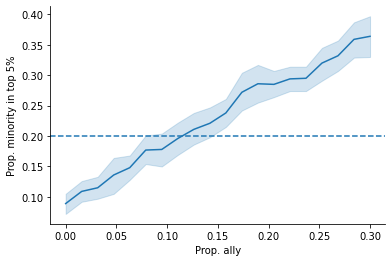

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

sns.lineplot(x=df_results.prop_ally, y=df_results.prop_min_top_k)
ax.set_xlabel("Prop. ally")
ax.set_ylabel("Prop. minority in top 5%")
ax.axhline(0.2, linestyle='--')

sns.despine()

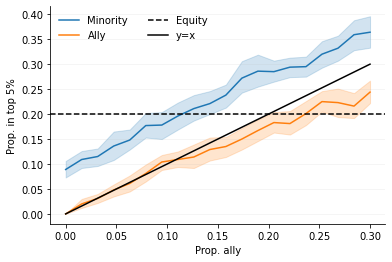

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

sns.lineplot(data=df_results, x='prop_ally', y='prop_min_top_k', label='Minority')
sns.lineplot(data=df_results, x='prop_ally', y='prop_ally_top_k', label='Ally')

ax.set_xlabel("Prop. ally")
ax.set_ylabel("Prop. in top 5%")
ax.axhline(0.2, linestyle='--', color='black', label='Equity')
ax.plot([0, 0.3], [0, 0.3], color='black', label='y=x')

ax.legend(frameon=False, ncol=2)

sns.despine()
ax.yaxis.grid(alpha=0.15)

Parameter sweep over the proportion of minorities who are "covert".

In [ ]:
results_covert = []
beta_list = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4,
            0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 
            0.85, 0.9, 0.95, 1]



for fm in np.linspace(0.05, 0.5, 10):
    for fraction_covert in np.linspace(0, fm, 10):
        for i in range(20):
            g = DPAH2(
                N=N,
                fm=fm - fraction_covert,
                fa=fraction_covert, # "Allies" and "covert" are functionally the same
                d=0.0015,
                plo_M=3,
                plo_m=3,
                h_MM=h_MM,
                h_mm=h_mm,
                verbose=False,
                seed=i)


            for beta in beta_list:
                # Top k nodes to consider for inequity. k = N * beta
                k = int(N * beta)
                prop_top_k_covert, prop_top_k_minority = compute_inequity(g, k)
                results_covert.append((fm, fraction_covert, beta, prop_top_k_covert, prop_top_k_minority))
                print((fm, fraction_covert, beta, prop_top_k_covert, prop_top_k_minority))

In [6]:
np.linspace(0.05, 0.5, 10)

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ])

In [ ]:
df_results_covert = pd.DataFrame(results_covert, columns=['prop_min','prop_covert', 'beta', 'prop_covert_top_k', 'prop_overt_top_k'])
df_results_covert['prop_covert_rescaled'] = df_results_covert['prop_covert'] / df_results_covert['prop_covert'].max()
df_results_covert['prop_all_minorities_top_k'] = df_results_covert['prop_covert_top_k'] + df_results_covert['prop_overt_top_k']

df_results_covert

In [63]:

df_results_covert.to_csv("group_A/results/covert_sweep_per_fm_top_k.csv", index=False)

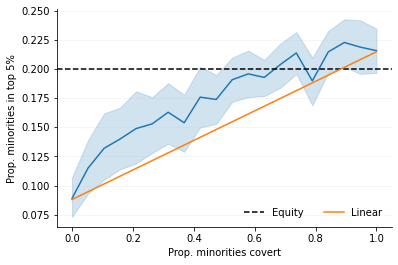

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

sns.lineplot(data=df_results_covert, x='prop_covert_rescaled', y='prop_all_minorities_top_k')

ax.set_xlabel("Prop. minorities covert")
ax.set_ylabel("Prop. minorities in top 5%")
ax.axhline(0.2, linestyle='--', color='black', label='Equity')
ax.plot([0, 1], [0.088, 0.215], label='Linear')

ax.legend(frameon=False, ncol=2, loc='lower right')

sns.despine()
ax.yaxis.grid(alpha=0.15)


# Directed Erdos-Renyi with homophily and allies

In [56]:
M = ER_homophily_allies(
                N=1000,
                fm=0.2,
                fa=0.1, # Fraction that are allies
                h_MM=h_MM,
                h_mm=h_mm,
                seed=0)

In [25]:
g = nx.from_numpy_matrix(M)
pr = nx.pagerank(g)

In [50]:
compute_inequity_ER_avg(M, 200, 0.2, 0.1)

(352.3257142857143, 899.5, 729.72)

In [65]:
results = []

for fm in np.linspace(0.05, 0.5, 10):
    for fraction_allies in np.linspace(0, 0.5 - fm, 10):
        for i in range(3):
            M = ER_homophily_allies(
                N=N,
                fm=fm,
                fa=fraction_allies, # Fraction that are allies
                h_MM=h_MM,
                h_mm=h_mm,
                seed=i)
            
            avg_rank_M, avg_rank_m, avg_rank_a = compute_inequity_ER_avg(M, k, fm, fraction_allies)
            results.append((fm, fraction_allies, avg_rank_M, avg_rank_m, avg_rank_a))
            print((fm, fraction_allies, avg_rank_M, avg_rank_m, avg_rank_a))

/Users/shzh8108/research/sfi/2022-GAINs/network_homophily/code/python/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shzh8108/research/sfi/2022-GAINs/network_homophily/code/python/venv/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(0.05, 0.0, 474.5, 974.5, nan)
(0.05, 0.0, 474.5, 974.5, nan)
(0.05, 0.0, 474.5, 974.5, nan)
(0.05, 0.05, 449.5, 974.5, 924.5)
(0.05, 0.05, 449.5, 974.5, 924.5)
(0.05, 0.05, 449.5, 974.5, 924.5)
(0.05, 0.1, 424.5, 974.5, 899.5)
(0.05, 0.1, 424.5, 974.5, 899.5)
(0.05, 0.1, 424.5, 974.5, 899.5)
(0.05, 0.15000000000000002, 399.5, 974.5, 874.5)
(0.05, 0.15000000000000002, 399.5, 974.5, 874.5)
(0.05, 0.15000000000000002, 399.5, 974.5, 874.5)
(0.05, 0.2, 374.5, 974.5, 849.5)
(0.05, 0.2, 374.5, 974.5, 849.5)
(0.05, 0.2, 374.5, 974.5, 849.5)
(0.05, 0.25, 349.5, 974.5, 824.5)
(0.05, 0.25, 349.5, 974.5, 824.5)
(0.05, 0.25, 349.5, 974.5, 824.5)
(0.05, 0.30000000000000004, 324.5, 974.5, 799.5)


KeyboardInterrupt: 

In [64]:
df_results_allies_ER = pd.DataFrame(results, columns=['prop_min','prop_ally', 'avg_rank_M', 'avg_rank_m', 'avg_rank_a'])
df_results_allies_ER.to_csv("group_A/results/ally_sweep_per_fm_avg_ER.csv", index=False)